# SVR

In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import uniform

# Set seed for reproducibility
np.random.seed(4)

# Load Dataset
df = pd.read_csv("stage_4_all_data_without_ma.csv")

# Define Features & Target
features = df.drop(['Actual', 'District', 'Trend', 'Detrended_Yield'], axis=1)
target = df['Detrended_Yield']
trend = df['Trend']
df['Predicted_detrend'] = np.nan  # Placeholder for predictions
groups = df['Year']

# Function for Consecutive GroupKFold Splits
def consecutive_group_kfold(df, n_splits=5):
    unique_years = sorted(df['Year'].unique())
    year_groups = np.array_split(unique_years, n_splits)

    for i in range(n_splits):
        test_years = year_groups[i]
        train_years = list(set(unique_years) - set(test_years))
        train_data = df[df['Year'].isin(train_years)]
        test_data = df[df['Year'].isin(test_years)]
        yield train_data, test_data

# Define Pipeline for Hyperparameter Tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

# Define Hyperparameter Search Space
param_dist = {
    'svr__C': uniform(0.1, 100),  # Regularization parameter
    'svr__epsilon': uniform(0.01, 1.0),  # Defines a margin of tolerance
    'svr__gamma': ['scale', 'auto']  # Kernel coefficient
}

# Initialize GroupKFold
n_splits = 5
group_kfold = GroupKFold(n_splits=n_splits)

# Perform Hyperparameter Tuning using a Full Training Dataset
full_X, full_y = features, target
search = RandomizedSearchCV(
    pipeline, param_distributions=param_dist,
    n_iter=10, cv=group_kfold, scoring='neg_mean_squared_error',
    n_jobs=-1, random_state=42, verbose=1
)
search.fit(full_X, full_y, groups=groups)

# Extract Best Parameters
best_params = search.best_params_
print("\n=== Best Hyperparameters Found ===")
print(best_params)

# Update Pipeline with Best Parameters
best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(
        C=best_params['svr__C'],
        epsilon=best_params['svr__epsilon'],
        gamma=best_params['svr__gamma']
    ))
])

# Initialize Scores
train_rmse_list, test_rmse_list, train_r2_list, test_r2_list = [], [], [], []

# Cross-Validation Loop
for fold, (train_data, test_data) in enumerate(consecutive_group_kfold(df, n_splits=10), 1):
    print(f"\n=== Fold {fold} ===")
    train_years = sorted(train_data['Year'].unique())
    test_years = sorted(test_data['Year'].unique())
    print(f"Training Years: {train_years}")
    print(f"Testing Years: {test_years}")

    # Extract Features & Target
    X_train, y_train_detrend = train_data[features.columns], train_data[target.name]
    X_test, y_test_detrend = test_data[features.columns], test_data[target.name]
    trend_train, trend_test = train_data['Trend'], test_data['Trend']

    # Train Best Model
    best_model.fit(X_train, y_train_detrend)

    # Predict on Train & Test
    y_train_pred_detrend = best_model.predict(X_train)
    y_test_pred_detrend = best_model.predict(X_test)

    # Convert Back to Actual Yield
    y_train_actual = y_train_detrend + trend_train
    y_test_actual = y_test_detrend + trend_test
    y_train_pred = y_train_pred_detrend + trend_train
    y_test_pred = y_test_pred_detrend + trend_test

    # Compute Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
    train_r2 = r2_score(y_train_actual, y_train_pred)
    test_r2 = r2_score(y_test_actual, y_test_pred)

    # Store Results
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)

    # Save Predictions in DataFrame
    df.loc[test_data.index, 'Predicted_detrend'] = y_test_pred_detrend
    df.loc[test_data.index, 'Predicted'] = y_test_pred

    # Print Fold Results
    print(f"Train RMSE: {train_rmse:.2f}, Train R²: {train_r2:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}, Test R²: {test_r2:.2f}")

# Compute Overall Averages
avg_train_rmse = np.mean(train_rmse_list)
avg_test_rmse = np.mean(test_rmse_list)
avg_train_r2 = np.mean(train_r2_list)
avg_test_r2 = np.mean(test_r2_list)

print("\n=== Final Results ===")
print(f"Average Training RMSE: {avg_train_rmse:.2f}")
print(f"Average Training R²: {avg_train_r2:.2f}")
print(f"Average Testing RMSE: {avg_test_rmse:.2f}")
print(f"Average Testing R²: {avg_test_r2:.2f}")

# Calculate Yearly RMSE and R²
yearly_metrics = df.groupby('Year').apply(
    lambda x: pd.Series({
        'RMSE': np.sqrt(mean_squared_error(x['Actual'], x['Predicted'])),
        'R2_Score': r2_score(x['Actual'], x['Predicted'])
    })
).reset_index()

# Average Yearly Metrics
avg_yearly_rmse = yearly_metrics['RMSE'].mean()
avg_yearly_r2_score = yearly_metrics['R2_Score'].mean()

print(f"Average Yearly RMSE: {avg_yearly_rmse:.2f}")
print(f"Average Yearly R² Score: {avg_yearly_r2_score:.2f}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits

=== Best Hyperparameters Found ===
{'svr__C': 97.47555188414591, 'svr__epsilon': 0.24277134043030424, 'svr__gamma': 'auto'}

=== Fold 1 ===
Training Years: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2004, 2005]
Train RMSE: 539.29, Train R²: 0.69
Test RMSE: 640.39, Test R²: 0.53

=== Fold 2 ===
Training Years: [2004, 2005, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2006, 2007]
Train RMSE: 529.58, Train R²: 0.71
Test RMSE: 693.29, Test R²: 0.49

=== Fold 3 ===
Training Years: [2004, 2005, 2006, 2007, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2008, 2009]
Train RMSE: 534.73, Train R²: 0.71
Test RMSE: 623.00, Test R²: 0.55

=== Fold 4 ===
Training Years: [2004, 2005, 2006, 2007, 2008, 2009, 2012, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2010, 2011]
Train RMSE: 505.65, Train R²: 0.73
Test RMSE: 892.50, Test R²: 0.24

=== Fold 

<ipython-input-9-41f7010b6351>:138: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_metrics = df.groupby('Year').apply(



=== Permutation Feature Importance (SVR) ===
                 Feature   Importance     Std_Dev
722               sif3.2  1657.798215  156.585573
1050  Centroid Longitude  1624.231054  156.900684
1051   Centroid Latitude  1566.853672  106.300966
526                ws4.6  1487.768949  280.519351
720                 sif3  1430.978313   90.171159
712               sif2.2  1305.676134  176.997211
226               rad2.6  1170.090587  104.442867
224               rad2.4  1137.650494   96.312689
702               sif1.2  1137.393402  188.376615
225               rad2.5  1088.585106  111.600075


<ipython-input-10-1ea0e7ec3de2>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


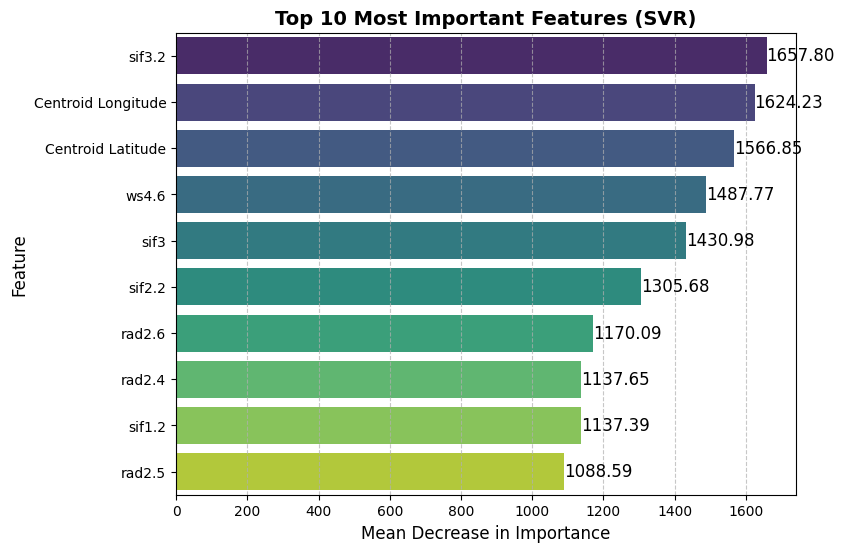

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

# Compute Permutation Feature Importance for SVR
pfi_results = permutation_importance(
    best_model, features, target, scoring='neg_mean_squared_error',
    n_repeats=2, random_state=42, n_jobs=-1
)

# Convert to DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance': pfi_results.importances_mean,
    'Std_Dev': pfi_results.importances_std
}).sort_values(by='Importance', ascending=False)

# Save to CSV
feature_importance_df.to_csv("svr_permutation_feature_importance.csv", index=False)

# Print Top 10 Features
print("\n=== Permutation Feature Importance (SVR) ===")
print(feature_importance_df.head(10))

# Select Top 10 Features
top_10_features = feature_importance_df.head(10)

# Plot Top 10 Most Important Features
plt.figure(figsize=(8, 6))
sns.barplot(
    data=top_10_features,
    x="Importance",
    y="Feature",
    palette="viridis"
)

# Annotate Values
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_width():.2f}",
                       (p.get_width(), p.get_y() + p.get_height()/2),
                       ha='left', va='center', fontsize=12, color='black')

# Labels & Title
plt.xlabel("Mean Decrease in Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Top 10 Most Important Features (SVR)", fontsize=14, fontweight="bold")
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show Plot
plt.show()

<ipython-input-4-7d25e926ea6f>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


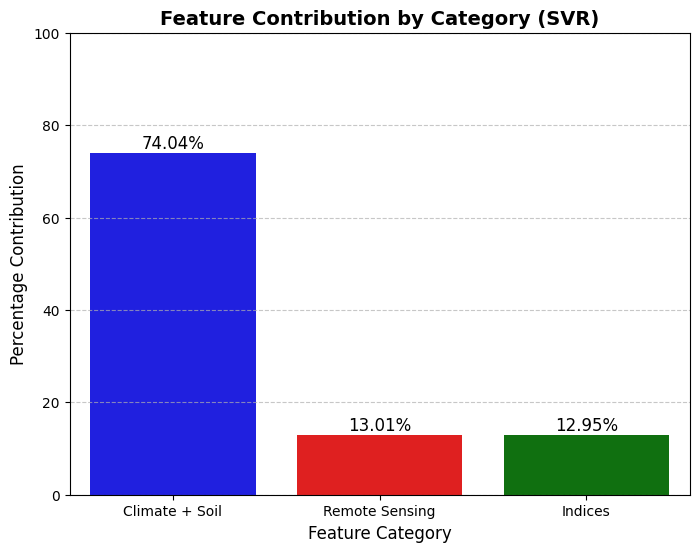

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re

feature_importance_df = pd.read_csv('/content/svr_permutation_feature_importance.csv')


# === FEATURE CONTRIBUTION BY CATEGORY ===

# Define Feature Categories
climate_soil_features = ["pcp", "PET", "rh", "rad", "tmax", "tmin", "vpd", "ws", "soil"]
remote_sensing_features = ["evi", "ndvi", "sif"]
indices_features = ["heatstress", "spi", "sti"]

# Extract Base Feature Names
feature_importance_df["Base_Feature"] = feature_importance_df["Feature"].str.extract(r'([a-zA-Z_]+)')

# Compute Mean Importance for Each Category
category_importance = {
    "Climate + Soil": feature_importance_df[feature_importance_df["Base_Feature"].isin(climate_soil_features)]["Importance"].sum(),
    "Remote Sensing": feature_importance_df[feature_importance_df["Base_Feature"].isin(remote_sensing_features)]["Importance"].sum(),
    "Indices": feature_importance_df[feature_importance_df["Base_Feature"].isin(indices_features)]["Importance"].sum(),
}

# Convert to DataFrame
category_importance_df = pd.DataFrame(list(category_importance.items()), columns=["Category", "Average Importance"])

# Normalize to Percentage
category_importance_df["Percentage Contribution"] = (category_importance_df["Average Importance"] /
                                                     category_importance_df["Average Importance"].sum()) * 100

# Plot Category Contribution
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=category_importance_df,
    x="Category",
    y="Percentage Contribution",
    palette=['blue', 'red', 'green']
)

# Annotate each bar
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}%",
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha="center", va="bottom", fontsize=12, color="black")

# Labels & Title
plt.title("Feature Contribution by Category (SVR)", fontsize=14, fontweight="bold")
plt.xlabel("Feature Category", fontsize=12)
plt.ylabel("Percentage Contribution", fontsize=12)
plt.ylim(0, 100)  # Ensure it represents 100%
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show Plot
plt.show()

# MLP

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, r2_score

# Set seed for reproducibility
np.random.seed(4)

# Load Dataset
df = pd.read_csv("stage_4_all_data_without_ma.csv")

# Define Features & Target
features = df.drop(['Actual', 'District', 'Trend', 'Detrended_Yield'], axis=1)
target = df['Detrended_Yield']
trend = df['Trend']
df['Predicted_detrend'] = np.nan  # Placeholder for predictions
groups = df['Year']

# Function for Consecutive GroupKFold Splits
def consecutive_group_kfold(df, n_splits=5):
    unique_years = sorted(df['Year'].unique())
    year_groups = np.array_split(unique_years, n_splits)

    for i in range(n_splits):
        test_years = year_groups[i]
        train_years = list(set(unique_years) - set(test_years))
        train_data = df[df['Year'].isin(train_years)]
        test_data = df[df['Year'].isin(test_years)]
        yield train_data, test_data

# Define MLP Pipeline
mlp_model = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(128, 64, 32, 16),  # Match TensorFlow architecture
        activation='relu',
        solver='adam',
        alpha=0.01,  # Equivalent to l2(0.01) regularization
        learning_rate_init=0.01,  # Match TensorFlow's learning rate
        batch_size=32,  # Match TensorFlow batch size
        max_iter=50,  # More iterations for stability
        early_stopping=True,  # Stops if validation loss doesn't improve
        random_state=42
    ))
])

# Initialize Scores
train_rmse_list, test_rmse_list, train_r2_list, test_r2_list = [], [], [], []

# Cross-Validation Loop
for fold, (train_data, test_data) in enumerate(consecutive_group_kfold(df, n_splits=10), 1):
    print(f"\n=== Fold {fold} ===")
    train_years = sorted(train_data['Year'].unique())
    test_years = sorted(test_data['Year'].unique())
    print(f"Training Years: {train_years}")
    print(f"Testing Years: {test_years}")

    # Extract Features & Target
    X_train, y_train_detrend = train_data[features.columns], train_data[target.name]
    X_test, y_test_detrend = test_data[features.columns], test_data[target.name]
    trend_train, trend_test = train_data['Trend'], test_data['Trend']

    # Train MLP Model
    mlp_model.fit(X_train, y_train_detrend)

    # Predict on Train & Test
    y_train_pred_detrend = mlp_model.predict(X_train)
    y_test_pred_detrend = mlp_model.predict(X_test)

    # Convert Back to Actual Yield
    y_train_actual = y_train_detrend + trend_train
    y_test_actual = y_test_detrend + trend_test
    y_train_pred = y_train_pred_detrend + trend_train
    y_test_pred = y_test_pred_detrend + trend_test

    # Compute Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
    train_r2 = r2_score(y_train_actual, y_train_pred)
    test_r2 = r2_score(y_test_actual, y_test_pred)

    # Store Results
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)

    # Save Predictions in DataFrame
    df.loc[test_data.index, 'Predicted_detrend'] = y_test_pred_detrend
    df.loc[test_data.index, 'Predicted'] = y_test_pred

    # Print Fold Results
    print(f"Train RMSE: {train_rmse:.2f}, Train R²: {train_r2:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}, Test R²: {test_r2:.2f}")

# Compute Overall Averages
avg_train_rmse = np.mean(train_rmse_list)
avg_test_rmse = np.mean(test_rmse_list)
avg_train_r2 = np.mean(train_r2_list)
avg_test_r2 = np.mean(test_r2_list)

print("\n=== Final Results ===")
print(f"Average Training RMSE: {avg_train_rmse:.2f}")
print(f"Average Training R²: {avg_train_r2:.2f}")
print(f"Average Testing RMSE: {avg_test_rmse:.2f}")
print(f"Average Testing R²: {avg_test_r2:.2f}")

# Calculate Yearly RMSE and R²
yearly_metrics = df.groupby('Year').apply(
    lambda x: pd.Series({
        'RMSE': np.sqrt(mean_squared_error(x['Actual'], x['Predicted'])),
        'R2_Score': r2_score(x['Actual'], x['Predicted'])
    })
).reset_index()

# Average Yearly Metrics
avg_yearly_rmse = yearly_metrics['RMSE'].mean()
avg_yearly_r2_score = yearly_metrics['R2_Score'].mean()

print(f"Average Yearly RMSE: {avg_yearly_rmse:.2f}")
print(f"Average Yearly R² Score: {avg_yearly_r2_score:.2f}")



=== Fold 1 ===
Training Years: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2004, 2005]
Train RMSE: 199.28, Train R²: 0.96
Test RMSE: 697.50, Test R²: 0.44

=== Fold 2 ===
Training Years: [2004, 2005, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2006, 2007]
Train RMSE: 210.20, Train R²: 0.95
Test RMSE: 528.21, Test R²: 0.71

=== Fold 3 ===
Training Years: [2004, 2005, 2006, 2007, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2008, 2009]
Train RMSE: 229.40, Train R²: 0.95
Test RMSE: 626.22, Test R²: 0.55

=== Fold 4 ===
Training Years: [2004, 2005, 2006, 2007, 2008, 2009, 2012, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2010, 2011]
Train RMSE: 200.77, Train R²: 0.96
Test RMSE: 666.83, Test R²: 0.58

=== Fold 5 ===
Training Years: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2012]
Train RMSE: 173.59, Train R²: 0.97
Test RMSE: 777.44, Test R²: 

<ipython-input-13-b27b428055ba>:112: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_metrics = df.groupby('Year').apply(



=== Fold 1 ===
Training Years: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2004, 2005]
Train RMSE: 199.28, Train R²: 0.96
Test RMSE: 697.50, Test R²: 0.44

=== Fold 2 ===
Training Years: [2004, 2005, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2006, 2007]
Train RMSE: 210.20, Train R²: 0.95
Test RMSE: 528.21, Test R²: 0.71

=== Fold 3 ===
Training Years: [2004, 2005, 2006, 2007, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2008, 2009]
Train RMSE: 229.40, Train R²: 0.95
Test RMSE: 626.22, Test R²: 0.55

=== Fold 4 ===
Training Years: [2004, 2005, 2006, 2007, 2008, 2009, 2012, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2010, 2011]
Train RMSE: 200.77, Train R²: 0.96
Test RMSE: 666.83, Test R²: 0.58

=== Fold 5 ===
Training Years: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2012]
Train RMSE: 173.59, Train R²: 0.97
Test RMSE: 777.44, Test R²: 

<ipython-input-1-565d0d156d98>:118: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_metrics = df.groupby('Year').apply(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

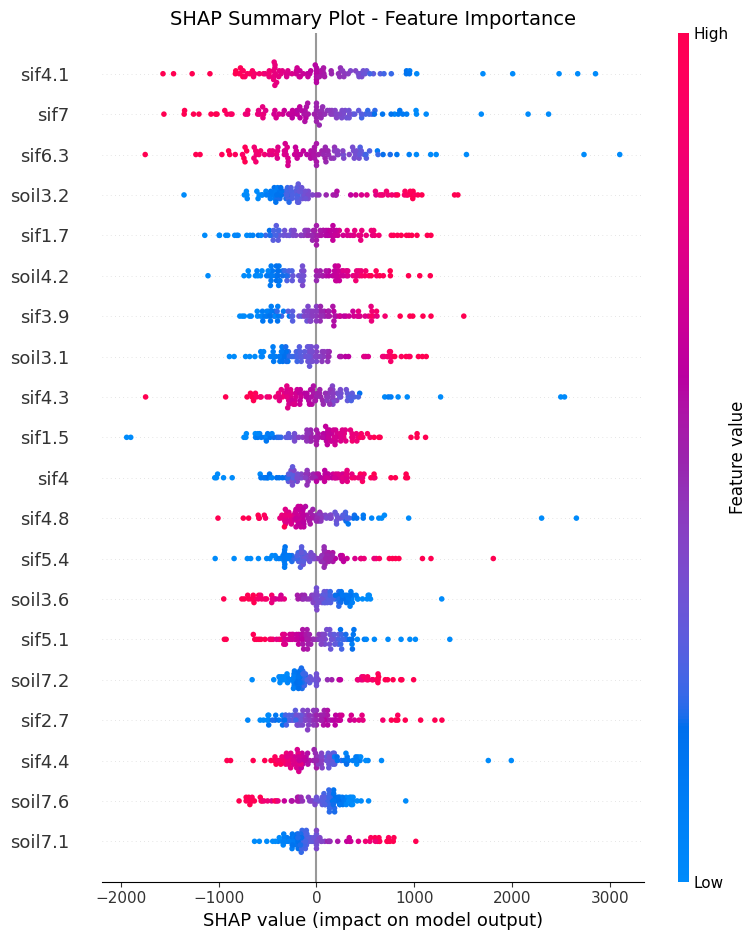

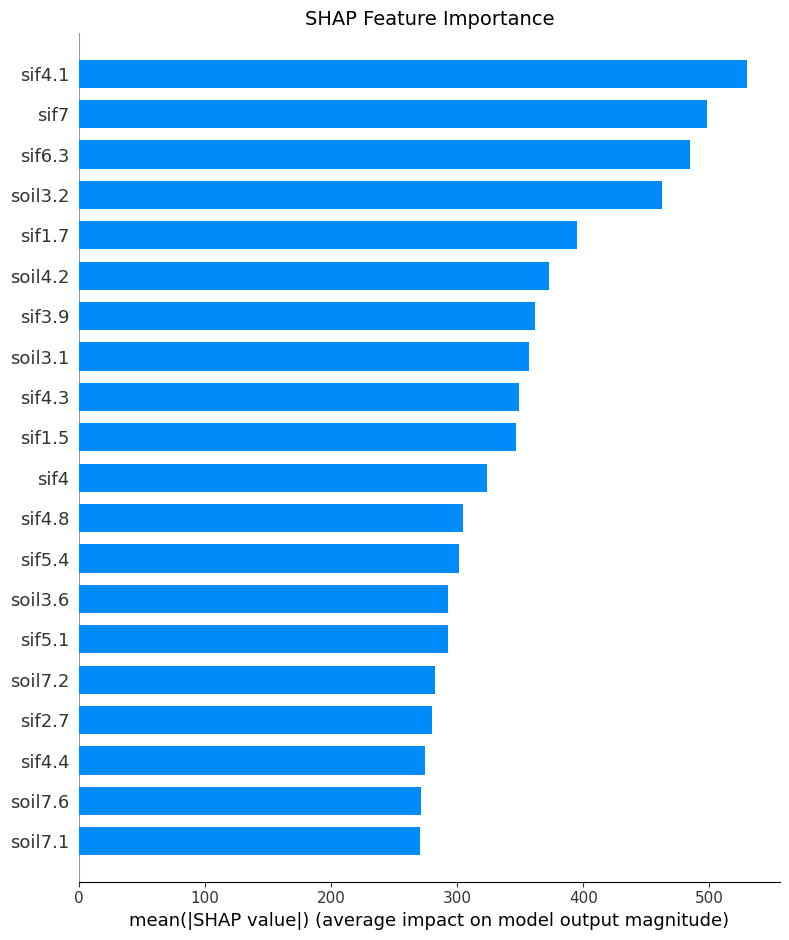

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


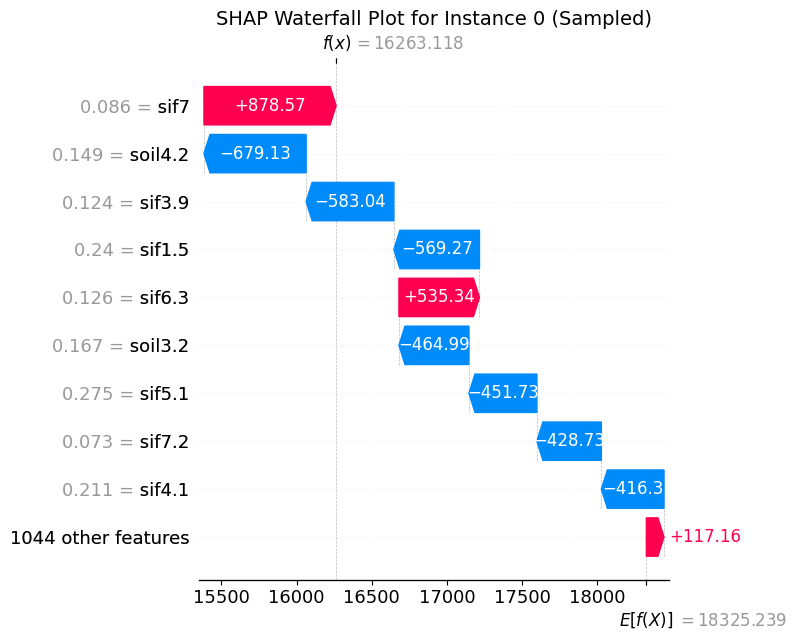

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
import shap
import matplotlib.pyplot as plt
from IPython.display import display

# Initialize SHAP JavaScript for interactive plots
shap.initjs()

# Set seed for reproducibility
np.random.seed(4)

# Load Dataset
df = pd.read_csv("stage_4_all_data_without_ma.csv")

# Define Features & Target
features = df.drop(['Actual', 'District', 'Trend', 'Detrended_Yield'], axis=1)
target = df['Detrended_Yield']
trend = df['Trend']
df['Predicted_detrend'] = np.nan  # Placeholder for predictions
groups = df['Year']

# Function for Consecutive GroupKFold Splits
def consecutive_group_kfold(df, n_splits=5):
    unique_years = sorted(df['Year'].unique())
    year_groups = np.array_split(unique_years, n_splits)

    for i in range(n_splits):
        test_years = year_groups[i]
        train_years = list(set(unique_years) - set(test_years))
        train_data = df[df['Year'].isin(train_years)]
        test_data = df[df['Year'].isin(test_years)]
        yield train_data, test_data

# Define MLP Pipeline
mlp_model = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(128, 64, 32, 16),  # Match TensorFlow architecture
        activation='relu',
        solver='adam',
        alpha=0.01,  # Equivalent to l2(0.01) regularization
        learning_rate_init=0.01,  # Match TensorFlow's learning rate
        batch_size=32,  # Match TensorFlow batch size
        max_iter=50,  # More iterations for stability
        early_stopping=True,  # Stops if validation loss doesn't improve
        random_state=42
    ))
])

# Initialize Scores
train_rmse_list, test_rmse_list, train_r2_list, test_r2_list = [], [], [], []

# Cross-Validation Loop
for fold, (train_data, test_data) in enumerate(consecutive_group_kfold(df, n_splits=10), 1):
    print(f"\n=== Fold {fold} ===")
    train_years = sorted(train_data['Year'].unique())
    test_years = sorted(test_data['Year'].unique())
    print(f"Training Years: {train_years}")
    print(f"Testing Years: {test_years}")

    # Extract Features & Target
    X_train, y_train_detrend = train_data[features.columns], train_data[target.name]
    X_test, y_test_detrend = test_data[features.columns], test_data[target.name]
    trend_train, trend_test = train_data['Trend'], test_data['Trend']

    # Train MLP Model
    mlp_model.fit(X_train, y_train_detrend)

    # Predict on Train & Test
    y_train_pred_detrend = mlp_model.predict(X_train)
    y_test_pred_detrend = mlp_model.predict(X_test)

    # Convert Back to Actual Yield
    y_train_actual = y_train_detrend + trend_train
    y_test_actual = y_test_detrend + trend_test
    y_train_pred = y_train_pred_detrend + trend_train
    y_test_pred = y_test_pred_detrend + trend_test

    # Compute Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
    train_r2 = r2_score(y_train_actual, y_train_pred)
    test_r2 = r2_score(y_test_actual, y_test_pred)

    # Store Results
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)

    # Save Predictions in DataFrame
    df.loc[test_data.index, 'Predicted_detrend'] = y_test_pred_detrend
    df.loc[test_data.index, 'Predicted'] = y_test_pred

    # Print Fold Results
    print(f"Train RMSE: {train_rmse:.2f}, Train R²: {train_r2:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}, Test R²: {test_r2:.2f}")

# Compute Overall Averages
avg_train_rmse = np.mean(train_rmse_list)
avg_test_rmse = np.mean(test_rmse_list)
avg_train_r2 = np.mean(train_r2_list)
avg_test_r2 = np.mean(test_r2_list)

print("\n=== Final Results ===")
print(f"Average Training RMSE: {avg_train_rmse:.2f}")
print(f"Average Training R²: {avg_train_r2:.2f}")
print(f"Average Testing RMSE: {avg_test_rmse:.2f}")
print(f"Average Testing R²: {avg_test_r2:.2f}")

# Calculate Yearly RMSE and R²
yearly_metrics = df.groupby('Year').apply(
    lambda x: pd.Series({
        'RMSE': np.sqrt(mean_squared_error(x['Actual'], x['Predicted'])),
        'R2_Score': r2_score(x['Actual'], x['Predicted'])
    })
).reset_index()

# Average Yearly Metrics
avg_yearly_rmse = yearly_metrics['RMSE'].mean()
avg_yearly_r2_score = yearly_metrics['R2_Score'].mean()

print(f"Average Yearly RMSE: {avg_yearly_rmse:.2f}")
print(f"Average Yearly R² Score: {avg_yearly_r2_score:.2f}")

# --- SHAP Analysis ---
# Train the MLP model on the full dataset for SHAP analysis
mlp_model.fit(features, target)

# Create a SHAP explainer for the MLP model using KernelExplainer
# Sample the data for KernelExplainer to speed up computation (e.g., 1000 rows)
background_data = shap.sample(features, 100, random_state=4)
scaled_background = mlp_model.named_steps['scaler'].transform(background_data)

# Define a function to predict with the pipeline
def pipeline_predict(data):
    return mlp_model.predict(data)

explainer = shap.KernelExplainer(pipeline_predict, scaled_background)

# Calculate SHAP values for a subset of the dataset (e.g., 100 rows for speed)
X_sample = features.sample(100, random_state=4)
scaled_X_sample = mlp_model.named_steps['scaler'].transform(X_sample)
shap_values = explainer.shap_values(scaled_X_sample)

# Summary Plot - Feature Importance (Beeswarm Plot)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_sample, show=False)
plt.title("SHAP Summary Plot - Feature Importance", fontsize=14)
plt.tight_layout()
plt.show()

# SHAP Feature Importance (Bar Plot with Mean Absolute SHAP Values)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title("SHAP Feature Importance", fontsize=14)
plt.tight_layout()
plt.show()

# SHAP Waterfall Plot for a Single Instance (e.g., first instance in the sample)
instance_idx = 0
X_instance = X_sample.iloc[[instance_idx]]
scaled_instance = mlp_model.named_steps['scaler'].transform(X_instance)
shap_values_instance = explainer.shap_values(scaled_instance)[0]

# Create an Explanation object with feature names
explanation = shap.Explanation(values=shap_values_instance,
                              base_values=explainer.expected_value,
                              data=X_instance.values[0],
                              feature_names=X_sample.columns)

plt.figure(figsize=(10, 6))
shap.waterfall_plot(explanation, show=False)
plt.title(f"SHAP Waterfall Plot for Instance {instance_idx} (Sampled)", fontsize=14)
plt.tight_layout()
plt.show()


=== Permutation Feature Importance (MLP) ===
                 Feature   Importance     Std_Dev
705               sif1.5  9744.181028  764.739199
760                 sif7  7502.117070  656.723834
772        heatstress1.2  7149.810654  493.896411
769               sif7.9  6734.853305  839.633425
720                 sif3  6192.737391  235.948560
528                ws4.8  4641.788138  447.041800
599               evi4.9  4636.935560  332.156005
707               sif1.7  4593.227321  670.992620
797        heatstress3.7  4523.297639  582.768571
1050  Centroid Longitude  4437.613675  361.409686


<ipython-input-14-672a86f415f6>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


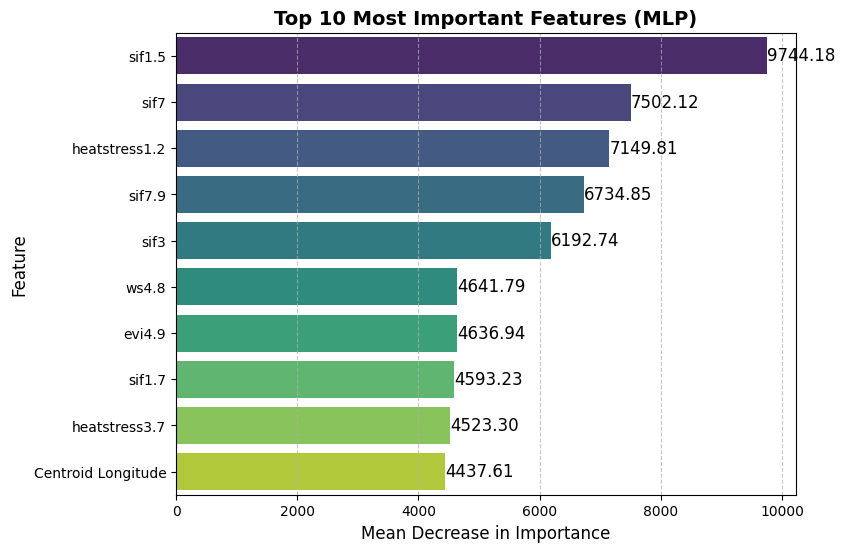

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

# Compute Permutation Feature Importance for MLP
pfi_results = permutation_importance(
    mlp_model, features, target, scoring='neg_mean_squared_error',
    n_repeats=10, random_state=42, n_jobs=-1
)

# Convert to DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance': pfi_results.importances_mean,
    'Std_Dev': pfi_results.importances_std
}).sort_values(by='Importance', ascending=False)

# Save to CSV
feature_importance_df.to_csv("mlp_permutation_feature_importance.csv", index=False)

# Print Top 10 Features
print("\n=== Permutation Feature Importance (MLP) ===")
print(feature_importance_df.head(10))

# Select Top 10 Features
top_10_features = feature_importance_df.head(10)

# Plot Top 10 Most Important Features
plt.figure(figsize=(8, 6))
sns.barplot(
    data=top_10_features,
    x="Importance",
    y="Feature",
    palette="viridis"
)

# Annotate Values
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_width():.2f}",
                       (p.get_width(), p.get_y() + p.get_height()/2),
                       ha='left', va='center', fontsize=12, color='black')

# Labels & Title
plt.xlabel("Mean Decrease in Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Top 10 Most Important Features (MLP)", fontsize=14, fontweight="bold")
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show Plot
plt.show()

<ipython-input-5-7729d2c96925>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


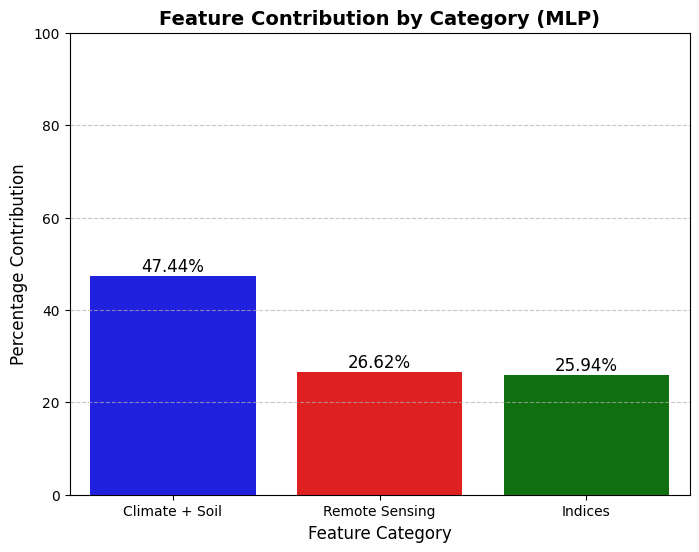

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re

feature_importance_df = pd.read_csv('mlp_permutation_feature_importance.csv')


# === FEATURE CONTRIBUTION BY CATEGORY ===

# Define Feature Categories
climate_soil_features = ["pcp", "PET", "rh", "rad", "tmax", "tmin", "vpd", "ws", "soil"]
remote_sensing_features = ["evi", "ndvi", "sif"]
indices_features = ["heatstress", "spi", "sti"]

# Extract Base Feature Names
feature_importance_df["Base_Feature"] = feature_importance_df["Feature"].str.extract(r'([a-zA-Z_]+)')

# Compute Mean Importance for Each Category
category_importance = {
    "Climate + Soil": feature_importance_df[feature_importance_df["Base_Feature"].isin(climate_soil_features)]["Importance"].sum(),
    "Remote Sensing": feature_importance_df[feature_importance_df["Base_Feature"].isin(remote_sensing_features)]["Importance"].sum(),
    "Indices": feature_importance_df[feature_importance_df["Base_Feature"].isin(indices_features)]["Importance"].sum(),
}

# Convert to DataFrame
category_importance_df = pd.DataFrame(list(category_importance.items()), columns=["Category", "Average Importance"])

# Normalize to Percentage
category_importance_df["Percentage Contribution"] = (category_importance_df["Average Importance"] /
                                                     category_importance_df["Average Importance"].sum()) * 100

# Plot Category Contribution
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=category_importance_df,
    x="Category",
    y="Percentage Contribution",
    palette=['blue', 'red', 'green']
)

# Annotate each bar
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}%",
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha="center", va="bottom", fontsize=12, color="black")

# Labels & Title
plt.title("Feature Contribution by Category (MLP)", fontsize=14, fontweight="bold")
plt.xlabel("Feature Category", fontsize=12)
plt.ylabel("Percentage Contribution", fontsize=12)
plt.ylim(0, 100)  # Ensure it represents 100%
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show Plot
plt.show()

# Decision Tree

In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint

# Set seed for reproducibility
np.random.seed(4)

# Load Dataset
df = pd.read_csv("stage_4_all_data_without_ma.csv")

# Define Features & Target
features = df.drop(['Actual', 'District', 'Trend', 'Detrended_Yield'], axis=1)
target = df['Detrended_Yield']
trend = df['Trend']
df['Predicted_detrend'] = np.nan  # Placeholder for predictions
groups = df['Year']

# Function for Consecutive GroupKFold Splits
def consecutive_group_kfold(df, n_splits=5):
    unique_years = sorted(df['Year'].unique())
    year_groups = np.array_split(unique_years, n_splits)

    for i in range(n_splits):
        test_years = year_groups[i]
        train_years = list(set(unique_years) - set(test_years))
        train_data = df[df['Year'].isin(train_years)]
        test_data = df[df['Year'].isin(test_years)]
        yield train_data, test_data

# Define Pipeline for Hyperparameter Tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dt', DecisionTreeRegressor(random_state=42))
])

# Define Hyperparameter Search Space
param_dist = {
    'dt__max_depth': randint(1, 30),            # Depth of tree
    'dt__min_samples_split': randint(2, 50),    # Min samples to split node
    'dt__min_samples_leaf': randint(1, 20),     # Min samples per leaf
}

# Initialize GroupKFold
n_splits = 5
group_kfold = GroupKFold(n_splits=n_splits)

# Perform Hyperparameter Tuning using a Full Training Dataset
full_X, full_y = features, target
search = RandomizedSearchCV(
    pipeline, param_distributions=param_dist,
    n_iter=5, cv=group_kfold, scoring='neg_mean_squared_error',
    n_jobs=-1, random_state=42, verbose=1
)
search.fit(full_X, full_y, groups=groups)

# Extract Best Parameters
best_params = search.best_params_
print("\n=== Best Hyperparameters Found ===")
print(best_params)

# Update Pipeline with Best Parameters
best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('dt', DecisionTreeRegressor(
        random_state=42,
        max_depth=best_params['dt__max_depth'],
        min_samples_split=best_params['dt__min_samples_split'],
        min_samples_leaf=best_params['dt__min_samples_leaf']
    ))
])

# Initialize Scores
train_rmse_list, test_rmse_list, train_r2_list, test_r2_list = [], [], [], []

# Cross-Validation Loop
for fold, (train_data, test_data) in enumerate(consecutive_group_kfold(df, n_splits=5), 1):
    print(f"\n=== Fold {fold} ===")
    train_years = sorted(train_data['Year'].unique())
    test_years = sorted(test_data['Year'].unique())
    print(f"Training Years: {train_years}")
    print(f"Testing Years: {test_years}")

    # Extract Features & Target
    X_train, y_train_detrend = train_data[features.columns], train_data[target.name]
    X_test, y_test_detrend = test_data[features.columns], test_data[target.name]
    trend_train, trend_test = train_data['Trend'], test_data['Trend']

    # Train Best Model
    best_model.fit(X_train, y_train_detrend)

    # Predict on Train & Test
    y_train_pred_detrend = best_model.predict(X_train)
    y_test_pred_detrend = best_model.predict(X_test)

    # Convert Back to Actual Yield
    y_train_actual = y_train_detrend + trend_train
    y_test_actual = y_test_detrend + trend_test
    y_train_pred = y_train_pred_detrend + trend_train
    y_test_pred = y_test_pred_detrend + trend_test

    # Compute Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
    train_r2 = r2_score(y_train_actual, y_train_pred)
    test_r2 = r2_score(y_test_actual, y_test_pred)

    # Store Results
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)

    # Save Predictions in DataFrame
    df.loc[test_data.index, 'Predicted_detrend'] = y_test_pred_detrend
    df.loc[test_data.index, 'Predicted'] = y_test_pred

    # Print Fold Results
    print(f"Train RMSE: {train_rmse:.2f}, Train R²: {train_r2:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}, Test R²: {test_r2:.2f}")

# Compute Overall Averages
avg_train_rmse = np.mean(train_rmse_list)
avg_test_rmse = np.mean(test_rmse_list)
avg_train_r2 = np.mean(train_r2_list)
avg_test_r2 = np.mean(test_r2_list)

print("\n=== Final Results ===")
print(f"Average Training RMSE: {avg_train_rmse:.2f}")
print(f"Average Training R²: {avg_train_r2:.2f}")
print(f"Average Testing RMSE: {avg_test_rmse:.2f}")
print(f"Average Testing R²: {avg_test_r2:.2f}")

# Calculate Yearly RMSE and R²
yearly_metrics = df.groupby('Year').apply(
    lambda x: pd.Series({
        'RMSE': np.sqrt(mean_squared_error(x['Actual'], x['Predicted'])),
        'R2_Score': r2_score(x['Actual'], x['Predicted'])
    })
).reset_index()

# Average Yearly Metrics
avg_yearly_rmse = yearly_metrics['RMSE'].mean()
avg_yearly_r2_score = yearly_metrics['R2_Score'].mean()

print(f"Average Yearly RMSE: {avg_yearly_rmse:.2f}")
print(f"Average Yearly R² Score: {avg_yearly_r2_score:.2f}")

# Save Predictions to CSV
df.to_csv("decision_tree_predictions.csv", index=False)


Fitting 5 folds for each of 5 candidates, totalling 25 fits

=== Best Hyperparameters Found ===
{'dt__max_depth': 7, 'dt__min_samples_leaf': 15, 'dt__min_samples_split': 44}

=== Fold 1 ===
Training Years: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2004, 2005, 2006]
Train RMSE: 399.63, Train R²: 0.83
Test RMSE: 623.69, Test R²: 0.55

=== Fold 2 ===
Training Years: [2004, 2005, 2006, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2007, 2008, 2009]
Train RMSE: 374.40, Train R²: 0.85
Test RMSE: 547.81, Test R²: 0.68

=== Fold 3 ===
Training Years: [2004, 2005, 2006, 2007, 2008, 2009, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2010, 2011, 2012]
Train RMSE: 407.49, Train R²: 0.83
Test RMSE: 745.69, Test R²: 0.39

=== Fold 4 ===
Training Years: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2016, 2017]
Testing Years: [2013, 2014, 2015]
Train RMSE: 426.82, Train R²: 0.82
Test RMSE: 776.30, Test R²: 0.28

=== Fold 5 ===
Traini

<ipython-input-1-0dcaf44f7ebf>:139: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_metrics = df.groupby('Year').apply(


```
=== Final Results ===
Average Training RMSE: 403.37
Average Training R²: 0.83
Average Testing RMSE: 664.57
Average Testing R²: 0.45
Average Yearly RMSE: 660.61
Average Yearly R² Score: 0.45
```

In [ ]:
from sklearn.inspection import permutation_importance

# Compute Permutation Feature Importance
pfi_results = permutation_importance(
    best_model, full_X, full_y, scoring='neg_mean_squared_error', n_repeats=10, random_state=42, n_jobs=-1
)

# Convert to DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': full_X.columns,
    'Importance': pfi_results.importances_mean,
    'Std_Dev': pfi_results.importances_std
}).sort_values(by='Importance', ascending=False)

# Save to CSV
feature_importance_df.to_csv("permutation_feature_importance.csv", index=False)

# Print Results
print("\n=== Permutation Feature Importance ===")
print(feature_importance_df)



=== Permutation Feature Importance ===
                 Feature    Importance       Std_Dev
1051   Centroid Latitude  1.442946e+06  38629.423531
1050  Centroid Longitude  3.751389e+05  14393.886755
522                ws4.2  1.121475e+05   9092.543151
769               sif7.9  6.504399e+04   5003.919839
352              tmin1.2  5.688868e+04   6178.790274
...                  ...           ...           ...
360                tmin2  0.000000e+00      0.000000
361              tmin2.1  0.000000e+00      0.000000
362              tmin2.2  0.000000e+00      0.000000
363              tmin2.3  0.000000e+00      0.000000
1052                Year  0.000000e+00      0.000000

[1053 rows x 3 columns]


<ipython-input-11-c1a6fab90508>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


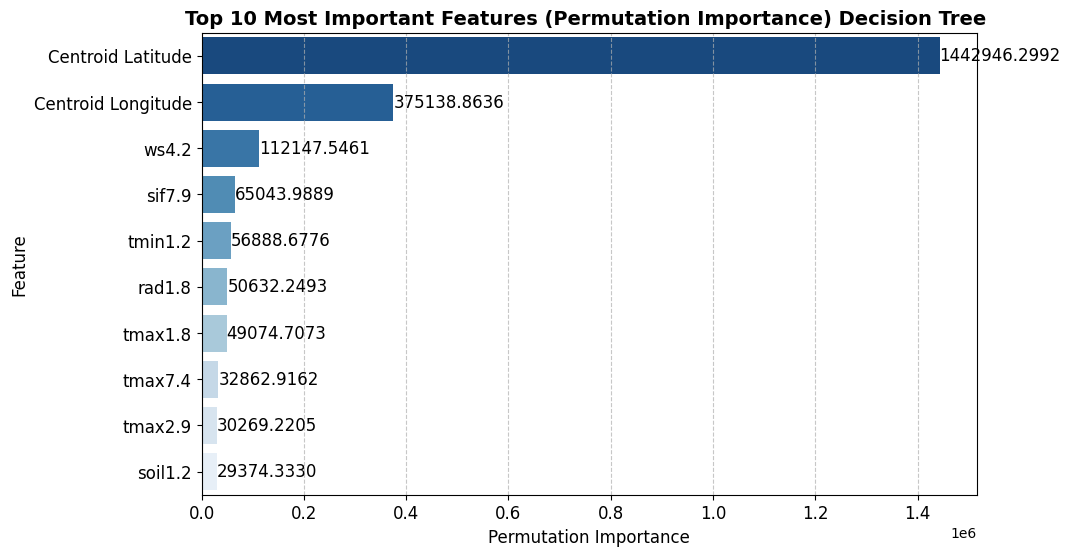

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the top 10 most important features
top_10_features = feature_importance_df.head(10)

# Define a color palette (using cool blues for aesthetics)
colors = sns.color_palette("Blues_r", len(top_10_features))

# Plot Bar Chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top_10_features,
    x="Importance",
    y="Feature",
    palette=colors
)

# Annotate each bar with its importance value
for p in ax.patches:
    ax.annotate(
        f"{p.get_width():.4f}",  # Format importance value
        (p.get_width(), p.get_y() + p.get_height() / 2),
        ha="left", va="center",
        fontsize=12, color="black"
    )

# Set labels and title
plt.title("Top 10 Most Important Features (Permutation Importance) Decision Tree ", fontsize=14, fontweight="bold")
plt.xlabel("Permutation Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


<ipython-input-12-9f1105bf0d0c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["Percentage Contribution"] = (filtered_df["Percentage Contribution"] / filtered_df["Percentage Contribution"].sum()) * 100
<ipython-input-12-9f1105bf0d0c>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


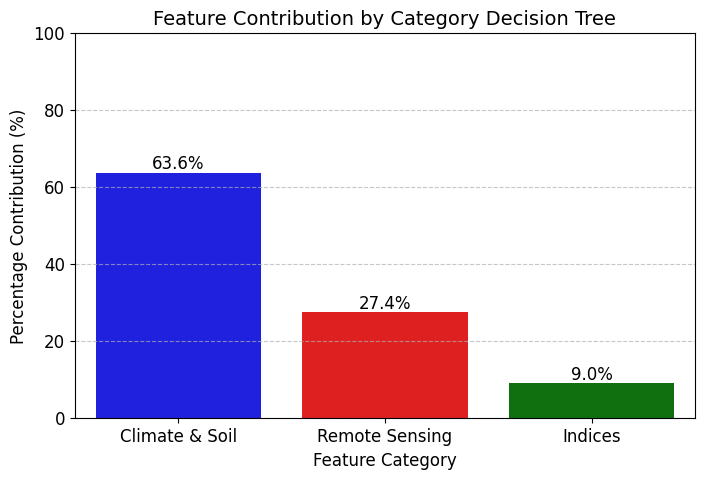

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out "Other" category
filtered_df = category_importance_df[category_importance_df["Feature Category"].isin(["Climate & Soil", "Remote Sensing", "Indices"])]

# Define better colors for clarity
colors = ['blue', 'red','green']

# Normalize percentages to ensure they sum to 100%
filtered_df["Percentage Contribution"] = (filtered_df["Percentage Contribution"] / filtered_df["Percentage Contribution"].sum()) * 100

# Plot Bar Chart
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=filtered_df,
    x="Feature Category",
    y="Percentage Contribution",
    palette=colors
)

# Annotate each bar with its percentage value
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.1f}%",  # Format percentage with 1 decimal place
        (p.get_x() + p.get_width() / 2., p.get_height()),  # Position on top of the bar
        ha="center", va="bottom",
        fontsize=12, color="black"
    )

# Set labels and grid
plt.title("Feature Contribution by Category Decision Tree", fontsize=14)
plt.ylabel("Percentage Contribution (%)", fontsize=12)
plt.xlabel("Feature Category", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 100)  # Ensures y-axis goes up to 100%
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


# Random forest

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint, uniform

# Set seed for reproducibility
np.random.seed(4)

# Load Dataset
df = pd.read_csv("stage_4_all_data_without_ma.csv")

# Define Features & Target
features = df.drop(['Actual', 'District', 'Trend', 'Detrended_Yield'], axis=1)
target = df['Detrended_Yield']
trend = df['Trend']
df['Predicted_detrend'] = np.nan  # Placeholder for predictions
groups = df['Year']

# Function for Consecutive GroupKFold Splits
def consecutive_group_kfold(df, n_splits=5):
    unique_years = sorted(df['Year'].unique())
    year_groups = np.array_split(unique_years, n_splits)

    for i in range(n_splits):
        test_years = year_groups[i]
        train_years = list(set(unique_years) - set(test_years))
        train_data = df[df['Year'].isin(train_years)]
        test_data = df[df['Year'].isin(test_years)]
        yield train_data, test_data

# Define Pipeline for Hyperparameter Tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

best_params = {'rf__max_depth': 10, 'rf__max_features': 0.8287529872223567, 'rf__min_samples_leaf': 6, 'rf__min_samples_split': 11, 'rf__n_estimators': 309}

print("\n=== Best Hyperparameters Found ===")
print(best_params)

# Update Pipeline with Best Parameters
best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(
        random_state=42,
        n_jobs=-1,
        n_estimators=best_params['rf__n_estimators'],
        max_depth=best_params['rf__max_depth'],
        min_samples_split=best_params['rf__min_samples_split'],
        min_samples_leaf=best_params['rf__min_samples_leaf'],
        max_features=best_params['rf__max_features']
    ))
])

# Initialize Scores
train_rmse_list, test_rmse_list, train_r2_list, test_r2_list = [], [], [], []

# Cross-Validation Loop
for fold, (train_data, test_data) in enumerate(consecutive_group_kfold(df, n_splits=5), 1):
    print(f"\n=== Fold {fold} ===")
    train_years = sorted(train_data['Year'].unique())
    test_years = sorted(test_data['Year'].unique())
    print(f"Training Years: {train_years}")
    print(f"Testing Years: {test_years}")

    # Extract Features & Target
    X_train, y_train_detrend = train_data[features.columns], train_data[target.name]
    X_test, y_test_detrend = test_data[features.columns], test_data[target.name]
    trend_train, trend_test = train_data['Trend'], test_data['Trend']

    # Train Best Model
    best_model.fit(X_train, y_train_detrend)

    # Predict on Train & Test
    y_train_pred_detrend = best_model.predict(X_train)
    y_test_pred_detrend = best_model.predict(X_test)

    # Convert Back to Actual Yield
    y_train_actual = y_train_detrend + trend_train
    y_test_actual = y_test_detrend + trend_test
    y_train_pred = y_train_pred_detrend + trend_train
    y_test_pred = y_test_pred_detrend + trend_test

    # Compute Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
    train_r2 = r2_score(y_train_actual, y_train_pred)
    test_r2 = r2_score(y_test_actual, y_test_pred)

    # Store Results
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)

    # Save Predictions in DataFrame
    df.loc[test_data.index, 'Predicted_detrend'] = y_test_pred_detrend
    df.loc[test_data.index, 'Predicted'] = y_test_pred

    # Print Fold Results
    print(f"Train RMSE: {train_rmse:.2f}, Train R²: {train_r2:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}, Test R²: {test_r2:.2f}")

# Compute Overall Averages
avg_train_rmse = np.mean(train_rmse_list)
avg_test_rmse = np.mean(test_rmse_list)
avg_train_r2 = np.mean(train_r2_list)
avg_test_r2 = np.mean(test_r2_list)

print("\n=== Final Results ===")
print(f"Average Training RMSE: {avg_train_rmse:.2f}")
print(f"Average Training R²: {avg_train_r2:.2f}")
print(f"Average Testing RMSE: {avg_test_rmse:.2f}")
print(f"Average Testing R²: {avg_test_r2:.2f}")

# Calculate Yearly RMSE and R²
yearly_metrics = df.groupby('Year').apply(
    lambda x: pd.Series({
        'RMSE': np.sqrt(mean_squared_error(x['Actual'], x['Predicted'])),
        'R2_Score': r2_score(x['Actual'], x['Predicted'])
    })
).reset_index()

# Average Yearly Metrics
avg_yearly_rmse = yearly_metrics['RMSE'].mean()
avg_yearly_r2_score = yearly_metrics['R2_Score'].mean()

print(f"Average Yearly RMSE: {avg_yearly_rmse:.2f}")
print(f"Average Yearly R² Score: {avg_yearly_r2_score:.2f}")



=== Best Hyperparameters Found ===
{'rf__max_depth': 10, 'rf__max_features': 0.8287529872223567, 'rf__min_samples_leaf': 6, 'rf__min_samples_split': 11, 'rf__n_estimators': 309}

=== Fold 1 ===
Training Years: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2004, 2005, 2006]
Train RMSE: 244.48, Train R²: 0.94
Test RMSE: 447.21, Test R²: 0.77

=== Fold 2 ===
Training Years: [2004, 2005, 2006, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2007, 2008, 2009]
Train RMSE: 245.09, Train R²: 0.94
Test RMSE: 543.99, Test R²: 0.68

=== Fold 3 ===
Training Years: [2004, 2005, 2006, 2007, 2008, 2009, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2010, 2011, 2012]
Train RMSE: 222.83, Train R²: 0.95
Test RMSE: 590.88, Test R²: 0.62

=== Fold 4 ===
Training Years: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2016, 2017]
Testing Years: [2013, 2014, 2015]
Train RMSE: 229.83, Train R²: 0.95
Test RMSE: 614.69, Test R²: 0.55

=== Fold 5 ===
T

<ipython-input-2-0cc21223a790>:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_metrics = df.groupby('Year').apply(


In [ ]:
from sklearn.inspection import permutation_importance

# Compute Permutation Feature Importance
pfi_results = permutation_importance(
    best_model, features, target, scoring='neg_mean_squared_error',
    n_repeats=10, random_state=42, n_jobs=-1
)

# Convert to DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance': pfi_results.importances_mean,
    'Std_Dev': pfi_results.importances_std
}).sort_values(by='Importance', ascending=False)

# Save to CSV
feature_importance_df.to_csv("random_forest_permutation_importance.csv", index=False)

# Print Results
print("\n=== Permutation Feature Importance (Random Forest) ===")
print(feature_importance_df.head(10))  # Print top 10



=== Permutation Feature Importance (Random Forest) ===
                 Feature    Importance       Std_Dev
1051   Centroid Latitude  1.028389e+06  30676.620805
1050  Centroid Longitude  2.337129e+05   8288.118562
522                ws4.2  3.644141e+04   1729.717739
527                ws4.7  1.233994e+04   1275.132319
769               sif7.9  7.672254e+03    588.588053
526                ws4.6  6.200563e+03    530.136897
1043             soil7.3  5.953922e+03    480.896485
280                tmax1  3.010743e+03    262.290657
1048             soil7.8  2.740487e+03    266.790460
210                 rad1  2.386515e+03    262.456066


<ipython-input-4-a81f9ff3e530>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


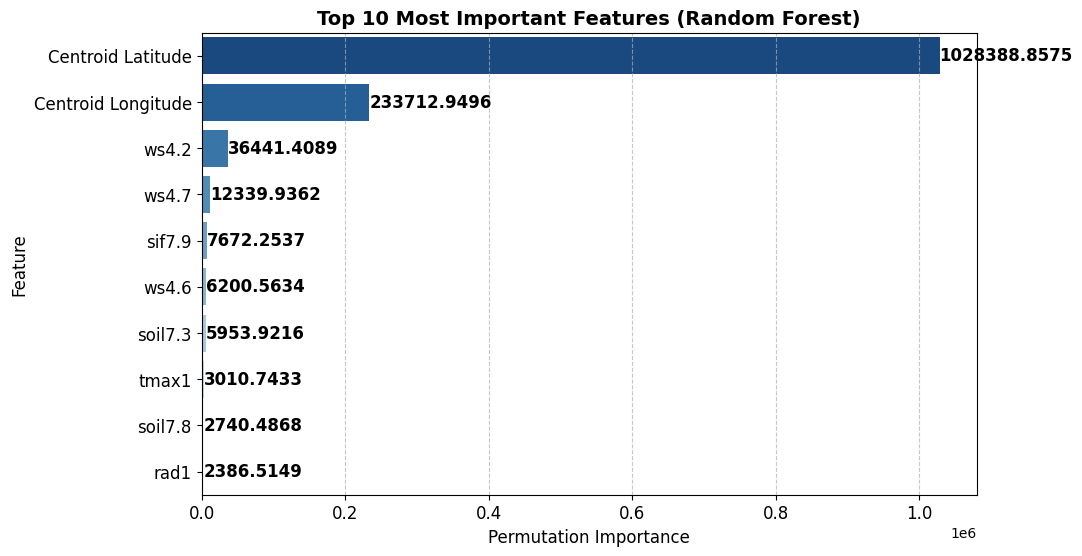

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the top 10 most important features
top_10_features = feature_importance_df.head(10)

# Define a color palette (blue shades for readability)
colors = sns.color_palette("Blues_r", len(top_10_features))

# Plot Bar Chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top_10_features,
    x="Importance",
    y="Feature",
    palette=colors
)

# Annotate each bar with its importance value
for p in ax.patches:
    ax.annotate(
        f"{p.get_width():.4f}",  # Format importance value
        (p.get_width(), p.get_y() + p.get_height() / 2),
        ha="left", va="center",
        fontsize=12, fontweight="bold", color="black"
    )

# Set labels and title
plt.title("Top 10 Most Important Features (Random Forest)", fontsize=14, fontweight="bold")
plt.xlabel("Permutation Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [ ]:
import re

# Define feature categories
climate_soil_features = ["pcp", "PET", "rh", "rad", "tmax", "tmin", "vpd", "ws", "soil"]
remote_sensing_features = ["evi", "ndvi", "sif"]
indices_features = ["heatstress", "spi", "sti"]

# Extract base feature names by removing numeric suffixes (e.g., "evi1.3" → "evi")
feature_importance_df["Base_Feature"] = feature_importance_df["Feature"].apply(lambda x: re.split(r'\d+', x)[0])

# Aggregate importance per category
category_importance = {
    "Climate + Soil": feature_importance_df[feature_importance_df["Base_Feature"].isin(climate_soil_features)]["Importance"].sum(),
    "Remote Sensing": feature_importance_df[feature_importance_df["Base_Feature"].isin(remote_sensing_features)]["Importance"].sum(),
    "Indices": feature_importance_df[feature_importance_df["Base_Feature"].isin(indices_features)]["Importance"].sum(),
}

# Convert to DataFrame
category_importance_df = pd.DataFrame(list(category_importance.items()), columns=["Category", "Total Importance"])

# Normalize percentages to ensure they sum to 100%
category_importance_df["Percentage Contribution"] = (category_importance_df["Total Importance"] / category_importance_df["Total Importance"].sum()) * 100

# Print category-wise contributions
print("\n=== Feature Contribution by Category (Random Forest) ===")
print(category_importance_df)



=== Feature Contribution by Category (Random Forest) ===
         Category  Total Importance  Percentage Contribution
0  Climate + Soil     189866.396344                73.573769
1  Remote Sensing      40591.733802                15.729412
2         Indices      27604.490392                10.696819


<ipython-input-7-43b4b4dffe86>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


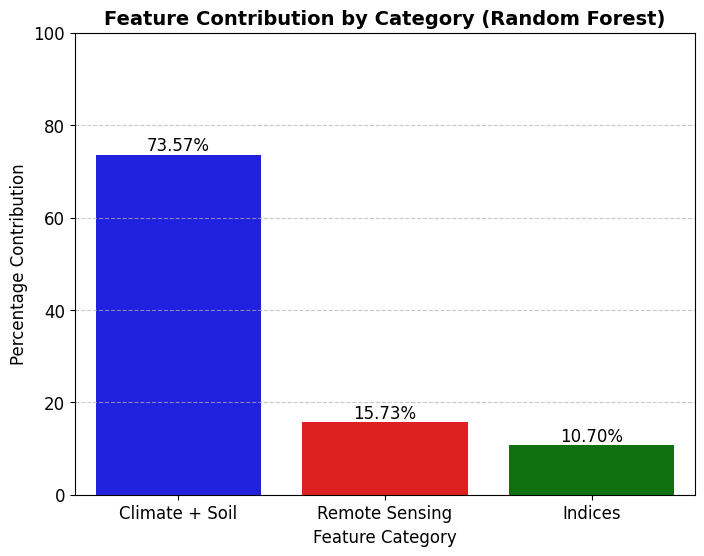

In [ ]:
# Define a color palette for better visualization
colors = ['blue', 'red', 'green']  # Blue, Red, Green

# Plot Bar Chart (Swapped Axes)
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=category_importance_df,
    x="Category",
    y="Percentage Contribution",
    palette=colors
)

# Annotate each bar with its contribution value
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2f}%",  # Format as percentage
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center", va="bottom",
        fontsize=12,  color="black"
    )

# Set labels and title
plt.title("Feature Contribution by Category (Random Forest)", fontsize=14, fontweight="bold")
plt.xlabel("Feature Category", fontsize=12)
plt.ylabel("Percentage Contribution", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 100)  # Ensure it represents 100%
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


# XGBRegressor

In [ ]:
!pip install scikit-learn==1.5.2

In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint, uniform
from scipy.stats import randint, uniform

# Set seed for full reproducibility
np.random.seed(42)

# Load Dataset
df = pd.read_csv("/content/stage_4_all_data_without_ma.csv")

# Define Features & Target
features = df.drop(['Actual', 'District', 'Trend', 'Detrended_Yield'], axis=1)
target = df['Detrended_Yield']
trend = df['Trend']
df['Predicted_detrend'] = np.nan  # Placeholder for predictions
groups = df['Year']
# Function for Consecutive GroupKFold Splits
def consecutive_group_kfold(df, n_splits=5):
    unique_years = sorted(df['Year'].unique())
    year_groups = np.array_split(unique_years, n_splits)

    for i in range(n_splits):
        test_years = year_groups[i]
        train_years = list(set(unique_years) - set(test_years))
        train_data = df[df['Year'].isin(train_years)]
        test_data = df[df['Year'].isin(test_years)]
        yield train_data, test_data

# Define Pipeline for Hyperparameter Tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Define Hyperparameter Search Space
param_dist = {
    'xgb__n_estimators': randint(30, 400),          # Number of boosting rounds
    'xgb__max_depth': randint(1, 8),               # Tree depth
    'xgb__learning_rate': uniform(0.01, 0.3),       # Learning rate
    'xgb__subsample': uniform(0.5, 0.5),            # Subsample ratio
    'xgb__colsample_bytree': uniform(0.5, 0.5),     # Feature sampling per tree
    'xgb__reg_alpha': uniform(0, 10),               # L1 regularization
    'xgb__reg_lambda': uniform(500, 2000)           # L2 regularization
}
# Initialize GroupKFold
n_splits = 10
group_kfold = GroupKFold(n_splits=n_splits)
# Perform Hyperparameter Tuning using a Full Training Dataset
full_X, full_y = features, target
search = RandomizedSearchCV(
    pipeline, param_distributions=param_dist,
    n_iter=2, cv=group_kfold, scoring='neg_mean_squared_error',
    n_jobs=-1, random_state=320, verbose=1
)
search.fit(full_X, full_y, groups=groups)

# Extract Best Parameters
best_params = search.best_params_
print("\n=== Best Hyperparameters Found ===")
print(best_params)

# Update Pipeline with Best Parameters
best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_estimators=best_params['xgb__n_estimators'],
        max_depth=best_params['xgb__max_depth'],
        learning_rate=best_params['xgb__learning_rate'],
        subsample=best_params['xgb__subsample'],
        colsample_bytree=best_params['xgb__colsample_bytree'],
        reg_alpha=best_params['xgb__reg_alpha'],
        reg_lambda=best_params['xgb__reg_lambda']
    ))
])

# Initialize Scores
train_rmse_list, test_rmse_list, train_r2_list, test_r2_list = [], [], [], []

# Cross-Validation Loop
for fold, (train_data, test_data) in enumerate(consecutive_group_kfold(df, n_splits=10), 1):
    print(f"\n=== Fold {fold} ===")
    train_years = sorted(train_data['Year'].unique())
    test_years = sorted(test_data['Year'].unique())
    print(f"Training Years: {train_years}")
    print(f"Testing Years: {test_years}")

    # Extract Features & Target
    X_train, y_train_detrend = train_data[features.columns], train_data[target.name]
    X_test, y_test_detrend = test_data[features.columns], test_data[target.name]
    trend_train, trend_test = train_data['Trend'], test_data['Trend']

    # Train Best Model
    best_model.fit(X_train, y_train_detrend)

    # Predict on Train & Test
    y_train_pred_detrend = best_model.predict(X_train)
    y_test_pred_detrend = best_model.predict(X_test)

    # Convert Back to Actual Yield
    y_train_actual = y_train_detrend + trend_train
    y_test_actual = y_test_detrend + trend_test
    y_train_pred = y_train_pred_detrend + trend_train
    y_test_pred = y_test_pred_detrend + trend_test

    # Compute Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
    train_r2 = r2_score(y_train_actual, y_train_pred)
    test_r2 = r2_score(y_test_actual, y_test_pred)

    # Store Results
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)

    # Save Predictions in DataFrame
    df.loc[test_data.index, 'Predicted_detrend'] = y_test_pred_detrend
    df.loc[test_data.index, 'Predicted'] = y_test_pred

    # Print Fold Results
    print(f"Train RMSE: {train_rmse:.2f}, Train R²: {train_r2:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}, Test R²: {test_r2:.2f}")

# Compute Overall Averages
avg_train_rmse = np.mean(train_rmse_list)
avg_test_rmse = np.mean(test_rmse_list)
avg_train_r2 = np.mean(train_r2_list)
avg_test_r2 = np.mean(test_r2_list)

print("\n=== Final Results ===")
print(f"Average Training RMSE: {avg_train_rmse:.2f}")
print(f"Average Training R²: {avg_train_r2:.2f}")
print(f"Average Testing RMSE: {avg_test_rmse:.2f}")
print(f"Average Testing R²: {avg_test_r2:.2f}")

# Calculate Yearly RMSE and R²
yearly_metrics = df.groupby('Year').apply(
    lambda x: pd.Series({
        'RMSE': np.sqrt(mean_squared_error(x['Actual'], x['Predicted'])),
        'R2_Score': r2_score(x['Actual'], x['Predicted'])
    })
).reset_index()

# Average Yearly Metrics
avg_yearly_rmse = yearly_metrics['RMSE'].mean()
avg_yearly_r2_score = yearly_metrics['R2_Score'].mean()

print(f"Average Yearly RMSE: {avg_yearly_rmse:.2f}")
print(f"Average Yearly R² Score: {avg_yearly_r2_score:.2f}")


Fitting 10 folds for each of 2 candidates, totalling 20 fits

=== Best Hyperparameters Found ===
{'xgb__colsample_bytree': 0.8571769927074147, 'xgb__learning_rate': 0.08678998140083036, 'xgb__max_depth': 6, 'xgb__n_estimators': 299, 'xgb__reg_alpha': 4.006918351439975, 'xgb__reg_lambda': 1916.8237062298554, 'xgb__subsample': 0.8113983936197855}

=== Fold 1 ===
Training Years: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2004, 2005]
Train RMSE: 363.43, Train R²: 0.86
Test RMSE: 462.41, Test R²: 0.75

=== Fold 2 ===
Training Years: [2004, 2005, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2006, 2007]
Train RMSE: 360.46, Train R²: 0.86
Test RMSE: 514.42, Test R²: 0.72

=== Fold 3 ===
Training Years: [2004, 2005, 2006, 2007, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2008, 2009]
Train RMSE: 364.69, Train R²: 0.86
Test RMSE: 491.85, Test R²: 0.72

=== Fold 4 ===
Training Years: [2004, 2005, 2006,

<ipython-input-8-21d6c35f1f88>:146: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_metrics = df.groupby('Year').apply(


```
stage_4_cp_idx_data.csv
seed = 42
Average Yearly RMSE: 507.24
Average Yearly R² Score: 0.67
seed 4
Average Yearly RMSE: 545.59
Average Yearly R² Score: 0.63
seed 1024
Average Yearly RMSE: 525.61
Average Yearly R² Score: 0.65
```

```
stage_4_rs_static_data.csv
seed - 1024
Average Yearly RMSE: 525.09
Average Yearly R² Score: 0.65
seed 4
Average Yearly RMSE: 553.23
Average Yearly R² Score: 0.61
seed - 47
Average Yearly RMSE: 557.77
Average Yearly R² Score: 0.61
```



```
seed 47
stage_4_all_data_without_ma.csv
Average Yearly RMSE: 559.61
Average Yearly R² Score: 0.61
seed 4
Average Yearly RMSE: 549.11
Average Yearly R² Score: 0.62
seed 1024
Average Yearly RMSE: 523.01
Average Yearly R² Score: 0.65
seed 720
Average Yearly RMSE: 513.71
Average Yearly R² Score: 0.66
seed 320
Average Yearly RMSE: 542.11
Average Yearly R² Score: 0.63

```

In [ ]:
best_params

In [ ]:
#=== Best Hyperparameters Found ===
best_params ={'xgb__colsample_bytree': 0.9290418060840998,
 'xgb__learning_rate': 0.16985284373248053,
 'xgb__max_depth': 4,
 'xgb__n_estimators': 390,
 'xgb__reg_alpha': 7.508884729488528,
 'xgb__reg_lambda': 999.4115790271003,
 'xgb__subsample': 0.609993861334124}

In [ ]:
{'colsample_bytree': 0.9835149195068383, 'learning_rate': 0.1741696747527167, 'max_depth': 4, 'n_estimators': 390, 'reg_alpha': 7.148159936743647, 'reg_lambda': 997.7288245972708, 'subsample': 0.6080447477901882}

In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint, uniform
from scipy.stats import randint, uniform

# Set seed for full reproducibility
np.random.seed(4)

# Load Dataset
df = pd.read_csv("stage_4_all_data_without_ma.csv")

# Define Features & Target
features = df.drop(['Actual', 'District', 'Trend', 'Detrended_Yield'], axis=1)
target = df['Detrended_Yield']
trend = df['Trend']
df['Predicted_detrend'] = np.nan  # Placeholder for predictions
groups = df['Year']
# Function for Consecutive GroupKFold Splits
def consecutive_group_kfold(df, n_splits=5):
    unique_years = sorted(df['Year'].unique())
    year_groups = np.array_split(unique_years, n_splits)

    for i in range(n_splits):
        test_years = year_groups[i]
        train_years = list(set(unique_years) - set(test_years))
        train_data = df[df['Year'].isin(train_years)]
        test_data = df[df['Year'].isin(test_years)]
        yield train_data, test_data

# Define Pipeline for Hyperparameter Tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))
])

#=== Best Hyperparameters Found ===
best_params ={'xgb__colsample_bytree': 0.9290418060840998,
 'xgb__learning_rate': 0.16985284373248053,
 'xgb__max_depth': 4,
 'xgb__n_estimators': 390,
 'xgb__reg_alpha': 7.508884729488528,
 'xgb__reg_lambda': 1999.4115790271003,
 'xgb__subsample': 0.609993861334124}

# Update Pipeline with Best Parameters
best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_estimators=best_params['xgb__n_estimators'],
        max_depth=best_params['xgb__max_depth'],
        learning_rate=best_params['xgb__learning_rate'],
        subsample=best_params['xgb__subsample'],
        colsample_bytree=best_params['xgb__colsample_bytree'],
        reg_alpha=best_params['xgb__reg_alpha'],
        reg_lambda=best_params['xgb__reg_lambda']
    ))
])

# Initialize Scores
train_rmse_list, test_rmse_list, train_r2_list, test_r2_list = [], [], [], []

# Cross-Validation Loop
for fold, (train_data, test_data) in enumerate(consecutive_group_kfold(df, n_splits=10), 1):
    print(f"\n=== Fold {fold} ===")
    train_years = sorted(train_data['Year'].unique())
    test_years = sorted(test_data['Year'].unique())
    print(f"Training Years: {train_years}")
    print(f"Testing Years: {test_years}")

    # Extract Features & Target
    X_train, y_train_detrend = train_data[features.columns], train_data[target.name]
    X_test, y_test_detrend = test_data[features.columns], test_data[target.name]
    trend_train, trend_test = train_data['Trend'], test_data['Trend']

    # Train Best Model
    best_model.fit(X_train, y_train_detrend)

    # Predict on Train & Test
    y_train_pred_detrend = best_model.predict(X_train)
    y_test_pred_detrend = best_model.predict(X_test)

    # Convert Back to Actual Yield
    y_train_actual = y_train_detrend + trend_train
    y_test_actual = y_test_detrend + trend_test
    y_train_pred = y_train_pred_detrend + trend_train
    y_test_pred = y_test_pred_detrend + trend_test

    # Compute Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
    train_r2 = r2_score(y_train_actual, y_train_pred)
    test_r2 = r2_score(y_test_actual, y_test_pred)

    # Store Results
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)

    # Save Predictions in DataFrame
    df.loc[test_data.index, 'Predicted_detrend'] = y_test_pred_detrend
    df.loc[test_data.index, 'Predicted'] = y_test_pred

    # Print Fold Results
    print(f"Train RMSE: {train_rmse:.2f}, Train R²: {train_r2:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}, Test R²: {test_r2:.2f}")

# Compute Overall Averages
avg_train_rmse = np.mean(train_rmse_list)
avg_test_rmse = np.mean(test_rmse_list)
avg_train_r2 = np.mean(train_r2_list)
avg_test_r2 = np.mean(test_r2_list)

print("\n=== Final Results ===")
print(f"Average Training RMSE: {avg_train_rmse:.2f}")
print(f"Average Training R²: {avg_train_r2:.2f}")
print(f"Average Testing RMSE: {avg_test_rmse:.2f}")
print(f"Average Testing R²: {avg_test_r2:.2f}")

# Calculate Yearly RMSE and R²
yearly_metrics = df.groupby('Year').apply(
    lambda x: pd.Series({
        'RMSE': np.sqrt(mean_squared_error(x['Actual'], x['Predicted'])),
        'R2_Score': r2_score(x['Actual'], x['Predicted'])
    })
).reset_index()

# Average Yearly Metrics
avg_yearly_rmse = yearly_metrics['RMSE'].mean()
avg_yearly_r2_score = yearly_metrics['R2_Score'].mean()

print(f"Average Yearly RMSE: {avg_yearly_rmse:.2f}")
print(f"Average Yearly R² Score: {avg_yearly_r2_score:.2f}")



=== Fold 1 ===
Training Years: [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2004, 2005]
Train RMSE: 310.33, Train R²: 0.90
Test RMSE: 436.68, Test R²: 0.78

=== Fold 2 ===
Training Years: [2004, 2005, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2006, 2007]
Train RMSE: 307.24, Train R²: 0.90
Test RMSE: 478.20, Test R²: 0.76

=== Fold 3 ===
Training Years: [2004, 2005, 2006, 2007, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2008, 2009]
Train RMSE: 310.64, Train R²: 0.90
Test RMSE: 471.87, Test R²: 0.74

=== Fold 4 ===
Training Years: [2004, 2005, 2006, 2007, 2008, 2009, 2012, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2010, 2011]
Train RMSE: 288.55, Train R²: 0.91
Test RMSE: 661.11, Test R²: 0.59

=== Fold 5 ===
Training Years: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2012]
Train RMSE: 300.08, Train R²: 0.91
Test RMSE: 528.05, Test R²: 

<ipython-input-17-3e0d5f83c651>:128: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_metrics = df.groupby('Year').apply(


```
=== Final Results ===
Average Training RMSE: 302.67
Average Training R²: 0.91
Average Testing RMSE: 525.68
Average Testing R²: 0.63
Average Yearly RMSE: 520.39
Average Yearly R² Score: 0.65

=== Final Results ===
Average Training RMSE: 220.41
Average Training R²: 0.95
Average Testing RMSE: 545.90
Average Testing R²: 0.63
Average Yearly RMSE: 535.70
Average Yearly R² Score: 0.62
```

Fitting 5 folds for each of 10 candidates, totalling 50 fits

=== Best Hyperparameters Found ===
{'xgb__colsample_bytree': 0.8188051220629968, 'xgb__learning_rate': 0.13044863307708188, 'xgb__max_depth': 7, 'xgb__n_estimators': 361, 'xgb__reg_alpha': 3.9690000290173266, 'xgb__reg_lambda': 1747.832227096446, 'xgb__subsample': 0.883702483545062}

=== Fold 1 ===
Training Years: [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2004, 2005, 2006]
Train RMSE: 236.52, Train R²: 0.94
Test RMSE: 438.39, Test R²: 0.78

=== Fold 2 ===
Training Years: [2004, 2005, 2006, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2007, 2008, 2009]
Train RMSE: 235.05, Train R²: 0.94
Test RMSE: 509.42, Test R²: 0.72

=== Fold 3 ===
Training Years: [2004, 2005, 2006, 2007, 2008, 2009, 2013, 2014, 2015, 2016, 2017]
Testing Years: [2010, 2011, 2012]
Train RMSE: 212.90, Train R²: 0.95
Test RMSE: 636.02, Test R²: 0.56

=== Fold 4 ===
Training Years: [2004, 2005, 2006, 

<ipython-input-16-a7dbc6730b18>:153: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_metrics = df.groupby('Year').apply(
 98%|===================| 1756/1792 [00:42<00:00]       

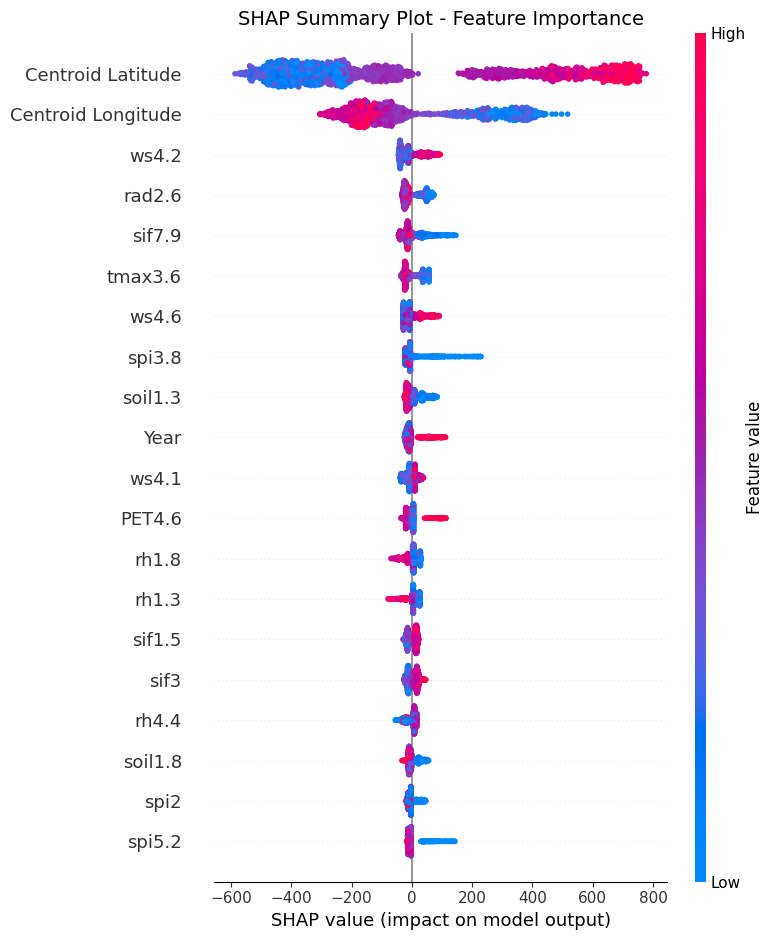

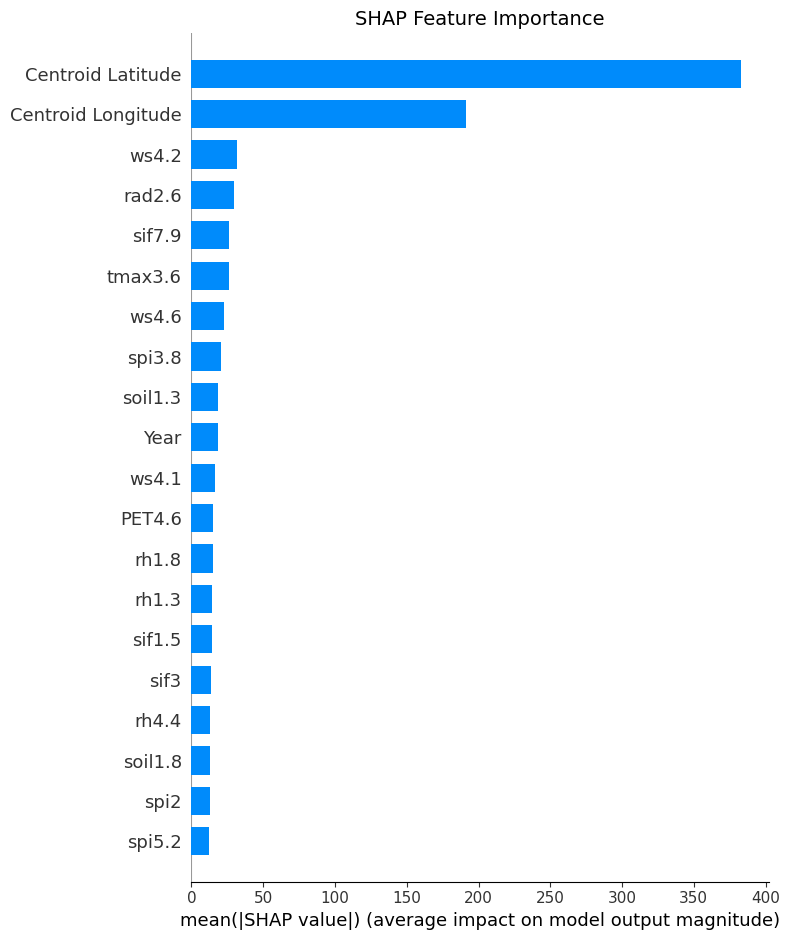

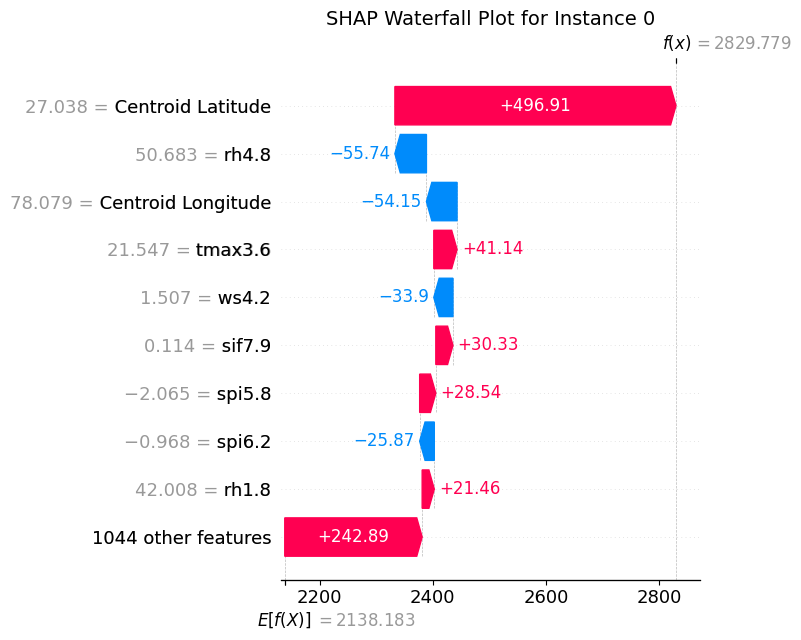

In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint, uniform
import shap
import matplotlib.pyplot as plt
from IPython.display import display

# Initialize SHAP JavaScript for interactive plots
shap.initjs()

# Set seed for reproducibility
np.random.seed(4)

# Load Dataset
df = pd.read_csv("/content/stage_4_all_data_without_ma.csv")

# Define Features & Target
features = df.drop(['Actual', 'District', 'Trend', 'Detrended_Yield'], axis=1)
target = df['Detrended_Yield']
trend = df['Trend']
df['Predicted_detrend'] = np.nan  # Placeholder for predictions
groups = df['Year']

# Function for Consecutive GroupKFold Splits
def consecutive_group_kfold(df, n_splits=5):
    unique_years = sorted(df['Year'].unique())
    year_groups = np.array_split(unique_years, n_splits)
    for i in range(n_splits):
        test_years = year_groups[i]
        train_years = list(set(unique_years) - set(test_years))
        train_data = df[df['Year'].isin(train_years)]
        test_data = df[df['Year'].isin(test_years)]
        yield train_data, test_data

# Define Pipeline for Hyperparameter Tuning
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(random_state=42, n_jobs=-1))
])

# Define Hyperparameter Search Space
param_dist = {
    'xgb__n_estimators': randint(30, 400),          # Number of boosting rounds
    'xgb__max_depth': randint(1, 8),               # Tree depth
    'xgb__learning_rate': uniform(0.01, 0.3),       # Learning rate
    'xgb__subsample': uniform(0.5, 0.5),            # Subsample ratio
    'xgb__colsample_bytree': uniform(0.5, 0.5),     # Feature sampling per tree
    'xgb__reg_alpha': uniform(0, 10),               # L1 regularization
    'xgb__reg_lambda': uniform(500, 2000)           # L2 regularization
}

# Initialize GroupKFold for Hyperparameter Tuning
n_splits = 5
group_kfold = GroupKFold(n_splits=n_splits)

# Perform Hyperparameter Tuning using the Full Dataset
full_X, full_y = features, target
search = RandomizedSearchCV(
    pipeline, param_distributions=param_dist,
    n_iter=10, cv=group_kfold, scoring='neg_mean_squared_error',
    n_jobs=-1, random_state=4, verbose=1
)
search.fit(full_X, full_y, groups=groups)

# Extract Best Parameters
best_params = search.best_params_
print("\n=== Best Hyperparameters Found ===")
print(best_params)

# Update Pipeline with Best Parameters
best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(
        random_state=42,
        n_jobs=-1,
        n_estimators=best_params['xgb__n_estimators'],
        max_depth=best_params['xgb__max_depth'],
        learning_rate=best_params['xgb__learning_rate'],
        subsample=best_params['xgb__subsample'],
        colsample_bytree=best_params['xgb__colsample_bytree'],
        reg_alpha=best_params['xgb__reg_alpha'],
        reg_lambda=best_params['xgb__reg_lambda']
    ))
])

# Initialize Scores
train_rmse_list, test_rmse_list, train_r2_list, test_r2_list = [], [], [], []

# Cross-Validation Loop
for fold, (train_data, test_data) in enumerate(consecutive_group_kfold(df, n_splits=5), 1):
    print(f"\n=== Fold {fold} ===")
    train_years = sorted(train_data['Year'].unique())
    test_years = sorted(test_data['Year'].unique())
    print(f"Training Years: {train_years}")
    print(f"Testing Years: {test_years}")

    # Extract Features & Target
    X_train, y_train_detrend = train_data[features.columns], train_data[target.name]
    X_test, y_test_detrend = test_data[features.columns], test_data[target.name]
    trend_train, trend_test = train_data['Trend'], test_data['Trend']

    # Train Best Model
    best_model.fit(X_train, y_train_detrend)

    # Predict on Train & Test
    y_train_pred_detrend = best_model.predict(X_train)
    y_test_pred_detrend = best_model.predict(X_test)

    # Convert Back to Actual Yield
    y_train_actual = y_train_detrend + trend_train
    y_test_actual = y_test_detrend + trend_test
    y_train_pred = y_train_pred_detrend + trend_train
    y_test_pred = y_test_pred_detrend + trend_test

    # Compute Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
    train_r2 = r2_score(y_train_actual, y_train_pred)
    test_r2 = r2_score(y_test_actual, y_test_pred)

    # Store Results
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)

    # Save Predictions in DataFrame
    df.loc[test_data.index, 'Predicted_detrend'] = y_test_pred_detrend
    df.loc[test_data.index, 'Predicted'] = y_test_pred

    # Print Fold Results
    print(f"Train RMSE: {train_rmse:.2f}, Train R²: {train_r2:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}, Test R²: {test_r2:.2f}")

# Compute Overall Averages
avg_train_rmse = np.mean(train_rmse_list)
avg_test_rmse = np.mean(test_rmse_list)
avg_train_r2 = np.mean(train_r2_list)
avg_test_r2 = np.mean(test_r2_list)

print("\n=== Final Results ===")
print(f"Average Training RMSE: {avg_train_rmse:.2f}")
print(f"Average Training R²: {avg_train_r2:.2f}")
print(f"Average Testing RMSE: {avg_test_rmse:.2f}")
print(f"Average Testing R²: {avg_test_r2:.2f}")

# Calculate Yearly RMSE and R²
yearly_metrics = df.groupby('Year').apply(
    lambda x: pd.Series({
        'RMSE': np.sqrt(mean_squared_error(x['Actual'], x['Predicted'])),
        'R2_Score': r2_score(x['Actual'], x['Predicted'])
    })
).reset_index()

# Average Yearly Metrics
avg_yearly_rmse = yearly_metrics['RMSE'].mean()
avg_yearly_r2_score = yearly_metrics['R2_Score'].mean()

print(f"Average Yearly RMSE: {avg_yearly_rmse:.2f}")
print(f"Average Yearly R² Score: {avg_yearly_r2_score:.2f}")

# --- SHAP Analysis ---
# Train the best model on the full dataset for SHAP analysis
best_model.fit(full_X, full_y)

# Create a SHAP explainer for the XGBoost model
explainer = shap.TreeExplainer(best_model.named_steps['xgb'],
                               best_model.named_steps['scaler'].transform(full_X))

# Calculate SHAP values for the full dataset
shap_values = explainer.shap_values(best_model.named_steps['scaler'].transform(full_X))

# Summary Plot - Feature Importance (Beeswarm Plot)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, full_X, show=False)
plt.title("SHAP Summary Plot - Feature Importance", fontsize=14)
plt.tight_layout()
plt.show()

# SHAP Feature Importance (Bar Plot with Mean Absolute SHAP Values)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, full_X, plot_type="bar", show=False)
plt.title("SHAP Feature Importance", fontsize=14)
plt.tight_layout()
plt.show()

# SHAP Waterfall Plot for a Single Instance (e.g., first instance)
instance_idx = 0
X_instance = full_X.iloc[[instance_idx]]
scaled_instance = best_model.named_steps['scaler'].transform(X_instance)
shap_values_instance = explainer.shap_values(scaled_instance)[0]

# Create an Explanation object with feature names
explanation = shap.Explanation(values=shap_values_instance,
                              base_values=explainer.expected_value,
                              data=X_instance.values[0],
                              feature_names=full_X.columns)

plt.figure(figsize=(10, 6))
shap.waterfall_plot(explanation, show=False)
plt.title(f"SHAP Waterfall Plot for Instance {instance_idx}", fontsize=14)
plt.tight_layout()
plt.show()

### XGB using permutaion_imp

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

# Compute Permutation Feature Importance
pfi_results = permutation_importance(
    best_model, features, target, scoring='neg_mean_squared_error',
    n_repeats=10, random_state=42, n_jobs=-1
)

# Convert to DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance': pfi_results.importances_mean,
    'Std_Dev': pfi_results.importances_std
}).sort_values(by='Importance', ascending=False)

# Save to CSV
feature_importance_df.to_csv("xgb_permutation_feature_importance.csv", index=False)

# Print Results
print("\n=== Permutation Feature Importance ===")
print(feature_importance_df.head(10))  # Show top 10



=== Permutation Feature Importance ===
                 Feature     Importance       Std_Dev
1051   Centroid Latitude  638982.644852  17438.275882
1050  Centroid Longitude  157090.355277   4163.840921
226               rad2.6   14318.516188   1146.899496
983              soil1.3    8411.866655    617.160858
769               sif7.9    8062.011760    680.870506
522                ws4.2    3688.423203    667.290441
174                rh4.4    3583.243801    266.992818
526                ws4.6    3434.828342    801.491398
708               sif1.8    3399.273204    366.503655
106               PET4.6    3382.764103    441.992993


<ipython-input-1-a618ee7e0ff1>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


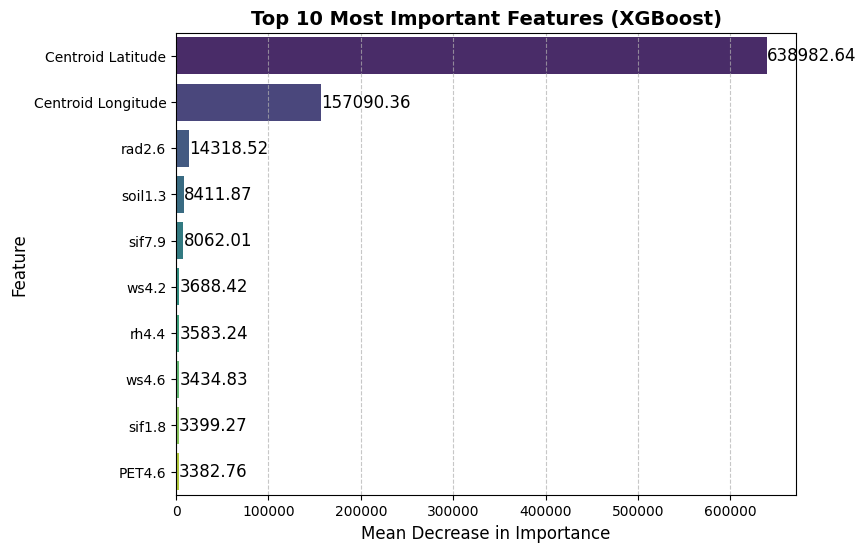

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re

feature_importance_df = pd.read_csv('/content/xgb_permutation_feature_importance (1).csv')
# Select Top 10 Features
top_10_features = feature_importance_df.head(10)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(
    data=top_10_features,
    x="Importance",
    y="Feature",
    palette="viridis"
)

# Annotate Values
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_width():.2f}",
                       (p.get_width(), p.get_y() + p.get_height()/2),
                       ha='left', va='center', fontsize=12, color='black')

# Labels & Title
plt.xlabel("Mean Decrease in Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Top 10 Most Important Features (XGBoost)", fontsize=14, fontweight="bold")
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show Plot
plt.show()


<ipython-input-2-59e91dfbc082>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


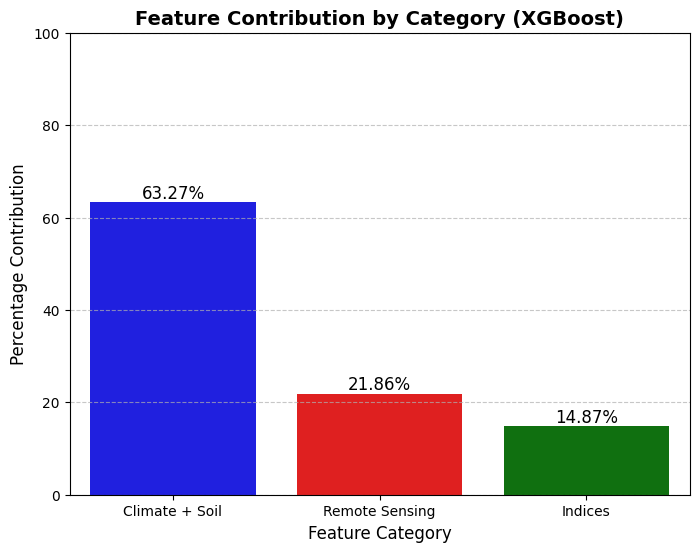

In [ ]:
# Define Feature Categories
climate_soil_features = ["pcp", "PET", "rh", "rad", "tmax", "tmin", "vpd", "ws", "soil"]
remote_sensing_features = ["evi", "ndvi", "sif"]
indices_features = ["heatstress", "spi", "sti"]

# Extract Base Feature Names
feature_importance_df["Base_Feature"] = feature_importance_df["Feature"].str.extract(r'([a-zA-Z_]+)')

# Compute Mean Importance for Each Category
category_importance = {
    "Climate + Soil": feature_importance_df[feature_importance_df["Base_Feature"].isin(climate_soil_features)]["Importance"].sum(),
    "Remote Sensing": feature_importance_df[feature_importance_df["Base_Feature"].isin(remote_sensing_features)]["Importance"].sum(),
    "Indices": feature_importance_df[feature_importance_df["Base_Feature"].isin(indices_features)]["Importance"].sum(),
}

# Convert to DataFrame
category_importance_df = pd.DataFrame(list(category_importance.items()), columns=["Category", "Total Importance"])

# Normalize to Percentage
category_importance_df["Percentage Contribution"] = (category_importance_df["Total Importance"] /
                                                     category_importance_df["Total Importance"].sum()) * 100

# Plot Category Contribution
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=category_importance_df,
    x="Category",
    y="Percentage Contribution",
    palette=['blue', 'red', 'green']
)

# Annotate each bar
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}%",
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha="center", va="bottom", fontsize=12, color="black")

# Labels & Title
plt.title("Feature Contribution by Category (XGBoost)", fontsize=14, fontweight="bold")
plt.xlabel("Feature Category", fontsize=12)
plt.ylabel("Percentage Contribution", fontsize=12)
plt.ylim(0, 100)  # Ensure it represents 100%
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show Plot
plt.show()


# GAT - LSTM

## GAT Among Districts


Fold 1/7 - Test Years: [np.int64(2004), np.int64(2005)]
Fold 1 Epoch [1/25] - Train Loss: 6512086.2083, Test Loss: 6356535.5000, Train RMSE: 2551.8790, Test RMSE: 2521.2171, Train R²: -5.9247, Test R²: -6.3368
Fold 1 Epoch [2/25] - Train Loss: 6452279.9167, Test Loss: 6196047.7500, Train RMSE: 2540.1338, Test RMSE: 2489.1861, Train R²: -5.8612, Test R²: -6.1516
Fold 1 Epoch [3/25] - Train Loss: 5962816.6042, Test Loss: 5125297.2500, Train RMSE: 2441.8879, Test RMSE: 2263.9119, Train R²: -5.3407, Test R²: -4.9157
Fold 1 Epoch [4/25] - Train Loss: 4472462.3542, Test Loss: 3271656.2500, Train RMSE: 2114.8197, Test RMSE: 1808.7720, Train R²: -3.7559, Test R²: -2.7762
Fold 1 Epoch [5/25] - Train Loss: 2616030.1979, Test Loss: 1483597.2500, Train RMSE: 1617.4147, Test RMSE: 1218.0301, Train R²: -1.7818, Test R²: -0.7124
Fold 1 Epoch [6/25] - Train Loss: 1213595.3750, Test Loss: 606234.5000, Train RMSE: 1101.6330, Test RMSE: 778.6106, Train R²: -0.2905, Test R²: 0.3003
Fold 1 Epoch [7/25] - 

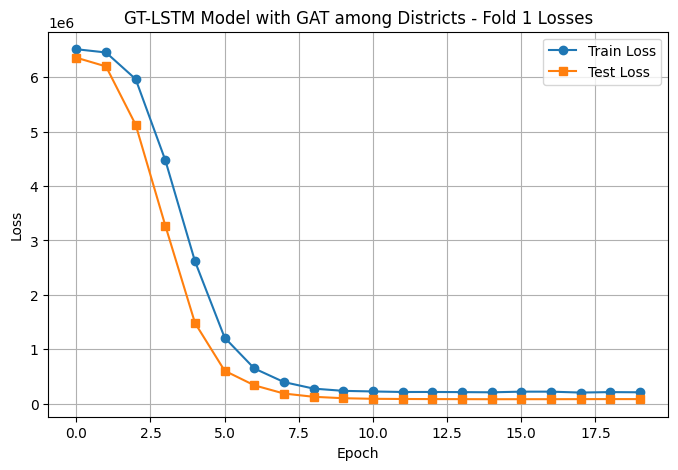


Fold 2/7 - Test Years: [np.int64(2006), np.int64(2007)]
Fold 2 Epoch [1/25] - Train Loss: 6464940.6250, Test Loss: 6635119.2500, Train RMSE: 2542.6247, Test RMSE: 2575.8726, Train R²: -5.7615, Test R²: -6.0059
Fold 2 Epoch [2/25] - Train Loss: 6401391.5417, Test Loss: 6463128.0000, Train RMSE: 2530.0972, Test RMSE: 2542.2683, Train R²: -5.6950, Test R²: -5.8243
Fold 2 Epoch [3/25] - Train Loss: 5925586.7500, Test Loss: 5486213.5000, Train RMSE: 2434.2528, Test RMSE: 2342.2668, Train R²: -5.1974, Test R²: -4.7928
Fold 2 Epoch [4/25] - Train Loss: 4610840.7292, Test Loss: 3798873.2500, Train RMSE: 2147.2868, Test RMSE: 1949.0699, Train R²: -3.8224, Test R²: -3.0112
Fold 2 Epoch [5/25] - Train Loss: 2918027.0208, Test Loss: 2050166.1250, Train RMSE: 1708.2233, Test RMSE: 1431.8402, Train R²: -2.0519, Test R²: -1.1647
Fold 2 Epoch [6/25] - Train Loss: 1485221.3802, Test Loss: 912871.0625, Train RMSE: 1218.6966, Test RMSE: 955.4428, Train R²: -0.5534, Test R²: 0.0361
Fold 2 Epoch [7/25] - 

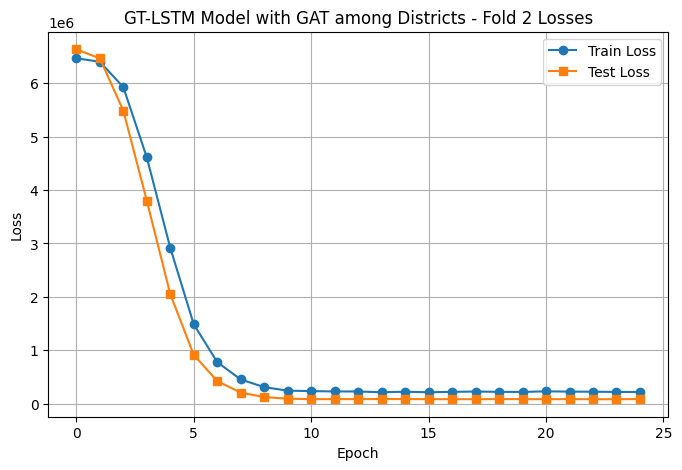


Fold 3/7 - Test Years: [np.int64(2008), np.int64(2009)]
Fold 3 Epoch [1/25] - Train Loss: 6525498.9792, Test Loss: 6264612.2500, Train RMSE: 2554.5057, Test RMSE: 2502.9208, Train R²: -5.6615, Test R²: -6.2670
Fold 3 Epoch [2/25] - Train Loss: 6455120.7083, Test Loss: 6086287.2500, Train RMSE: 2540.6929, Test RMSE: 2467.0402, Train R²: -5.5896, Test R²: -6.0601
Fold 3 Epoch [3/25] - Train Loss: 5924374.0000, Test Loss: 5046610.2500, Train RMSE: 2434.0037, Test RMSE: 2246.4662, Train R²: -5.0478, Test R²: -4.8541
Fold 3 Epoch [4/25] - Train Loss: 4514886.1875, Test Loss: 3341904.6250, Train RMSE: 2124.8262, Test RMSE: 1828.0877, Train R²: -3.6090, Test R²: -2.8766
Fold 3 Epoch [5/25] - Train Loss: 2741747.9167, Test Loss: 1644845.5000, Train RMSE: 1655.8225, Test RMSE: 1282.5153, Train R²: -1.7989, Test R²: -0.9080
Fold 3 Epoch [6/25] - Train Loss: 1354958.9531, Test Loss: 731134.1250, Train RMSE: 1164.0270, Test RMSE: 855.0638, Train R²: -0.3832, Test R²: 0.1519
Fold 3 Epoch [7/25] - 

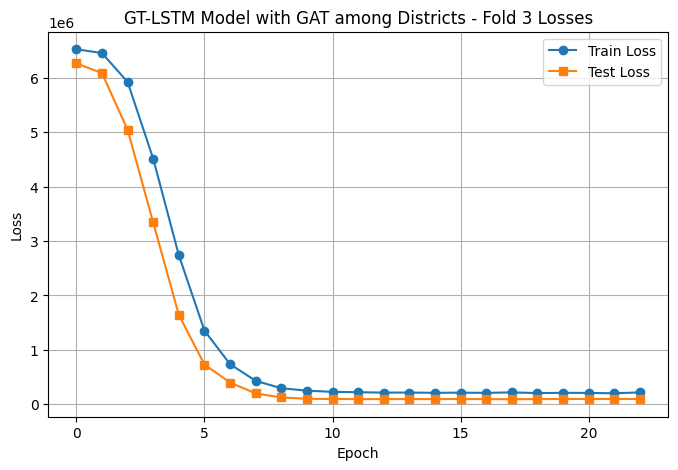


Fold 4/7 - Test Years: [np.int64(2010), np.int64(2011)]
Fold 4 Epoch [1/25] - Train Loss: 6311687.9583, Test Loss: 7533642.5000, Train RMSE: 2512.3073, Test RMSE: 2744.7481, Train R²: -5.6267, Test R²: -6.1495
Fold 4 Epoch [2/25] - Train Loss: 6237443.4792, Test Loss: 7314187.5000, Train RMSE: 2497.4875, Test RMSE: 2704.4755, Train R²: -5.5488, Test R²: -5.9412
Fold 4 Epoch [3/25] - Train Loss: 5619159.3542, Test Loss: 5916497.7500, Train RMSE: 2370.4766, Test RMSE: 2432.3851, Train R²: -4.8996, Test R²: -4.6148
Fold 4 Epoch [4/25] - Train Loss: 3957630.3125, Test Loss: 3813107.1250, Train RMSE: 1989.3794, Test RMSE: 1952.7179, Train R²: -3.1552, Test R²: -2.6187
Fold 4 Epoch [5/25] - Train Loss: 2342050.7083, Test Loss: 2179651.8750, Train RMSE: 1530.3760, Test RMSE: 1476.3644, Train R²: -1.4589, Test R²: -1.0685
Fold 4 Epoch [6/25] - Train Loss: 1298237.1198, Test Loss: 1125692.7188, Train RMSE: 1139.4021, Test RMSE: 1060.9867, Train R²: -0.3630, Test R²: -0.0683
Fold 4 Epoch [7/25]

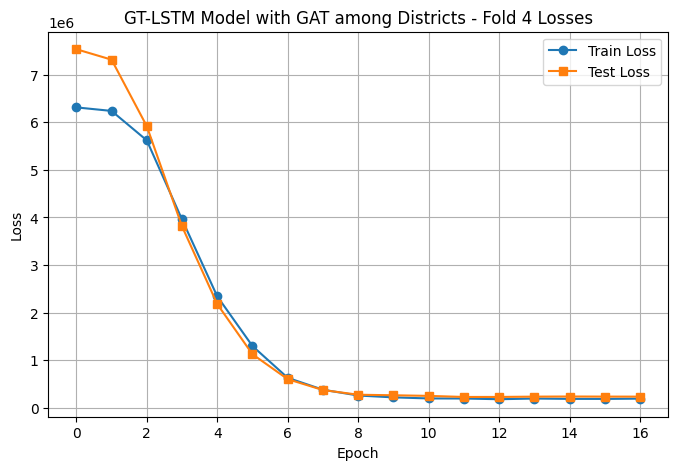


Fold 5/7 - Test Years: [np.int64(2012), np.int64(2013)]
Fold 5 Epoch [1/25] - Train Loss: 6387376.0833, Test Loss: 7059579.7500, Train RMSE: 2527.3259, Test RMSE: 2656.9871, Train R²: -5.4005, Test R²: -9.1906
Fold 5 Epoch [2/25] - Train Loss: 6297397.9792, Test Loss: 6789598.0000, Train RMSE: 2509.4617, Test RMSE: 2605.6857, Train R²: -5.3103, Test R²: -8.8008
Fold 5 Epoch [3/25] - Train Loss: 5590184.2500, Test Loss: 5318042.5000, Train RMSE: 2364.3570, Test RMSE: 2306.0881, Train R²: -4.6016, Test R²: -6.6766
Fold 5 Epoch [4/25] - Train Loss: 3878617.1458, Test Loss: 3174325.3750, Train RMSE: 1969.4205, Test RMSE: 1781.6636, Train R²: -2.8866, Test R²: -3.5822
Fold 5 Epoch [5/25] - Train Loss: 2059013.2969, Test Loss: 1429449.3750, Train RMSE: 1434.9262, Test RMSE: 1195.5958, Train R²: -1.0632, Test R²: -1.0634
Fold 5 Epoch [6/25] - Train Loss: 962705.7708, Test Loss: 582833.3281, Train RMSE: 981.1757, Test RMSE: 763.4352, Train R²: 0.0353, Test R²: 0.1587
Fold 5 Epoch [7/25] - Tra

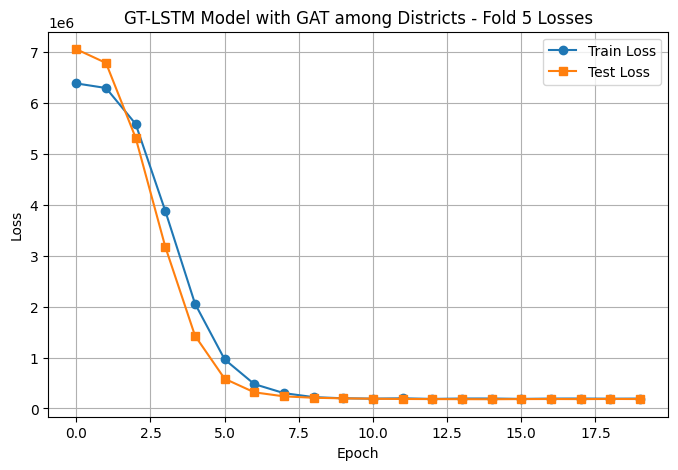


Fold 6/7 - Test Years: [np.int64(2014), np.int64(2015)]
Fold 6 Epoch [1/25] - Train Loss: 6816064.7083, Test Loss: 4556184.3750, Train RMSE: 2610.7594, Test RMSE: 2134.5221, Train R²: -5.8443, Test R²: -4.6153
Fold 6 Epoch [2/25] - Train Loss: 6763357.9583, Test Loss: 4448350.8750, Train RMSE: 2600.6457, Test RMSE: 2109.1114, Train R²: -5.7914, Test R²: -4.4824
Fold 6 Epoch [3/25] - Train Loss: 6341591.6667, Test Loss: 3735450.8750, Train RMSE: 2518.2517, Test RMSE: 1932.7315, Train R²: -5.3679, Test R²: -3.6038
Fold 6 Epoch [4/25] - Train Loss: 4985593.2500, Test Loss: 2433943.7500, Train RMSE: 2232.8442, Test RMSE: 1560.1101, Train R²: -4.0063, Test R²: -1.9997
Fold 6 Epoch [5/25] - Train Loss: 3125386.2708, Test Loss: 1304920.8750, Train RMSE: 1767.8762, Test RMSE: 1142.3313, Train R²: -2.1384, Test R²: -0.6082
Fold 6 Epoch [6/25] - Train Loss: 1563394.6042, Test Loss: 975901.4062, Train RMSE: 1250.3578, Test RMSE: 987.8772, Train R²: -0.5699, Test R²: -0.2027
Fold 6 Epoch [7/25] -

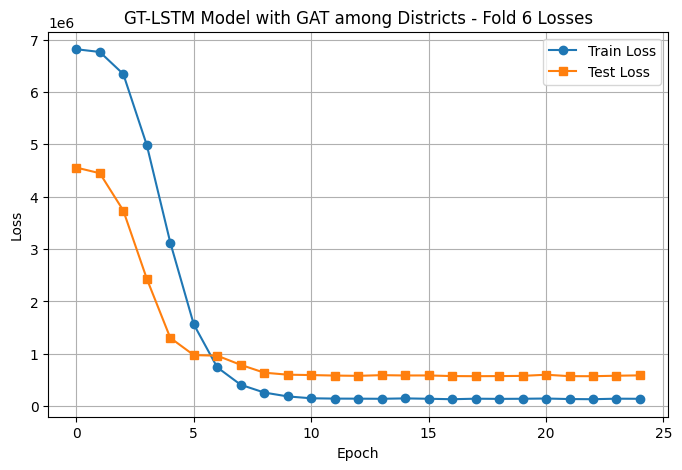


Fold 7/7 - Test Years: [np.int64(2016), np.int64(2017)]
Fold 7 Epoch [1/25] - Train Loss: 6418986.2917, Test Loss: 6906254.2500, Train RMSE: 2533.5718, Test RMSE: 2627.9754, Train R²: -5.7835, Test R²: -9.7786
Fold 7 Epoch [2/25] - Train Loss: 6367931.8542, Test Loss: 6762030.5000, Train RMSE: 2523.4761, Test RMSE: 2600.3904, Train R²: -5.7295, Test R²: -9.5536
Fold 7 Epoch [3/25] - Train Loss: 5943762.6875, Test Loss: 5764683.5000, Train RMSE: 2437.9833, Test RMSE: 2400.9755, Train R²: -5.2813, Test R²: -7.9970
Fold 7 Epoch [4/25] - Train Loss: 4605013.7917, Test Loss: 3911326.6250, Train RMSE: 2145.9296, Test RMSE: 1977.7074, Train R²: -3.8665, Test R²: -5.1044
Fold 7 Epoch [5/25] - Train Loss: 2814328.1979, Test Loss: 1951488.2500, Train RMSE: 1677.5960, Test RMSE: 1396.9568, Train R²: -1.9741, Test R²: -2.0457
Fold 7 Epoch [6/25] - Train Loss: 1363025.0781, Test Loss: 792972.4688, Train RMSE: 1167.4867, Test RMSE: 890.4900, Train R²: -0.4404, Test R²: -0.2376
Fold 7 Epoch [7/25] -

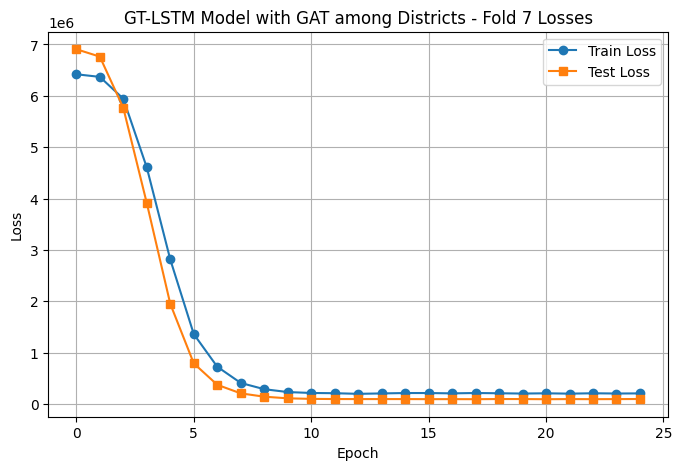


Overall Cross-Validation Metrics:
Average Train RMSE: 443.8321 (±29.7163)
Average Train R²: 0.7949 (±0.0283)
Average Test RMSE: 413.6860 (±160.1074)
Average Test R²: 0.7609 (±0.2078)
Cross-validation results saved to /content/gt_lstm_cv_yield_predictions_with_gat.csv


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from torch_geometric.nn import GATConv

# Set seeds for reproducibility
SEED = 8
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load district edge index
district_edge_index_df = pd.read_csv('/content/district_edge_index_nn3_haversine.csv')
district_edge_index = torch.tensor(district_edge_index_df.values, dtype=torch.long).t().contiguous()  # [2, num_edges]

# Climate Data
climate_data = pd.read_csv('/content/cp_soil_static_idx_7M_701grids_2004.csv')
climate_data_values = climate_data.values  # [9814, 84]
scaler_cp = StandardScaler()
climate_data_normalized = scaler_cp.fit_transform(climate_data_values)
climate_data_reshaped = climate_data_normalized.reshape(9814, 12, 7).transpose(0, 2, 1)  # [9814, 7, 12]
climate_data_tensor = torch.tensor(climate_data_reshaped, dtype=torch.float32).view(14, 701, 7, 12)  # [14, 701, 7, 12]

# Remote Sensing Data
rs_data = pd.read_csv('/content/rs_701_2004.csv')
rs_data_values = rs_data.values  # [9814, 21]
scaler_rs = StandardScaler()
rs_data_normalized = scaler_rs.fit_transform(rs_data_values)
rs_data_reshaped = rs_data_normalized.reshape(9814, 3, 7).transpose(0, 2, 1)  # [9814, 7, 3]
rs_data_tensor = torch.tensor(rs_data_reshaped, dtype=torch.float32).view(14, 701, 7, 3)  # [14, 701, 7, 3]

# Yield Data
yield_file_path = '/content/detrended_district_yearly_yield_6s_2004_128g.csv'
yield_data = pd.read_csv(yield_file_path)
district_names = yield_data['District'].unique()
district_name_to_index = {name: idx for idx, name in enumerate(district_names)}
yield_data['District'] = yield_data['District'].map(district_name_to_index)
yield_values = yield_data[['Year', 'Detrended_Yield', 'District', 'Trend', 'Actual']].values
years = yield_values[:, 0].astype(int)
detrended_yields = yield_values[:, 1]
districts = yield_values[:, 2].astype(int)
trends = yield_values[:, 3]
actual_yields = yield_values[:, 4]
district_mapping_df = pd.DataFrame(list(district_name_to_index.items()), columns=['District_Name', 'District_Index'])
district_mapping_df.to_csv('/content/district_name_to_index.csv', index=False)

num_districts = 128
num_years = 14
district_yields = np.zeros((num_districts, num_years))
trends_per_district = np.zeros((num_districts, num_years))
actual_yields_per_district = np.zeros((num_districts, num_years))
for i in range(len(years)):
    district_index = districts[i]
    year_index = years[i] - 2004
    district_yields[district_index, year_index] = detrended_yields[i]
    trends_per_district[district_index, year_index] = trends[i]
    actual_yields_per_district[district_index, year_index] = actual_yields[i]

district_yields_tensor = torch.tensor(district_yields, dtype=torch.float32)  # [128, 14]
trends_tensor = torch.tensor(trends_per_district, dtype=torch.float32)  # [128, 14]
actual_yields_tensor = torch.tensor(actual_yields_per_district, dtype=torch.float32)  # [128, 14]

# Define the GT-LSTM Model with GAT among districts
class GTLSTMYieldPrediction(nn.Module):
    def __init__(self, num_grids=701, num_districts=128, climate_features=12, rs_features=3,
                 hidden_dim=64, embedding_size=128, num_layers=2, heads=2):
        super(GTLSTMYieldPrediction, self).__init__()
        self.num_grids = num_grids
        self.num_districts = num_districts
        self.embedding_size = embedding_size
        self.heads = heads

        # LSTM for climate data
        self.climate_lstm = nn.LSTM(input_size=climate_features, hidden_size=hidden_dim,
                                    num_layers=num_layers, batch_first=True)

        # LSTM for remote sensing data
        self.rs_lstm = nn.LSTM(input_size=rs_features, hidden_size=hidden_dim,
                               num_layers=num_layers, batch_first=True)

        # Dense layer to reduce combined LSTM outputs to embedding size
        self.dense = nn.Sequential(
            nn.Linear(hidden_dim * 2, embedding_size),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        # GAT layers among districts (2 layers)
        self.gat1 = GATConv(in_channels=embedding_size, out_channels=embedding_size // heads, heads=heads, dropout=0.1)
        self.gat2 = GATConv(in_channels=embedding_size, out_channels=embedding_size, heads=1, dropout=0.1)
        self.norm2 = nn.LayerNorm(embedding_size)

        # MLP to predict district-level yields
        self.yield_mlp = nn.Sequential(
            nn.Linear(embedding_size, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1)
        )

        # District weights for aggregation from grids to districts
        self.district_weights = nn.Parameter(torch.randn(num_districts, num_grids))

        # Load precomputed district edge index
        self.district_edge_index = district_edge_index.to(device)
        num_edges = self.district_edge_index.size(1)

        # Learnable weights for dynamic adjustment (no direct edge_weight use)
        self.additional_edge_weights = nn.Parameter(torch.randn(num_districts, num_districts) * 0.1)

        # Learnable scaling factor for residual connection
        self.residual_scale = nn.Parameter(torch.ones(num_districts, 1))

    def forward(self, climate_data, rs_data):
        # climate_data: [701, 7, 12], rs_data: [701, 7, 3]
        climate_out, _ = self.climate_lstm(climate_data)  # [701, 7, 256]
        rs_out, _ = self.rs_lstm(rs_data)                # [701, 7, 256]
        climate_emb = climate_out[:, -1, :]              # [701, 256]
        rs_emb = rs_out[:, -1, :]                        # [701, 256]
        combined_emb = torch.cat([climate_emb, rs_emb], dim=-1)  # [701, 512]
        #dense_out = self.dense(combined_emb)             # [701, 128]

        # Aggregate grid embeddings to district embeddings
        district_embeddings = torch.matmul(self.district_weights, combined_emb)  # [128, 701] × [701, 128] -> [128, 128]

        # Generate dynamic edge index from additional edge weights
        dynamic_adj = torch.sigmoid(self.additional_edge_weights)  # [128, 128]
        dynamic_adj = dynamic_adj * (1 - torch.eye(self.num_districts, device=dynamic_adj.device))  # Remove self-loops
        dynamic_edge_index = (dynamic_adj > 0.9).nonzero(as_tuple=False).t().contiguous()

        # Concatenate precomputed and dynamic edge indices (remove duplicates)
        combined_edge_index = torch.cat([self.district_edge_index, dynamic_edge_index], dim=1)
        combined_edge_index = torch.unique(combined_edge_index, dim=1)

        # Apply GAT among districts (2 layers) without edge_weight
        gat_out = self.gat1(district_embeddings, combined_edge_index)
        gat_out = torch.relu(gat_out)
        gat_out = self.gat2(gat_out, combined_edge_index)
        gat_out = torch.relu(gat_out)
        gat_out = self.norm2(gat_out)

        # Scaled residual connection
        scaled_residual = district_embeddings * self.residual_scale
        combined_out = gat_out + scaled_residual

        # Predict district-level yields
        district_yields = self.yield_mlp(combined_out)

        return district_yields

# Cross-validation setup
n_splits = 7
years_per_fold = num_years // n_splits  # 2 years per fold
year_indices = np.arange(num_years)
fold_year_blocks = [year_indices[i * years_per_fold:(i + 1) * years_per_fold] for i in range(n_splits)]

# Metrics storage
fold_train_rmses = []
fold_train_r2s = []
fold_test_rmses = []
fold_test_r2s = []
all_results = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cross-validation loop
for fold, test_indices in enumerate(fold_year_blocks):
    print(f"\nFold {fold + 1}/{n_splits} - Test Years: {[2004 + y for y in test_indices]}")
    train_indices = np.setdiff1d(year_indices, test_indices)

    # Split data for this fold
    train_climate = climate_data_tensor[train_indices]  # [12, 701, 7, 12]
    train_rs = rs_data_tensor[train_indices]  # [12, 701, 7, 3]
    train_yields = district_yields_tensor[:, train_indices]  # [128, 12] (detrended)
    train_trends = trends_tensor[:, train_indices]  # [128, 12]
    train_actual = actual_yields_tensor[:, train_indices]  # [128, 12]
    test_climate = climate_data_tensor[test_indices]  # [2, 701, 7, 12]
    test_rs = rs_data_tensor[test_indices]  # [2, 701, 7, 3]
    test_yields = district_yields_tensor[:, test_indices]  # [128, 2] (detrended)
    test_trends = trends_tensor[:, test_indices]  # [128, 2]
    test_actual = actual_yields_tensor[:, test_indices]  # [128, 2]

    # Initialize model
    model = GTLSTMYieldPrediction().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Early stopping parameters
    patience = 5
    min_delta = 0.001
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    # Loss tracking for this fold
    train_losses = []
    test_losses = []

    # Training loop
    num_epochs = 25
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        all_train_preds = []
        all_train_targets = []
        for year_idx in range(len(train_indices)):
            climate_batch = train_climate[year_idx].to(device)
            rs_batch = train_rs[year_idx].to(device)
            trend_batch = train_trends[:, year_idx:year_idx+1].to(device)  # [128, 1]
            actual_batch = train_actual[:, year_idx:year_idx+1].to(device)  # [128, 1]
            pred = model(climate_batch, rs_batch)  # [128, 1] (detrended)
            predicted_yields = pred + trend_batch  # Add trend
            loss = criterion(predicted_yields, actual_batch)
            train_loss += loss.item()
            all_train_preds.extend(predicted_yields.detach().cpu().numpy())
            all_train_targets.extend(actual_batch.cpu().numpy())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = train_loss / len(train_indices)
        train_losses.append(avg_train_loss)
        train_rmse = np.sqrt(mean_squared_error(all_train_targets, all_train_preds))
        train_r2 = r2_score(all_train_targets, all_train_preds)

        # Test (validation) for this fold
        model.eval()
        test_loss = 0
        all_test_preds = []
        all_test_targets = []
        with torch.no_grad():
            for year_idx in range(len(test_indices)):
                climate_batch = test_climate[year_idx].to(device)
                rs_batch = test_rs[year_idx].to(device)
                trend_batch = test_trends[:, year_idx:year_idx+1].to(device)  # [128, 1]
                actual_batch = test_actual[:, year_idx:year_idx+1].to(device)  # [128, 1]
                pred = model(climate_batch, rs_batch)
                predicted_yields = pred + trend_batch
                loss = criterion(predicted_yields, actual_batch)
                test_loss += loss.item()
                all_test_preds.extend(predicted_yields.cpu().numpy())
                all_test_targets.extend(actual_batch.cpu().numpy())

        avg_test_loss = test_loss / len(test_indices)
        test_losses.append(avg_test_loss)
        test_rmse = np.sqrt(mean_squared_error(all_test_targets, all_test_preds))
        test_r2 = r2_score(all_test_targets, all_test_preds)

        print(f"Fold {fold + 1} Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, "
              f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}, Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")

        # Early stopping based on test loss
        if avg_test_loss < best_val_loss - min_delta:
            best_val_loss = avg_test_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    # Load best model for this fold
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Store fold metrics
    fold_train_rmses.append(train_rmse)
    fold_train_r2s.append(train_r2)
    fold_test_rmses.append(test_rmse)
    fold_test_r2s.append(test_r2)

    # Save predictions for this fold
    for year_idx, year in enumerate(test_indices):
        preds = all_test_preds[year_idx * num_districts:(year_idx + 1) * num_districts]
        targets = all_test_targets[year_idx * num_districts:(year_idx + 1) * num_districts]
        for district in range(num_districts):
            actual_yield = actual_yields_per_district[district, year].item()
            predicted_yield = preds[district][0] if isinstance(preds[district], np.ndarray) else preds[district]
            all_results.append({
                'Fold': fold + 1,
                'Year': 2004 + year,
                'District': district_names[district],
                'Actual_Yield': actual_yield,
                'Predicted_Yield': predicted_yield
            })

    # Plot losses for this fold
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(test_losses, label='Test Loss', marker='s')
    plt.title(f'GT-LSTM Model with GAT among Districts - Fold {fold + 1} Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Compute and print overall metrics
avg_train_rmse = np.mean(fold_train_rmses)
avg_train_r2 = np.mean(fold_train_r2s)
avg_test_rmse = np.mean(fold_test_rmses)
avg_test_r2 = np.mean(fold_test_r2s)

print("\nOverall Cross-Validation Metrics:")
print(f"Average Train RMSE: {avg_train_rmse:.4f} (±{np.std(fold_train_rmses):.4f})")
print(f"Average Train R²: {avg_train_r2:.4f} (±{np.std(fold_train_r2s):.4f})")
print(f"Average Test RMSE: {avg_test_rmse:.4f} (±{np.std(fold_test_rmses):.4f})")
print(f"Average Test R²: {avg_test_r2:.4f} (±{np.std(fold_test_r2s):.4f})")

# Save all predictions
results_df = pd.DataFrame(all_results)
results_df.to_csv('/content/gt_lstm_cv_yield_predictions_with_gat.csv', index=False)
print(f"Cross-validation results saved to /content/gt_lstm_cv_yield_predictions_with_gat.csv")

### using district_edge_index.csv

In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.neighbors import BallTree

# Load district centroid data
districts_df = pd.read_csv('/content/filtered_district_centroid_701_128dist_sorted.csv')
print(f"Districts shape: {districts_df.shape}")

# Extract district IDs and coordinates (adjust column names if needed)
# If District_Index exists, use it; otherwise, assume index is ID
if 'District_Index' in districts_df.columns:
    district_ids = districts_df['District_Index'].values
else:
    district_ids = districts_df.index.values  # Fallback to index (0–127)
district_coords = districts_df[['Latitude', 'Longitude']].values  # Shape: (128, 2)
print(f"Coordinates shape: {district_coords.shape}")

# Define number of neighbors
K = 3

# Convert coordinates to radians for Haversine distance
district_coords_rad = np.radians(district_coords)  # Shape: (128, 2)

# Build BallTree with Haversine metric
ball_tree = BallTree(district_coords_rad, metric='haversine')

# Query for K+1 neighbors (including self), then exclude self
distances, indices = ball_tree.query(district_coords_rad, k=K + 1)  # Shape: (128, 6)
neighbor_indices = indices[:, 1:]  # Shape: (128, 5), exclude self

# Create edge_index: source nodes (repeated district IDs) and target nodes (neighbors)
source_nodes = np.repeat(district_ids, K)  # Shape: (640,)
target_nodes = district_ids[neighbor_indices.flatten()]  # Shape: (640,)
edge_index = np.vstack((source_nodes, target_nodes))  # Shape: (2, 640)

# Verify edge count
print(f"Number of edges: {edge_index.shape[1]}")  # Should be 128 * 5 = 640

# Convert to PyTorch tensor
district_edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
print(f"Edge index tensor shape: {district_edge_index.shape}")

# Save to CSV
edge_index_df = pd.DataFrame(edge_index.T, columns=['Source', 'Target'])
csv_path = "/content/district_edge_index_nn3_haversine.csv"
edge_index_df.to_csv(csv_path, index=False)

print(f"✅ District adjacency graph saved to {csv_path}")

Districts shape: (130, 3)
Coordinates shape: (130, 2)
Number of edges: 390
Edge index tensor shape: torch.Size([390, 2])
✅ District adjacency graph saved to /content/district_edge_index_nn3_haversine_130d.csv



Fold 1/14 - Test Years: [np.int64(2004)]
Fold 1 Epoch [1/50] - Train Loss: 6483704.7115, Test Loss: 6277474.0000, Train RMSE: 2546.3120, Test RMSE: 2505.4888, Train R²: -5.7600, Test R²: -6.4840
Fold 1 Epoch [2/50] - Train Loss: 5322609.5192, Test Loss: 3569981.7500, Train RMSE: 2307.0781, Test RMSE: 1889.4395, Train R²: -4.5494, Test R²: -3.2561
Fold 1 Epoch [3/50] - Train Loss: 2572901.6154, Test Loss: 1353312.2500, Train RMSE: 1604.0267, Test RMSE: 1163.3195, Train R²: -1.6825, Test R²: -0.6134
Fold 1 Epoch [4/50] - Train Loss: 1008695.3798, Test Loss: 475981.4375, Train RMSE: 1004.3383, Test RMSE: 689.9141, Train R²: -0.0517, Test R²: 0.4325
Fold 1 Epoch [5/50] - Train Loss: 510523.7933, Test Loss: 205232.6875, Train RMSE: 714.5095, Test RMSE: 453.0262, Train R²: 0.4677, Test R²: 0.7553
Fold 1 Epoch [6/50] - Train Loss: 322203.8714, Test Loss: 135468.2188, Train RMSE: 567.6301, Test RMSE: 368.0601, Train R²: 0.6641, Test R²: 0.8385
Fold 1 Epoch [7/50] - Train Loss: 252085.3137, Te

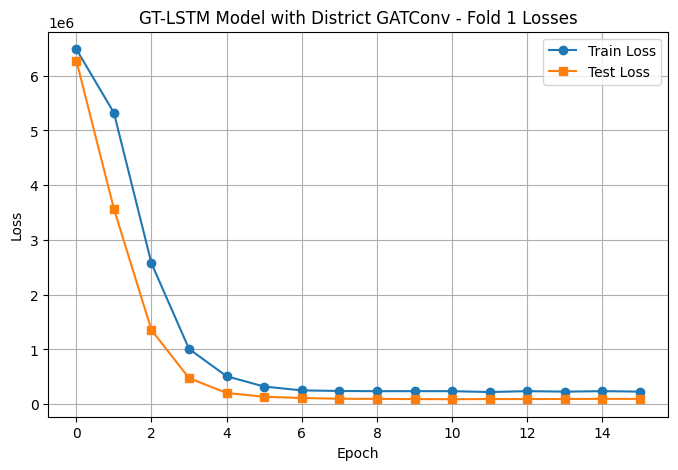


Fold 2/14 - Test Years: [np.int64(2005)]
Fold 2 Epoch [1/50] - Train Loss: 6504877.0577, Test Loss: 6248487.0000, Train RMSE: 2550.4660, Test RMSE: 2499.6974, Train R²: -5.7931, Test R²: -5.9935
Fold 2 Epoch [2/50] - Train Loss: 5762621.0385, Test Loss: 4181519.7500, Train RMSE: 2400.5460, Test RMSE: 2044.8764, Train R²: -5.0179, Test R²: -3.6801
Fold 2 Epoch [3/50] - Train Loss: 3159338.9904, Test Loss: 2046213.0000, Train RMSE: 1777.4530, Test RMSE: 1430.4590, Train R²: -2.2993, Test R²: -1.2902
Fold 2 Epoch [4/50] - Train Loss: 1606398.4423, Test Loss: 810501.2500, Train RMSE: 1267.4377, Test RMSE: 900.2784, Train R²: -0.6776, Test R²: 0.0929
Fold 2 Epoch [5/50] - Train Loss: 747845.9784, Test Loss: 312030.0938, Train RMSE: 864.7809, Test RMSE: 558.5965, Train R²: 0.2190, Test R²: 0.6508
Fold 2 Epoch [6/50] - Train Loss: 433165.4736, Test Loss: 147559.2188, Train RMSE: 658.1531, Test RMSE: 384.1344, Train R²: 0.5476, Test R²: 0.8348
Fold 2 Epoch [7/50] - Train Loss: 316802.5661, Te

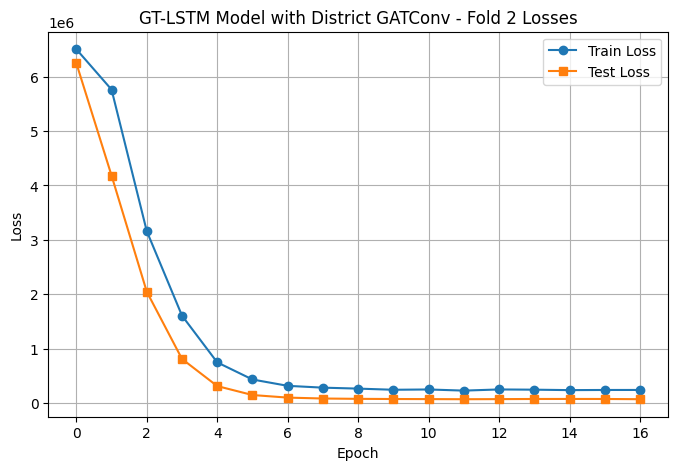


Fold 3/14 - Test Years: [np.int64(2006)]
Fold 3 Epoch [1/50] - Train Loss: 6464225.0192, Test Loss: 6427842.5000, Train RMSE: 2542.4840, Test RMSE: 2535.3190, Train R²: -5.6561, Test R²: -6.5682
Fold 3 Epoch [2/50] - Train Loss: 5058812.3462, Test Loss: 3067325.0000, Train RMSE: 2249.1804, Test RMSE: 1751.3780, Train R²: -4.2089, Test R²: -2.6115
Fold 3 Epoch [3/50] - Train Loss: 1926560.2885, Test Loss: 962839.6875, Train RMSE: 1388.0059, Test RMSE: 981.2439, Train R²: -0.9837, Test R²: -0.1337
Fold 3 Epoch [4/50] - Train Loss: 839800.7452, Test Loss: 362003.3750, Train RMSE: 916.4064, Test RMSE: 601.6672, Train R²: 0.1353, Test R²: 0.5738
Fold 3 Epoch [5/50] - Train Loss: 451504.3317, Test Loss: 128236.1250, Train RMSE: 671.9407, Test RMSE: 358.1007, Train R²: 0.5351, Test R²: 0.8490
Fold 3 Epoch [6/50] - Train Loss: 315388.7644, Test Loss: 84977.5547, Train RMSE: 561.5948, Test RMSE: 291.5091, Train R²: 0.6753, Test R²: 0.8999
Fold 3 Epoch [7/50] - Train Loss: 265901.1004, Test Los

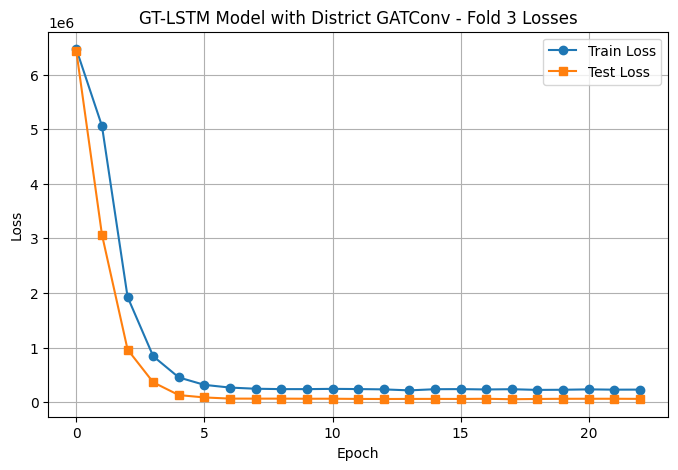


Fold 4/14 - Test Years: [np.int64(2007)]
Fold 4 Epoch [1/50] - Train Loss: 6466478.5000, Test Loss: 6569873.0000, Train RMSE: 2542.9271, Test RMSE: 2563.1763, Train R²: -5.7501, Test R²: -5.2918
Fold 4 Epoch [2/50] - Train Loss: 5436136.2308, Test Loss: 3966208.5000, Train RMSE: 2331.5523, Test RMSE: 1991.5342, Train R²: -4.6746, Test R²: -2.7983
Fold 4 Epoch [3/50] - Train Loss: 2418361.1827, Test Loss: 1528967.2500, Train RMSE: 1555.1081, Test RMSE: 1236.5142, Train R²: -1.5244, Test R²: -0.4643
Fold 4 Epoch [4/50] - Train Loss: 1097158.2356, Test Loss: 729871.3750, Train RMSE: 1047.4532, Test RMSE: 854.3251, Train R²: -0.1453, Test R²: 0.3010
Fold 4 Epoch [5/50] - Train Loss: 552697.2308, Test Loss: 339487.6875, Train RMSE: 743.4361, Test RMSE: 582.6557, Train R²: 0.4231, Test R²: 0.6749
Fold 4 Epoch [6/50] - Train Loss: 368381.8834, Test Loss: 195229.4531, Train RMSE: 606.9447, Test RMSE: 441.8478, Train R²: 0.6155, Test R²: 0.8130
Fold 4 Epoch [7/50] - Train Loss: 274421.1268, Te

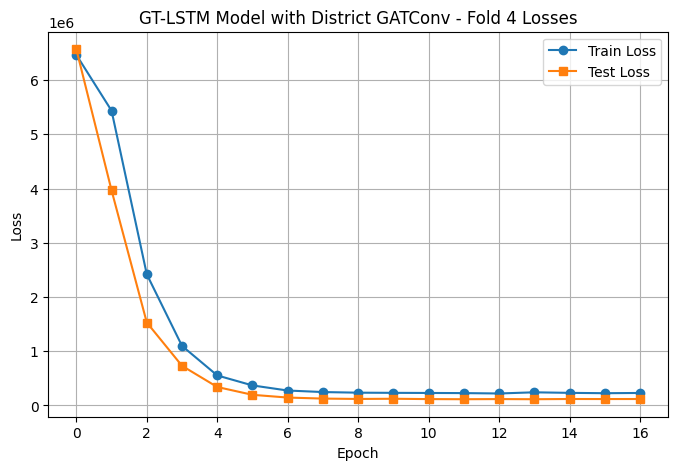


Fold 5/14 - Test Years: [np.int64(2008)]
Fold 5 Epoch [1/50] - Train Loss: 6483116.0962, Test Loss: 6393436.5000, Train RMSE: 2546.1964, Test RMSE: 2528.5245, Train R²: -5.6917, Test R²: -5.8035
Fold 5 Epoch [2/50] - Train Loss: 5571783.4231, Test Loss: 4067260.2500, Train RMSE: 2360.4626, Test RMSE: 2016.7450, Train R²: -4.7511, Test R²: -3.3281
Fold 5 Epoch [3/50] - Train Loss: 2836414.5769, Test Loss: 1659347.5000, Train RMSE: 1684.1658, Test RMSE: 1288.1566, Train R²: -1.9277, Test R²: -0.7658
Fold 5 Epoch [4/50] - Train Loss: 1283864.5192, Test Loss: 772270.4375, Train RMSE: 1133.0775, Test RMSE: 878.7892, Train R²: -0.3252, Test R²: 0.1782
Fold 5 Epoch [5/50] - Train Loss: 661285.0481, Test Loss: 297863.2812, Train RMSE: 813.1943, Test RMSE: 545.7685, Train R²: 0.3174, Test R²: 0.6830
Fold 5 Epoch [6/50] - Train Loss: 395692.4976, Test Loss: 154875.5938, Train RMSE: 629.0409, Test RMSE: 393.5424, Train R²: 0.5916, Test R²: 0.8352
Fold 5 Epoch [7/50] - Train Loss: 269082.0769, Te

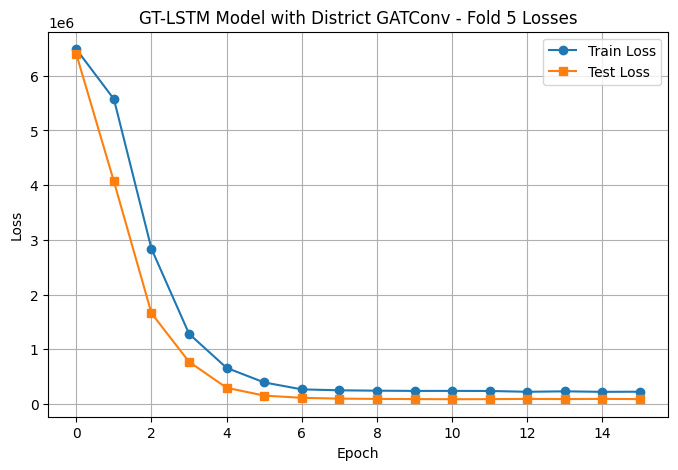


Fold 6/14 - Test Years: [np.int64(2009)]
Fold 6 Epoch [1/50] - Train Loss: 6509699.2692, Test Loss: 5914557.5000, Train RMSE: 2551.4113, Test RMSE: 2431.9863, Train R²: -5.6336, Test R²: -6.5412
Fold 6 Epoch [2/50] - Train Loss: 5300878.7692, Test Loss: 3164768.0000, Train RMSE: 2302.3637, Test RMSE: 1778.9796, Train R²: -4.4018, Test R²: -3.0352
Fold 6 Epoch [3/50] - Train Loss: 2315943.4904, Test Loss: 1181923.7500, Train RMSE: 1521.8224, Test RMSE: 1087.1632, Train R²: -1.3600, Test R²: -0.5070
Fold 6 Epoch [4/50] - Train Loss: 1019639.5192, Test Loss: 498674.0625, Train RMSE: 1009.7720, Test RMSE: 706.1686, Train R²: -0.0390, Test R²: 0.3642
Fold 6 Epoch [5/50] - Train Loss: 536487.0721, Test Loss: 249188.3281, Train RMSE: 732.4528, Test RMSE: 499.1877, Train R²: 0.4533, Test R²: 0.6823
Fold 6 Epoch [6/50] - Train Loss: 364893.3365, Test Loss: 156750.0312, Train RMSE: 604.0640, Test RMSE: 395.9167, Train R²: 0.6282, Test R²: 0.8001
Fold 6 Epoch [7/50] - Train Loss: 296107.3137, Te

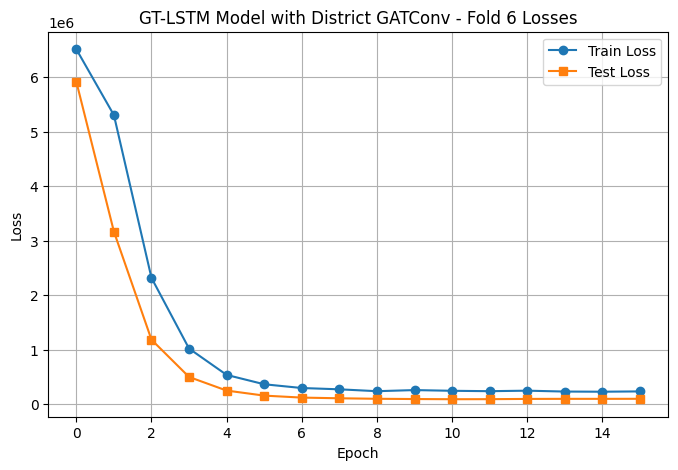


Fold 7/14 - Test Years: [np.int64(2010)]
Fold 7 Epoch [1/50] - Train Loss: 6421379.7500, Test Loss: 6678912.0000, Train RMSE: 2534.0441, Test RMSE: 2584.3590, Train R²: -5.6452, Test R²: -5.5087
Fold 7 Epoch [2/50] - Train Loss: 4803865.8077, Test Loss: 3556709.2500, Train RMSE: 2191.7723, Test RMSE: 1885.9239, Train R²: -3.9713, Test R²: -2.4661
Fold 7 Epoch [3/50] - Train Loss: 2371619.3173, Test Loss: 1716943.5000, Train RMSE: 1540.0063, Test RMSE: 1310.3219, Train R²: -1.4543, Test R²: -0.6732
Fold 7 Epoch [4/50] - Train Loss: 1013146.2404, Test Loss: 773880.0000, Train RMSE: 1006.5517, Test RMSE: 879.7045, Train R²: -0.0485, Test R²: 0.2458
Fold 7 Epoch [5/50] - Train Loss: 532923.9904, Test Loss: 439996.2188, Train RMSE: 730.0164, Test RMSE: 663.3221, Train R²: 0.4485, Test R²: 0.5712
Fold 7 Epoch [6/50] - Train Loss: 341988.3317, Test Loss: 266104.3125, Train RMSE: 584.7977, Test RMSE: 515.8530, Train R²: 0.6461, Test R²: 0.7407
Fold 7 Epoch [7/50] - Train Loss: 258870.5216, Te

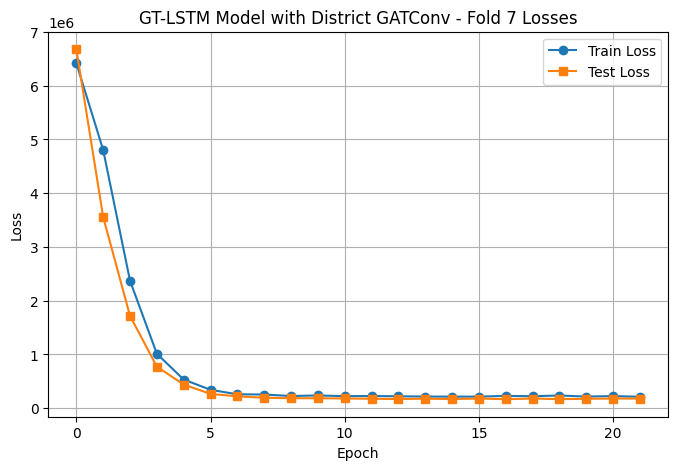


Fold 8/14 - Test Years: [np.int64(2011)]
Fold 8 Epoch [1/50] - Train Loss: 6366055.7500, Test Loss: 8109215.0000, Train RMSE: 2523.1044, Test RMSE: 2847.6684, Train R²: -5.6442, Test R²: -6.8707
Fold 8 Epoch [2/50] - Train Loss: 5843609.2308, Test Loss: 6166581.0000, Train RMSE: 2417.3559, Test RMSE: 2483.2603, Train R²: -5.0989, Test R²: -4.9852
Fold 8 Epoch [3/50] - Train Loss: 3249867.5192, Test Loss: 2569776.0000, Train RMSE: 1802.7389, Test RMSE: 1603.0522, Train R²: -2.3918, Test R²: -1.4942
Fold 8 Epoch [4/50] - Train Loss: 1342447.1971, Test Loss: 1210303.7500, Train RMSE: 1158.6402, Test RMSE: 1100.1381, Train R²: -0.4011, Test R²: -0.1747
Fold 8 Epoch [5/50] - Train Loss: 674338.8389, Test Loss: 546290.5625, Train RMSE: 821.1814, Test RMSE: 739.1147, Train R²: 0.2962, Test R²: 0.4698
Fold 8 Epoch [6/50] - Train Loss: 374961.1178, Test Loss: 363628.4688, Train RMSE: 612.3407, Test RMSE: 603.0161, Train R²: 0.6087, Test R²: 0.6471
Fold 8 Epoch [7/50] - Train Loss: 271736.8654,

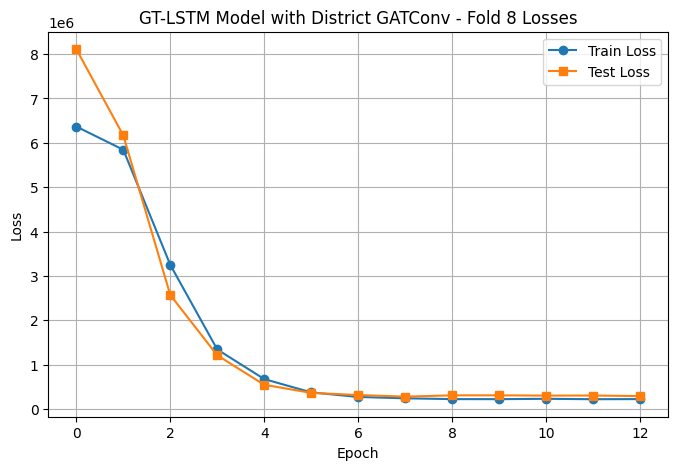


Fold 9/14 - Test Years: [np.int64(2012)]
Fold 9 Epoch [1/50] - Train Loss: 6433229.0962, Test Loss: 7236339.0000, Train RMSE: 2536.3811, Test RMSE: 2690.0445, Train R²: -5.5012, Test R²: -11.1163
Fold 9 Epoch [2/50] - Train Loss: 6022255.2308, Test Loss: 5716084.0000, Train RMSE: 2454.0284, Test RMSE: 2390.8334, Train R²: -5.0859, Test R²: -8.5708
Fold 9 Epoch [3/50] - Train Loss: 3529479.1442, Test Loss: 1727707.7500, Train RMSE: 1878.6908, Test RMSE: 1314.4229, Train R²: -2.5668, Test R²: -1.8928
Fold 9 Epoch [4/50] - Train Loss: 1303248.2740, Test Loss: 629299.3125, Train RMSE: 1141.5990, Test RMSE: 793.2839, Train R²: -0.3170, Test R²: -0.0537
Fold 9 Epoch [5/50] - Train Loss: 586713.4303, Test Loss: 299837.3438, Train RMSE: 765.9722, Test RMSE: 547.5740, Train R²: 0.4071, Test R²: 0.4980
Fold 9 Epoch [6/50] - Train Loss: 297412.0841, Test Loss: 235977.3750, Train RMSE: 545.3550, Test RMSE: 485.7750, Train R²: 0.6994, Test R²: 0.6049
Fold 9 Epoch [7/50] - Train Loss: 254625.2536, 

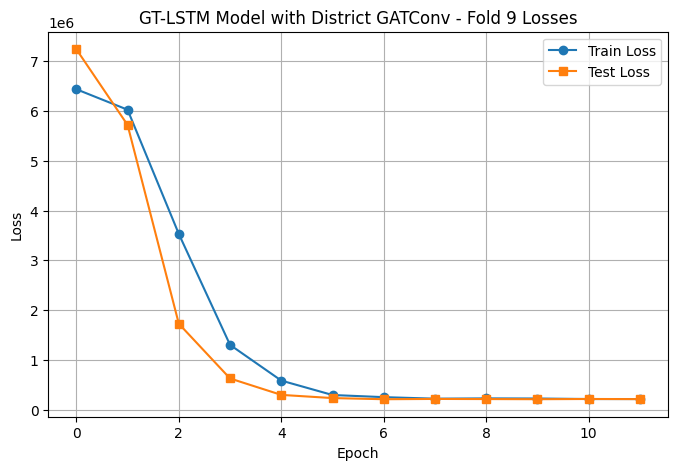


Fold 10/14 - Test Years: [np.int64(2013)]
Fold 10 Epoch [1/50] - Train Loss: 6454413.7885, Test Loss: 6825536.0000, Train RMSE: 2540.5539, Test RMSE: 2612.5727, Train R²: -5.5979, Test R²: -7.6806
Fold 10 Epoch [2/50] - Train Loss: 5715849.2308, Test Loss: 4849511.0000, Train RMSE: 2390.7842, Test RMSE: 2202.1605, Train R²: -4.8429, Test R²: -5.1675
Fold 10 Epoch [3/50] - Train Loss: 2865994.6923, Test Loss: 1483336.5000, Train RMSE: 1692.9249, Test RMSE: 1217.9231, Train R²: -1.9297, Test R²: -0.8865
Fold 10 Epoch [4/50] - Train Loss: 1131867.7452, Test Loss: 734270.0000, Train RMSE: 1063.8927, Test RMSE: 856.8955, Train R²: -0.1570, Test R²: 0.0662
Fold 10 Epoch [5/50] - Train Loss: 549564.0361, Test Loss: 364909.6250, Train RMSE: 741.3259, Test RMSE: 604.0775, Train R²: 0.4382, Test R²: 0.5359
Fold 10 Epoch [6/50] - Train Loss: 328983.8450, Test Loss: 227336.9062, Train RMSE: 573.5711, Test RMSE: 476.7986, Train R²: 0.6637, Test R²: 0.7109
Fold 10 Epoch [7/50] - Train Loss: 263277.

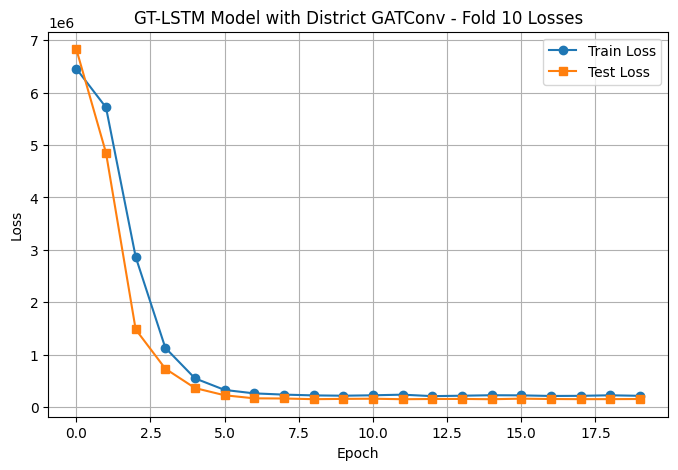


Fold 11/14 - Test Years: [np.int64(2014)]
Fold 11 Epoch [1/50] - Train Loss: 6677631.5000, Test Loss: 3920213.7500, Train RMSE: 2584.1113, Test RMSE: 1979.9531, Train R²: -5.8302, Test R²: -3.8737
Fold 11 Epoch [2/50] - Train Loss: 5793332.9615, Test Loss: 2387048.2500, Train RMSE: 2406.9343, Test RMSE: 1545.0075, Train R²: -4.9257, Test R²: -1.9676
Fold 11 Epoch [3/50] - Train Loss: 2748233.2308, Test Loss: 2107759.7500, Train RMSE: 1657.7796, Test RMSE: 1451.8126, Train R²: -1.8110, Test R²: -1.6204
Fold 11 Epoch [4/50] - Train Loss: 1273053.0817, Test Loss: 1008479.1250, Train RMSE: 1128.2965, Test RMSE: 1004.2306, Train R²: -0.3021, Test R²: -0.2538
Fold 11 Epoch [5/50] - Train Loss: 614897.6611, Test Loss: 1221277.8750, Train RMSE: 784.1541, Test RMSE: 1105.1144, Train R²: 0.3711, Test R²: -0.5183
Fold 11 Epoch [6/50] - Train Loss: 348954.8510, Test Loss: 894296.4375, Train RMSE: 590.7240, Test RMSE: 945.6725, Train R²: 0.6431, Test R²: -0.1118
Fold 11 Epoch [7/50] - Train Loss: 

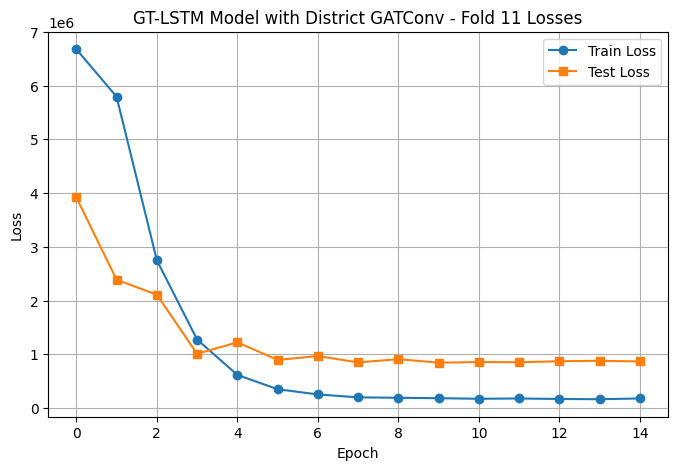


Fold 12/14 - Test Years: [np.int64(2015)]
Fold 12 Epoch [1/50] - Train Loss: 6598854.7692, Test Loss: 5125913.0000, Train RMSE: 2568.8236, Test RMSE: 2264.0479, Train R²: -5.6887, Test R²: -5.8155
Fold 12 Epoch [2/50] - Train Loss: 6222963.4231, Test Loss: 3962342.0000, Train RMSE: 2494.5868, Test RMSE: 1990.5632, Train R²: -5.3077, Test R²: -4.2684
Fold 12 Epoch [3/50] - Train Loss: 3579432.1250, Test Loss: 1326539.8750, Train RMSE: 1891.9387, Test RMSE: 1151.7551, Train R²: -2.6282, Test R²: -0.7638
Fold 12 Epoch [4/50] - Train Loss: 1304422.3077, Test Loss: 779856.5625, Train RMSE: 1142.1131, Test RMSE: 883.0949, Train R²: -0.3222, Test R²: -0.0369
Fold 12 Epoch [5/50] - Train Loss: 625294.3990, Test Loss: 418401.7188, Train RMSE: 790.7556, Test RMSE: 646.8398, Train R²: 0.3662, Test R²: 0.4437
Fold 12 Epoch [6/50] - Train Loss: 357267.6587, Test Loss: 272373.9375, Train RMSE: 597.7187, Test RMSE: 521.8946, Train R²: 0.6379, Test R²: 0.6378
Fold 12 Epoch [7/50] - Train Loss: 274953

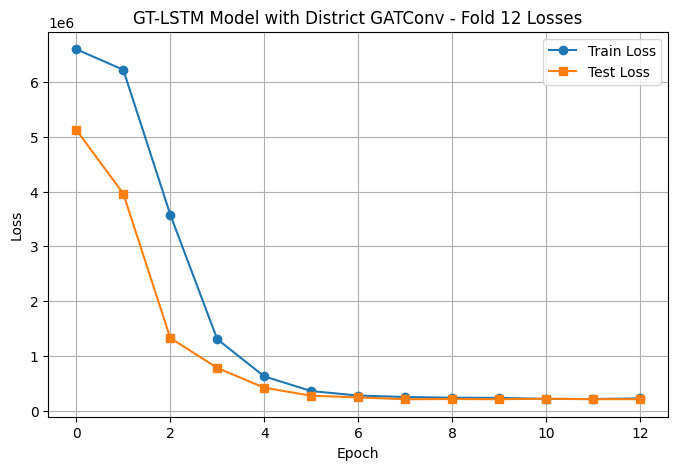


Fold 13/14 - Test Years: [np.int64(2016)]
Fold 13 Epoch [1/50] - Train Loss: 6458184.5769, Test Loss: 6897874.0000, Train RMSE: 2541.2959, Test RMSE: 2626.3804, Train R²: -5.6895, Test R²: -9.6334
Fold 13 Epoch [2/50] - Train Loss: 5936411.8462, Test Loss: 5159766.5000, Train RMSE: 2436.4753, Test RMSE: 2271.5119, Train R²: -5.1491, Test R²: -6.9540
Fold 13 Epoch [3/50] - Train Loss: 3341119.1058, Test Loss: 1738081.2500, Train RMSE: 1827.8728, Test RMSE: 1318.3631, Train R²: -2.4608, Test R²: -1.6793
Fold 13 Epoch [4/50] - Train Loss: 1287221.3317, Test Loss: 685798.2500, Train RMSE: 1134.5578, Test RMSE: 828.1294, Train R²: -0.3333, Test R²: -0.0572
Fold 13 Epoch [5/50] - Train Loss: 649526.6538, Test Loss: 254783.5938, Train RMSE: 805.9322, Test RMSE: 504.7609, Train R²: 0.3272, Test R²: 0.6072
Fold 13 Epoch [6/50] - Train Loss: 360242.5769, Test Loss: 187508.1094, Train RMSE: 600.2021, Test RMSE: 433.0221, Train R²: 0.6269, Test R²: 0.7109
Fold 13 Epoch [7/50] - Train Loss: 312541

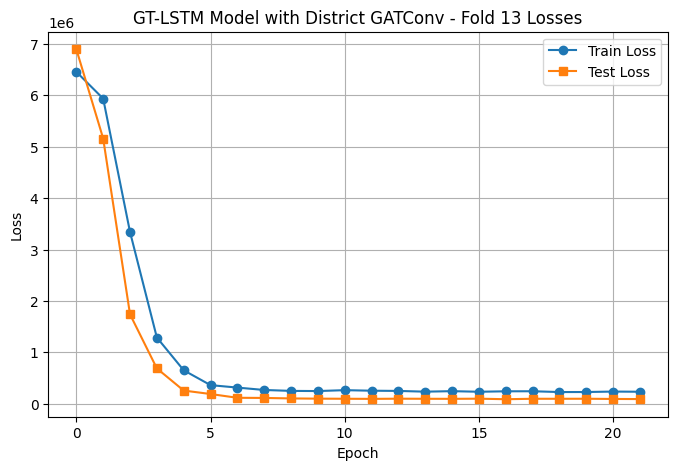


Fold 14/14 - Test Years: [np.int64(2017)]
Fold 14 Epoch [1/50] - Train Loss: 6453238.1923, Test Loss: 6835432.5000, Train RMSE: 2540.3225, Test RMSE: 2614.4660, Train R²: -5.7295, Test R²: -9.8504
Fold 14 Epoch [2/50] - Train Loss: 5540745.9423, Test Loss: 4212410.0000, Train RMSE: 2353.8789, Test RMSE: 2052.4156, Train R²: -4.7780, Test R²: -5.6866
Fold 14 Epoch [3/50] - Train Loss: 2979897.6154, Test Loss: 2027464.0000, Train RMSE: 1726.2380, Test RMSE: 1423.8904, Train R²: -2.1075, Test R²: -2.2183
Fold 14 Epoch [4/50] - Train Loss: 1473879.0673, Test Loss: 783427.1875, Train RMSE: 1214.0342, Test RMSE: 885.1142, Train R²: -0.5370, Test R²: -0.2436
Fold 14 Epoch [5/50] - Train Loss: 713720.6947, Test Loss: 359234.4375, Train RMSE: 844.8199, Test RMSE: 599.3617, Train R²: 0.2557, Test R²: 0.4298
Fold 14 Epoch [6/50] - Train Loss: 433920.4808, Test Loss: 172825.6406, Train RMSE: 658.7264, Test RMSE: 415.7230, Train R²: 0.5475, Test R²: 0.7257
Fold 14 Epoch [7/50] - Train Loss: 293136

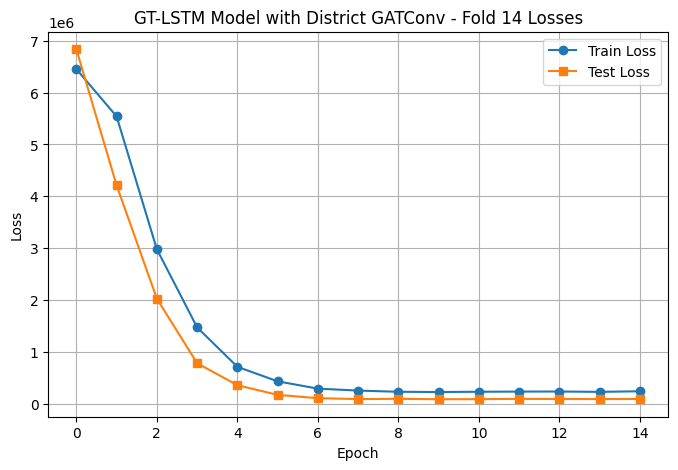


Overall Cross-Validation Metrics:
Average Train RMSE: 472.7291 (±16.8333)
Average Train R²: 0.7692 (±0.0171)
Average Test RMSE: 399.3379 (±168.6605)
Average Test R²: 0.7676 (±0.2479)
Cross-validation results saved to /content/gt_lstm_cv_yield_predictions_with_district_gatconv.csv


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from torch_geometric.nn import GATConv  # Use GATConv instead of GraphSAGE

# Set seeds for reproducibility
SEED = 1024
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Climate Data
climate_data = pd.read_csv('/content/cp_soil_static_idx_7M_701grids_2004.csv')
climate_data_values = climate_data.values  # [9814, 84]
scaler_cp = StandardScaler()
climate_data_normalized = scaler_cp.fit_transform(climate_data_values)
climate_data_reshaped = climate_data_normalized.reshape(9814, 12, 7).transpose(0, 2, 1)  # [9814, 7, 12]
climate_data_tensor = torch.tensor(climate_data_reshaped, dtype=torch.float32).view(14, 701, 7, 12)  # [14, 701, 7, 12]

# Remote Sensing Data
rs_data = pd.read_csv('/content/rs_701_2004.csv')
rs_data_values = rs_data.values  # [9814, 21]
scaler_rs = StandardScaler()
rs_data_normalized = scaler_rs.fit_transform(rs_data_values)
rs_data_reshaped = rs_data_normalized.reshape(9814, 3, 7).transpose(0, 2, 1)  # [9814, 7, 3]
rs_data_tensor = torch.tensor(rs_data_reshaped, dtype=torch.float32).view(14, 701, 7, 3)  # [14, 701, 7, 3]

# Yield Data
yield_file_path = '/content/detrended_district_yearly_yield_6s_2004_128g.csv'
yield_data = pd.read_csv(yield_file_path)
district_names = yield_data['District'].unique()
district_name_to_index = {name: idx for idx, name in enumerate(district_names)}
yield_data['District'] = yield_data['District'].map(district_name_to_index)
yield_values = yield_data[['Year', 'Detrended_Yield', 'District', 'Trend', 'Actual']].values
years = yield_values[:, 0].astype(int)
detrended_yields = yield_values[:, 1]
districts = yield_values[:, 2].astype(int)
trends = yield_values[:, 3]
actual_yields = yield_values[:, 4]
district_mapping_df = pd.DataFrame(list(district_name_to_index.items()), columns=['District_Name', 'District_Index'])
district_mapping_df.to_csv('/content/district_name_to_index.csv', index=False)

num_districts = 128
num_years = 14
district_yields = np.zeros((num_districts, num_years))
trends_per_district = np.zeros((num_districts, num_years))
actual_yields_per_district = np.zeros((num_districts, num_years))
for i in range(len(years)):
    district_index = districts[i]
    year_index = years[i] - 2004
    district_yields[district_index, year_index] = detrended_yields[i]
    trends_per_district[district_index, year_index] = trends[i]
    actual_yields_per_district[district_index, year_index] = actual_yields[i]

district_yields_tensor = torch.tensor(district_yields, dtype=torch.float32)  # [128, 14]
trends_tensor = torch.tensor(trends_per_district, dtype=torch.float32)  # [128, 14]
actual_yields_tensor = torch.tensor(actual_yields_per_district, dtype=torch.float32)  # [128, 14]

# Load district edge index
district_edge_index_df = pd.read_csv('/content/district_edge_index_nn5_haversine.csv')
district_edge_index = torch.tensor(district_edge_index_df.values, dtype=torch.long).t().contiguous()  # [2, num_edges]

# Define the GT-LSTM Model with two GATConv layers among districts
class GTLSTMYieldPrediction(nn.Module):
    def __init__(self, num_grids=701, num_districts=128, climate_features=12, rs_features=3,
                 hidden_dim=256, embedding_size=128, num_layers=2, heads=2):
        super(GTLSTMYieldPrediction, self).__init__()
        self.num_grids = num_grids
        self.num_districts = num_districts
        self.embedding_size = embedding_size
        self.heads = heads

        # LSTM for climate data
        self.climate_lstm = nn.LSTM(input_size=climate_features, hidden_size=hidden_dim,
                                    num_layers=num_layers, batch_first=True)

        # LSTM for remote sensing data
        self.rs_lstm = nn.LSTM(input_size=rs_features, hidden_size=hidden_dim,
                               num_layers=num_layers, batch_first=True)

        # Dense layer to reduce combined LSTM outputs to embedding size
        self.dense = nn.Sequential(
            nn.Linear(hidden_dim * 2, embedding_size),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.norm2 = nn.LayerNorm(embedding_size)
        # Two GATConv layers among districts
        self.gat1 = GATConv(in_channels=embedding_size, out_channels=embedding_size // heads, heads=heads, dropout=0.1)
        self.gat2 = GATConv(in_channels=embedding_size, out_channels=embedding_size, heads=1, dropout=0.1)

        # MLP to predict district-level yields
        self.yield_mlp = nn.Sequential(
            nn.Linear(embedding_size, 64),  # 128 -> 64
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1)               # 64 -> 1 (district-level yield)
        )

        # District weights for aggregation from grids to districts
        self.district_weights = nn.Parameter(torch.randn(num_districts, num_grids))  # [128, 701]
        self.residual_scale = nn.Parameter(torch.ones(1))  # Scalar residual scale

    def forward(self, climate_data, rs_data, district_edge_index):
        # climate_data: [701, 7, 12], rs_data: [701, 7, 3]
        climate_out, _ = self.climate_lstm(climate_data)  # [701, 7, 256]
        rs_out, _ = self.rs_lstm(rs_data)                # [701, 7, 256]
        climate_emb = climate_out[:, -1, :]              # [701, 256]
        rs_emb = rs_out[:, -1, :]                        # [701, 256]
        combined_emb = torch.cat([climate_emb, rs_emb], dim=-1)  # [701, 512]
        dense_out = self.dense(combined_emb)             # [701, 128]

        # Aggregate grid embeddings to district embeddings
        district_embeddings = torch.matmul(self.district_weights, dense_out)  # [128, 701] × [701, 128] -> [128, 128]

        # Apply two GATConv layers among districts
        gat_out = self.gat1(district_embeddings, district_edge_index)  # [128, 128] (heads=2, 64 each)
        gat_out = F.relu(gat_out)
        gat_out = self.gat2(gat_out, district_edge_index)  # [128, 128] (heads=1)
        gat_out = F.relu(gat_out)
        gat_out = self.norm2(gat_out)

        # Scaled residual connection
        scaled_residual = self.residual_scale * district_embeddings  # [128, 128]
        combined_out = gat_out + scaled_residual  # [128, 128]

        # Predict district-level yields
        district_yields = self.yield_mlp(combined_out)  # [128, 128] -> [128, 1]

        return district_yields

# Cross-validation setup
n_splits = 14
years_per_fold = num_years // n_splits  # 2 years per fold
year_indices = np.arange(num_years)
fold_year_blocks = [year_indices[i * years_per_fold:(i + 1) * years_per_fold] for i in range(n_splits)]

# Metrics storage
fold_train_rmses = []
fold_train_r2s = []
fold_test_rmses = []
fold_test_r2s = []
all_results = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cross-validation loop
for fold, test_indices in enumerate(fold_year_blocks):
    print(f"\nFold {fold + 1}/{n_splits} - Test Years: {[2004 + y for y in test_indices]}")
    train_indices = np.setdiff1d(year_indices, test_indices)

    # Split data for this fold
    train_climate = climate_data_tensor[train_indices]  # [12, 701, 7, 12]
    train_rs = rs_data_tensor[train_indices]  # [12, 701, 7, 3]
    train_yields = district_yields_tensor[:, train_indices]  # [128, 12] (detrended)
    train_trends = trends_tensor[:, train_indices]  # [128, 12]
    train_actual = actual_yields_tensor[:, train_indices]  # [128, 12]
    test_climate = climate_data_tensor[test_indices]  # [2, 701, 7, 12]
    test_rs = rs_data_tensor[test_indices]  # [2, 701, 7, 3]
    test_yields = district_yields_tensor[:, test_indices]  # [128, 2] (detrended)
    test_trends = trends_tensor[:, test_indices]  # [128, 2]
    test_actual = actual_yields_tensor[:, test_indices]  # [128, 2]

    # Initialize model
    model = GTLSTMYieldPrediction().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Early stopping parameters
    patience = 5
    min_delta = 0.001
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    # Loss tracking for this fold
    train_losses = []
    test_losses = []

    # Training loop
    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        all_train_preds = []  # Predicted + Trend
        all_train_targets = []  # Actual yields
        for year_idx in range(len(train_indices)):
            climate_batch = train_climate[year_idx].to(device)
            rs_batch = train_rs[year_idx].to(device)
            trend_batch = train_trends[:, year_idx:year_idx+1].to(device)  # [128, 1]
            actual_batch = train_actual[:, year_idx:year_idx+1].to(device)  # [128, 1]
            district_edge_index_batch = district_edge_index.to(device)
            pred = model(climate_batch, rs_batch, district_edge_index_batch)  # [128, 1] (detrended)
            predicted_yields = pred + trend_batch  # Add trend
            loss = criterion(predicted_yields, actual_batch)  # Compare with actual
            train_loss += loss.item()
            all_train_preds.extend(predicted_yields.detach().cpu().numpy())
            all_train_targets.extend(actual_batch.cpu().numpy())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = train_loss / len(train_indices)
        train_losses.append(avg_train_loss)
        train_rmse = np.sqrt(mean_squared_error(all_train_targets, all_train_preds))
        train_r2 = r2_score(all_train_targets, all_train_preds)

        # Test (validation) for this fold
        model.eval()
        test_loss = 0
        all_test_preds = []
        all_test_targets = []
        with torch.no_grad():
            for year_idx in range(len(test_indices)):
                climate_batch = test_climate[year_idx].to(device)
                rs_batch = test_rs[year_idx].to(device)
                trend_batch = test_trends[:, year_idx:year_idx+1].to(device)  # [128, 1]
                actual_batch = test_actual[:, year_idx:year_idx+1].to(device)  # [128, 1]
                pred = model(climate_batch, rs_batch, district_edge_index.to(device))
                predicted_yields = pred + trend_batch
                loss = criterion(predicted_yields, actual_batch)
                test_loss += loss.item()
                all_test_preds.extend(predicted_yields.cpu().numpy())
                all_test_targets.extend(actual_batch.cpu().numpy())

        avg_test_loss = test_loss / len(test_indices)
        test_losses.append(avg_test_loss)
        test_rmse = np.sqrt(mean_squared_error(all_test_targets, all_test_preds))
        test_r2 = r2_score(all_test_targets, all_test_preds)

        print(f"Fold {fold + 1} Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, "
              f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}, Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")

        # Early stopping based on test loss
        if avg_test_loss < best_val_loss - min_delta:
            best_val_loss = avg_test_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    # Load best model for this fold
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Store fold metrics
    fold_train_rmses.append(train_rmse)
    fold_train_r2s.append(train_r2)
    fold_test_rmses.append(test_rmse)
    fold_test_r2s.append(test_r2)

    # Save predictions for this fold
    for year_idx, year in enumerate(test_indices):
        preds = all_test_preds[year_idx * num_districts:(year_idx + 1) * num_districts]
        targets = all_test_targets[year_idx * num_districts:(year_idx + 1) * num_districts]
        for district in range(num_districts):
            actual_yield = actual_yields_per_district[district, year].item()
            predicted_yield = preds[district][0] if isinstance(preds[district], np.ndarray) else preds[district]
            all_results.append({
                'Fold': fold + 1,
                'Year': 2004 + year,
                'District': district_names[district],
                'Actual_Yield': actual_yield,
                'Predicted_Yield': predicted_yield
            })

    # Plot losses for this fold
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(test_losses, label='Test Loss', marker='s')
    plt.title(f'GT-LSTM Model with District GATConv - Fold {fold + 1} Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Compute and print overall metrics
avg_train_rmse = np.mean(fold_train_rmses)
avg_train_r2 = np.mean(fold_train_r2s)
avg_test_rmse = np.mean(fold_test_rmses)
avg_test_r2 = np.mean(fold_test_r2s)

print("\nOverall Cross-Validation Metrics:")
print(f"Average Train RMSE: {avg_train_rmse:.4f} (±{np.std(fold_train_rmses):.4f})")
print(f"Average Train R²: {avg_train_r2:.4f} (±{np.std(fold_train_r2s):.4f})")
print(f"Average Test RMSE: {avg_test_rmse:.4f} (±{np.std(fold_test_rmses):.4f})")
print(f"Average Test R²: {avg_test_r2:.4f} (±{np.std(fold_test_r2s):.4f})")

# Save all predictions
results_df = pd.DataFrame(all_results)
results_df.to_csv('/content/gt_lstm_cv_yield_predictions_with_district_gatconv.csv', index=False)
print(f"Cross-validation results saved to /content/gt_lstm_cv_yield_predictions_with_district_gatconv.csv")

```
with nn 3 haversine
Overall Cross-Validation Metrics:
Average Train RMSE: 471.8429 (±28.8927)
Average Train R²: 0.7684 (±0.0299)
Average Test RMSE: 417.8887 (±160.2125)
Average Test R²: 0.7570 (±0.2074)

nn 5 haversine

Overall Cross-Validation Metrics:
Average Train RMSE: 470.4016 (±28.8898)
Average Train R²: 0.7698 (±0.0299)
Average Test RMSE: 422.3711 (±172.8959)
Average Test R²: 0.7478 (±0.2312)




```

------------Yearly Metrics----------------
    Year        RMSE        R2
0   2004  310.613415  0.884975
1   2005  266.728377  0.920374
2   2006  242.499344  0.930762
3   2007  343.300655  0.887133
4   2008  301.982669  0.902957
5   2009  313.521461  0.874670
6   2010  422.316800  0.826193
7   2011  539.208307  0.717806
8   2012  464.011969  0.639496
9   2013  394.902808  0.801668
10  2014  930.074462 -0.075425
11  2015  457.145424  0.722133
12  2016  298.551898  0.862598
13  2017  305.872720  0.851489

------------Average Yearly Metrics----------------
Average yearly RMSE: 399.3379
Average yearly R²: 0.7676


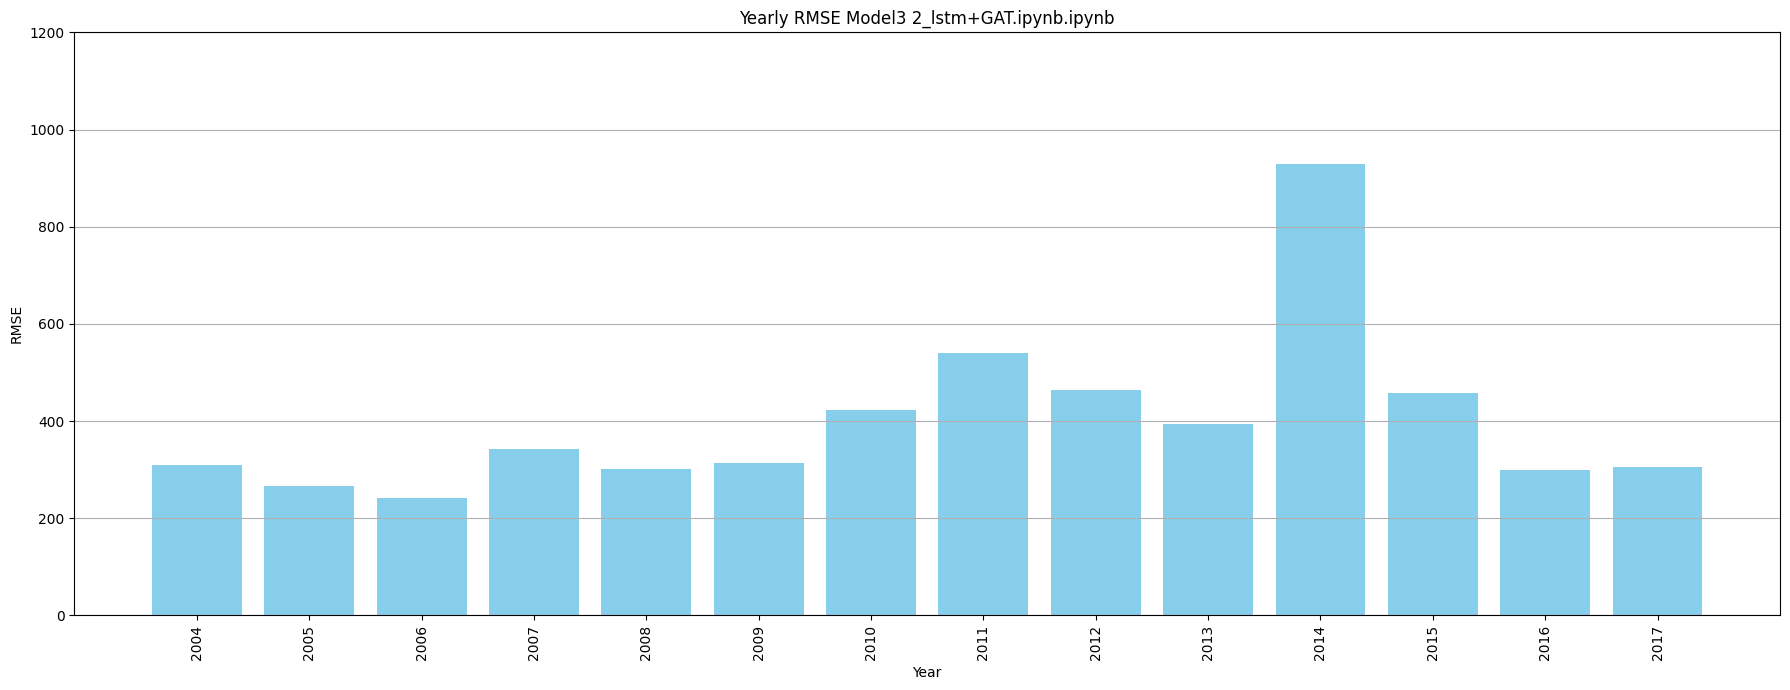

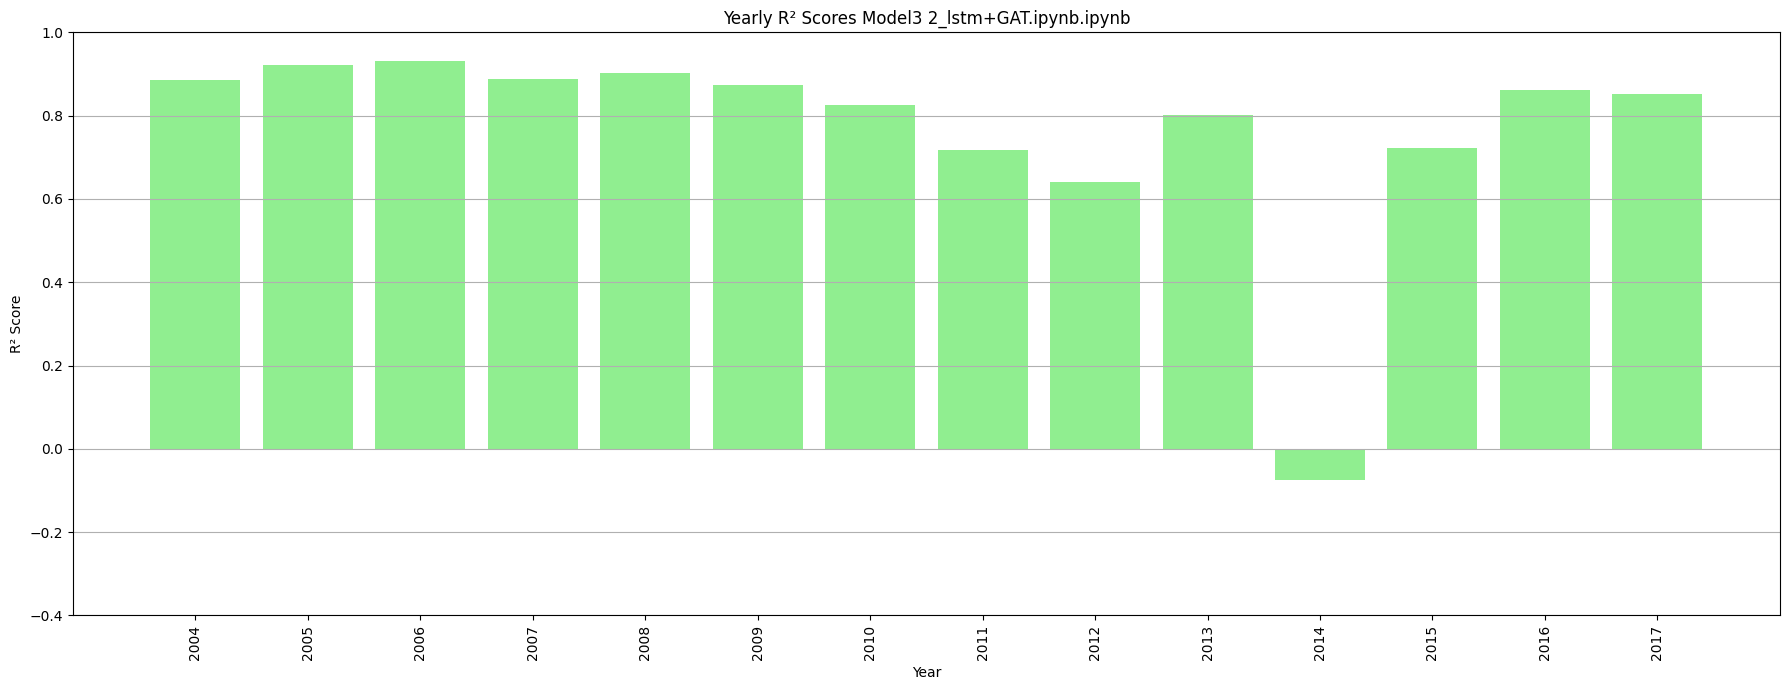

In [ ]:
# Load the results file
results_df = pd.read_csv('/content/gt_lstm_cv_yield_predictions_with_district_gatconv.csv')

# Initialize dictionaries to store RMSE and R² for each year
yearly_rmse = {}
yearly_r2 = {}

# Group by year and calculate RMSE and R² for each year
for year, group in results_df.groupby('Year'):
    actual_yields = group['Actual_Yield'].values
    predicted_yields = group['Predicted_Yield'].values

    # Calculate RMSE and R²
    rmse = np.sqrt(mean_squared_error(actual_yields, predicted_yields))
    r2 = r2_score(actual_yields, predicted_yields)

    # Store the results in the dictionaries
    yearly_rmse[year] = rmse
    yearly_r2[year] = r2

# Convert the dictionaries to a DataFrame for easier viewing and visualization
yearly_metrics_df = pd.DataFrame({
    'Year': list(yearly_rmse.keys()),
    'RMSE': list(yearly_rmse.values()),
    'R2': list(yearly_r2.values())
})

# Save the yearly metrics to a CSV file
yearly_metrics_df.to_csv('/content/yearly_yield_metrics3.csv', index=False)

# Calculate and print the average yearly metrics separately
average_yearly_rmse = yearly_metrics_df['RMSE'].mean()
average_yearly_r2 = yearly_metrics_df['R2'].mean()

print("------------Yearly Metrics----------------")
print(yearly_metrics_df)
print("\n------------Average Yearly Metrics----------------")
print(f"Average yearly RMSE: {average_yearly_rmse:.4f}")
print(f"Average yearly R²: {average_yearly_r2:.4f}")

# Visualization of Yearly Metrics

# Yearly RMSE Plot
plt.figure(figsize=(18, 7))
plt.bar(yearly_metrics_df['Year'], yearly_metrics_df['RMSE'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('RMSE')
plt.title('Yearly RMSE Model3 2_lstm+GAT.ipynb.ipynb')
plt.xticks(yearly_metrics_df['Year'], rotation=90)
plt.ylim(0, 1200)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Yearly R² Plot
plt.figure(figsize=(18, 7))
plt.bar(yearly_metrics_df['Year'], yearly_metrics_df['R2'], color='lightgreen')
plt.xlabel('Year')
plt.ylabel('R² Score')
plt.title('Yearly R² Scores Model3 2_lstm+GAT.ipynb.ipynb')
plt.xticks(yearly_metrics_df['Year'], rotation=90)
plt.ylim(-0.4, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## GAT Among Grids


Fold 1/7 - Test Years: [np.int64(2004), np.int64(2005)]
Fold 1 Epoch [1/30] - Train Loss: 6463373.7292, Test Loss: 6184224.2500, Train RMSE: 2542.3166, Test RMSE: 2486.8100, Train R²: -5.8729, Test R²: -6.1379
Fold 1 Epoch [2/30] - Train Loss: 6042776.5833, Test Loss: 5402198.5000, Train RMSE: 2458.2060, Test RMSE: 2324.2630, Train R²: -5.4257, Test R²: -5.2353
Fold 1 Epoch [3/30] - Train Loss: 4882619.5000, Test Loss: 3768333.0000, Train RMSE: 2209.6650, Test RMSE: 1941.2195, Train R²: -4.1920, Test R²: -3.3495
Fold 1 Epoch [4/30] - Train Loss: 3104645.6979, Test Loss: 2040202.4375, Train RMSE: 1762.0005, Test RMSE: 1428.3565, Train R²: -2.3014, Test R²: -1.3548
Fold 1 Epoch [5/30] - Train Loss: 1769786.6979, Test Loss: 1101766.8750, Train RMSE: 1330.3333, Test RMSE: 1049.6509, Train R²: -0.8819, Test R²: -0.2717
Fold 1 Epoch [6/30] - Train Loss: 966263.7083, Test Loss: 549219.5938, Train RMSE: 982.9871, Test RMSE: 741.0935, Train R²: -0.0275, Test R²: 0.3661
Fold 1 Epoch [7/30] - Tr

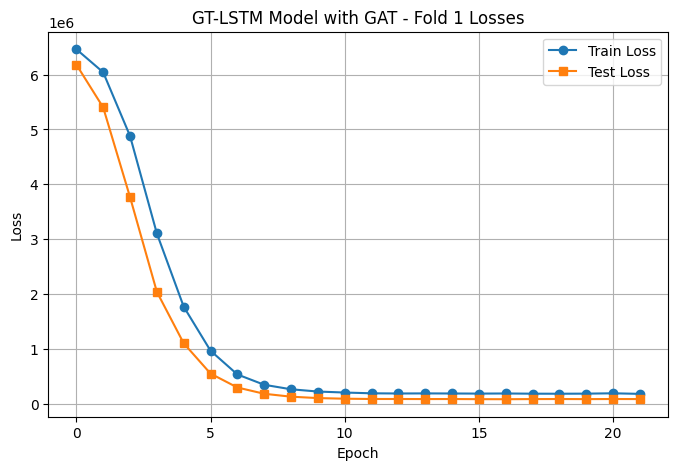


Fold 2/7 - Test Years: [np.int64(2006), np.int64(2007)]
Fold 2 Epoch [1/30] - Train Loss: 6461887.7292, Test Loss: 6589989.0000, Train RMSE: 2542.0244, Test RMSE: 2567.0974, Train R²: -5.7583, Test R²: -5.9583
Fold 2 Epoch [2/30] - Train Loss: 6276338.3958, Test Loss: 6194279.0000, Train RMSE: 2505.2621, Test RMSE: 2488.8309, Train R²: -5.5643, Test R²: -5.5405
Fold 2 Epoch [3/30] - Train Loss: 5629669.1667, Test Loss: 5114061.7500, Train RMSE: 2372.6924, Test RMSE: 2261.4292, Train R²: -4.8879, Test R²: -4.3999
Fold 2 Epoch [4/30] - Train Loss: 4255649.5625, Test Loss: 3327545.1250, Train RMSE: 2062.9226, Test RMSE: 1824.1560, Train R²: -3.4509, Test R²: -2.5135
Fold 2 Epoch [5/30] - Train Loss: 2603144.3958, Test Loss: 1811878.9375, Train RMSE: 1613.4263, Test RMSE: 1346.0605, Train R²: -1.7226, Test R²: -0.9131
Fold 2 Epoch [6/30] - Train Loss: 1504280.6927, Test Loss: 970475.9375, Train RMSE: 1226.4912, Test RMSE: 985.1274, Train R²: -0.5733, Test R²: -0.0247
Fold 2 Epoch [7/30] -

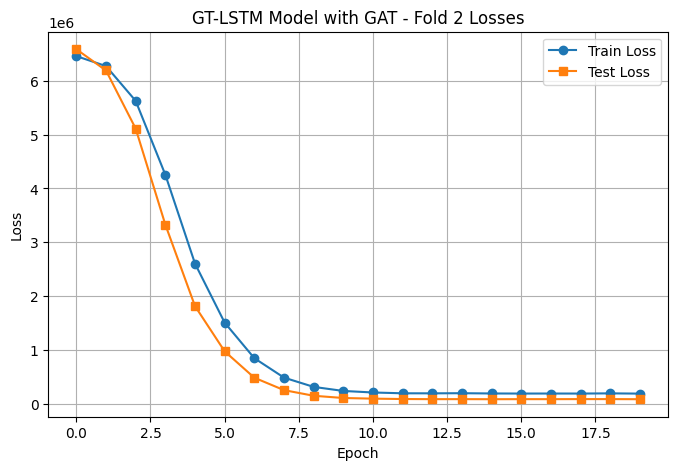


Fold 3/7 - Test Years: [np.int64(2008), np.int64(2009)]
Fold 3 Epoch [1/30] - Train Loss: 6427218.3333, Test Loss: 5987486.7500, Train RMSE: 2535.1959, Test RMSE: 2446.9340, Train R²: -5.5612, Test R²: -5.9455
Fold 3 Epoch [2/30] - Train Loss: 5895062.6875, Test Loss: 5146687.2500, Train RMSE: 2427.9750, Test RMSE: 2268.6311, Train R²: -5.0179, Test R²: -4.9702
Fold 3 Epoch [3/30] - Train Loss: 4711920.7292, Test Loss: 3625158.6250, Train RMSE: 2170.6959, Test RMSE: 1903.9849, Train R²: -3.8101, Test R²: -3.2052
Fold 3 Epoch [4/30] - Train Loss: 3027964.2188, Test Loss: 2047953.4375, Train RMSE: 1740.1046, Test RMSE: 1431.0672, Train R²: -2.0911, Test R²: -1.3756
Fold 3 Epoch [5/30] - Train Loss: 1725209.1875, Test Loss: 1138056.0000, Train RMSE: 1313.4722, Test RMSE: 1066.7971, Train R²: -0.7612, Test R²: -0.3201
Fold 3 Epoch [6/30] - Train Loss: 949106.5365, Test Loss: 545412.6875, Train RMSE: 974.2210, Test RMSE: 738.5206, Train R²: 0.0311, Test R²: 0.3673
Fold 3 Epoch [7/30] - Tra

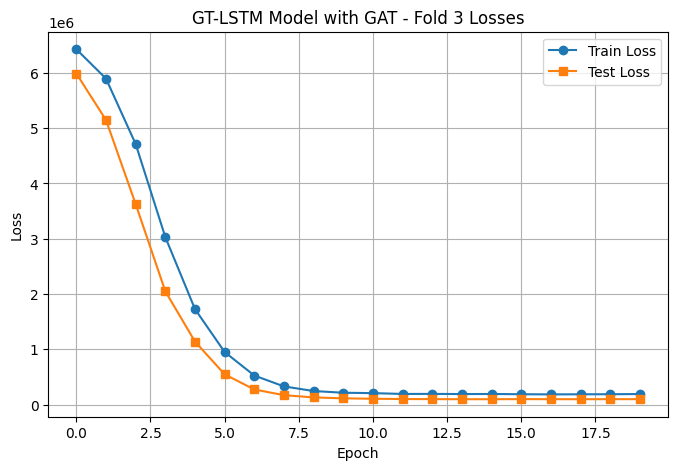


Fold 4/7 - Test Years: [np.int64(2010), np.int64(2011)]
Fold 4 Epoch [1/30] - Train Loss: 6299870.3542, Test Loss: 7445355.0000, Train RMSE: 2509.9542, Test RMSE: 2728.6179, Train R²: -5.6143, Test R²: -6.0657
Fold 4 Epoch [2/30] - Train Loss: 6047661.0208, Test Loss: 6915566.2500, Train RMSE: 2459.1993, Test RMSE: 2629.7465, Train R²: -5.3495, Test R²: -5.5629
Fold 4 Epoch [3/30] - Train Loss: 5296151.0833, Test Loss: 5643930.7500, Train RMSE: 2301.3368, Test RMSE: 2375.6958, Train R²: -4.5605, Test R²: -4.3561
Fold 4 Epoch [4/30] - Train Loss: 3855926.9583, Test Loss: 3673593.5000, Train RMSE: 1963.6514, Test RMSE: 1916.6620, Train R²: -3.0484, Test R²: -2.4863
Fold 4 Epoch [5/30] - Train Loss: 2265537.7188, Test Loss: 2026488.5000, Train RMSE: 1505.1703, Test RMSE: 1423.5479, Train R²: -1.3786, Test R²: -0.9232
Fold 4 Epoch [6/30] - Train Loss: 1295544.1927, Test Loss: 1161072.6250, Train RMSE: 1138.2197, Test RMSE: 1077.5308, Train R²: -0.3602, Test R²: -0.1019
Fold 4 Epoch [7/30]

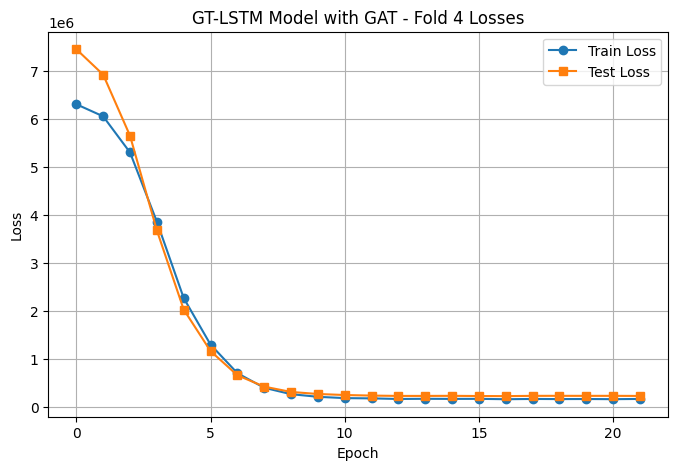


Fold 5/7 - Test Years: [np.int64(2012), np.int64(2013)]
Fold 5 Epoch [1/30] - Train Loss: 6349783.6667, Test Loss: 6913235.0000, Train RMSE: 2519.8777, Test RMSE: 2629.3032, Train R²: -5.3628, Test R²: -8.9793
Fold 5 Epoch [2/30] - Train Loss: 5973033.9792, Test Loss: 6180136.2500, Train RMSE: 2443.9791, Test RMSE: 2485.9880, Train R²: -4.9853, Test R²: -7.9211
Fold 5 Epoch [3/30] - Train Loss: 4954321.7292, Test Loss: 4602005.2500, Train RMSE: 2225.8305, Test RMSE: 2145.2285, Train R²: -3.9645, Test R²: -5.6430
Fold 5 Epoch [4/30] - Train Loss: 3334979.6250, Test Loss: 2758486.5000, Train RMSE: 1826.1927, Test RMSE: 1660.8692, Train R²: -2.3418, Test R²: -2.9819
Fold 5 Epoch [5/30] - Train Loss: 2079568.0521, Test Loss: 1689982.0000, Train RMSE: 1442.0708, Test RMSE: 1299.9931, Train R²: -1.0838, Test R²: -1.4395
Fold 5 Epoch [6/30] - Train Loss: 1285110.1771, Test Loss: 1051035.3438, Train RMSE: 1133.6270, Test RMSE: 1025.2001, Train R²: -0.2877, Test R²: -0.5172
Fold 5 Epoch [7/30]

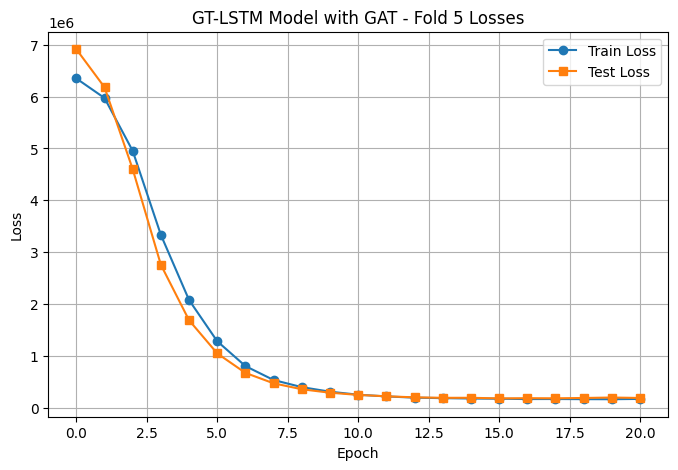


Fold 6/7 - Test Years: [np.int64(2014), np.int64(2015)]
Fold 6 Epoch [1/30] - Train Loss: 6717650.5000, Test Loss: 4341365.6250, Train RMSE: 2591.8431, Test RMSE: 2083.5944, Train R²: -5.7455, Test R²: -4.3505
Fold 6 Epoch [2/30] - Train Loss: 6172955.6667, Test Loss: 3667455.2500, Train RMSE: 2484.5433, Test RMSE: 1915.0602, Train R²: -5.1986, Test R²: -3.5200
Fold 6 Epoch [3/30] - Train Loss: 4886835.1667, Test Loss: 2543428.8750, Train RMSE: 2210.6187, Test RMSE: 1594.8131, Train R²: -3.9071, Test R²: -2.1346
Fold 6 Epoch [4/30] - Train Loss: 3060687.5208, Test Loss: 1829123.7500, Train RMSE: 1749.4821, Test RMSE: 1352.4510, Train R²: -2.0734, Test R²: -1.2543
Fold 6 Epoch [5/30] - Train Loss: 1694431.5208, Test Loss: 1372386.1875, Train RMSE: 1301.7033, Test RMSE: 1171.4889, Train R²: -0.7015, Test R²: -0.6914
Fold 6 Epoch [6/30] - Train Loss: 840378.4740, Test Loss: 1049175.0938, Train RMSE: 916.7216, Test RMSE: 1024.2925, Train R²: 0.1561, Test R²: -0.2931
Fold 6 Epoch [7/30] - 

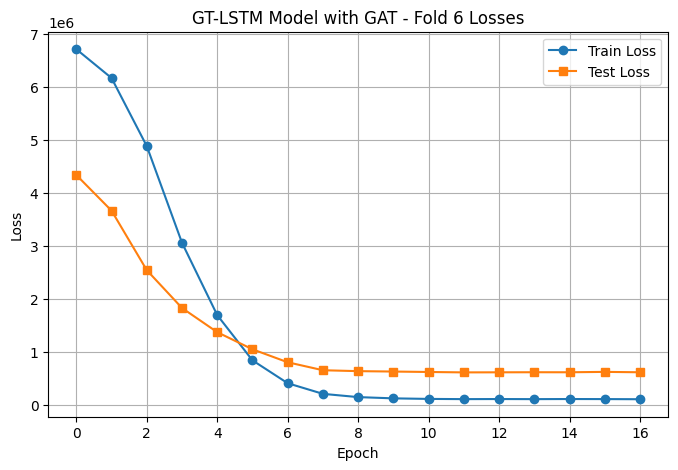


Fold 7/7 - Test Years: [np.int64(2016), np.int64(2017)]
Fold 7 Epoch [1/30] - Train Loss: 6397780.0417, Test Loss: 6787726.5000, Train RMSE: 2529.3833, Test RMSE: 2605.3266, Train R²: -5.7611, Test R²: -9.5937
Fold 7 Epoch [2/30] - Train Loss: 6095547.0417, Test Loss: 6168335.2500, Train RMSE: 2468.9162, Test RMSE: 2483.6133, Train R²: -5.4417, Test R²: -8.6270
Fold 7 Epoch [3/30] - Train Loss: 5230706.6250, Test Loss: 4793990.2500, Train RMSE: 2287.0738, Test RMSE: 2189.5183, Train R²: -4.5277, Test R²: -6.4820
Fold 7 Epoch [4/30] - Train Loss: 3756836.7396, Test Loss: 2952870.3750, Train RMSE: 1938.2561, Test RMSE: 1718.3918, Train R²: -2.9702, Test R²: -3.6086
Fold 7 Epoch [5/30] - Train Loss: 2313305.3646, Test Loss: 1686777.0000, Train RMSE: 1520.9554, Test RMSE: 1298.7598, Train R²: -1.4447, Test R²: -1.6326
Fold 7 Epoch [6/30] - Train Loss: 1433707.3177, Test Loss: 974554.2812, Train RMSE: 1197.3752, Test RMSE: 987.1952, Train R²: -0.5151, Test R²: -0.5210
Fold 7 Epoch [7/30] -

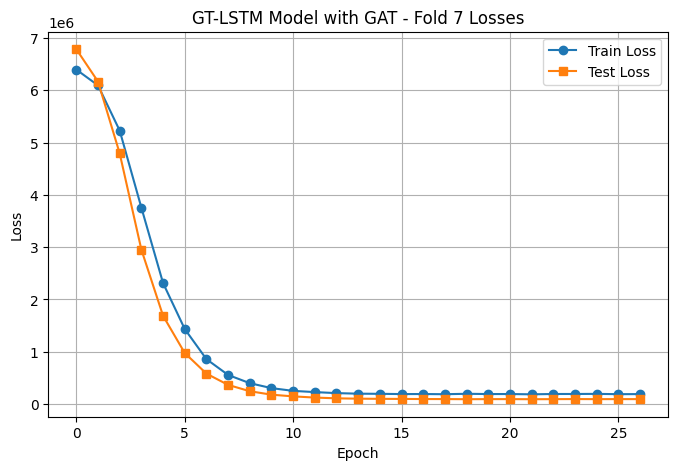


Overall Cross-Validation Metrics:
Average Train RMSE: 409.9192 (±35.6447)
Average Train R²: 0.8245 (±0.0296)
Average Test RMSE: 412.3602 (±167.8146)
Average Test R²: 0.7588 (±0.2207)
Cross-validation results saved to /content/gt_lstm_cv_yield_predictions_with_gat2.csv


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from torch_geometric.nn import GATConv

# Set seeds for reproducibility
SEED = 4
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Climate Data
climate_data = pd.read_csv('/content/cp_soil_static_idx_7M_701grids_2004.csv')
climate_data_values = climate_data.values  # [9814, 84]
scaler_cp = StandardScaler()
climate_data_normalized = scaler_cp.fit_transform(climate_data_values)
climate_data_reshaped = climate_data_normalized.reshape(9814, 12, 7).transpose(0, 2, 1)  # [9814, 7, 12]
climate_data_tensor = torch.tensor(climate_data_reshaped, dtype=torch.float32).view(14, 701, 7, 12)  # [14, 701, 7, 12]

# Remote Sensing Data
rs_data = pd.read_csv('/content/rs_701_2004.csv')
rs_data_values = rs_data.values  # [9814, 21]
scaler_rs = StandardScaler()
rs_data_normalized = scaler_rs.fit_transform(rs_data_values)
rs_data_reshaped = rs_data_normalized.reshape(9814, 3, 7).transpose(0, 2, 1)  # [9814, 7, 3]
rs_data_tensor = torch.tensor(rs_data_reshaped, dtype=torch.float32).view(14, 701, 7, 3)  # [14, 701, 7, 3]

# Yield Data
yield_file_path = '/content/detrended_district_yearly_yield_6s_2004_128g.csv'
yield_data = pd.read_csv(yield_file_path)
district_names = yield_data['District'].unique()
district_name_to_index = {name: idx for idx, name in enumerate(district_names)}
yield_data['District'] = yield_data['District'].map(district_name_to_index)
yield_values = yield_data[['Year', 'Detrended_Yield', 'District', 'Trend', 'Actual']].values
years = yield_values[:, 0].astype(int)
detrended_yields = yield_values[:, 1]
districts = yield_values[:, 2].astype(int)
trends = yield_values[:, 3]
actual_yields = yield_values[:, 4]
district_mapping_df = pd.DataFrame(list(district_name_to_index.items()), columns=['District_Name', 'District_Index'])
district_mapping_df.to_csv('/content/district_name_to_index.csv', index=False)

num_districts = 128
num_years = 14
district_yields = np.zeros((num_districts, num_years))
trends_per_district = np.zeros((num_districts, num_years))
actual_yields_per_district = np.zeros((num_districts, num_years))
for i in range(len(years)):
    district_index = districts[i]
    year_index = years[i] - 2004
    district_yields[district_index, year_index] = detrended_yields[i]
    trends_per_district[district_index, year_index] = trends[i]
    actual_yields_per_district[district_index, year_index] = actual_yields[i]

district_yields_tensor = torch.tensor(district_yields, dtype=torch.float32)  # [128, 14]
trends_tensor = torch.tensor(trends_per_district, dtype=torch.float32)  # [128, 14]
actual_yields_tensor = torch.tensor(actual_yields_per_district, dtype=torch.float32)  # [128, 14]

# Define the GT-LSTM Model with a single GAT layer
class GTLSTMYieldPrediction(nn.Module):
    def __init__(self, num_grids=701, num_districts=128, climate_features=12, rs_features=3,
                 hidden_dim=256, embedding_size=128, num_layers=2, num_heads=2):
        super(GTLSTMYieldPrediction, self).__init__()
        self.num_grids = num_grids
        self.num_districts = num_districts
        self.embedding_size = embedding_size

        # LSTM for climate data
        self.climate_lstm = nn.LSTM(input_size=climate_features, hidden_size=hidden_dim,
                                    num_layers=num_layers, batch_first=True)

        # LSTM for remote sensing data
        self.rs_lstm = nn.LSTM(input_size=rs_features, hidden_size=hidden_dim,
                               num_layers=num_layers, batch_first=True)

        # Dense layer to reduce combined LSTM outputs to embedding size
        self.dense = nn.Sequential(
            nn.Linear(hidden_dim * 2, embedding_size),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        # Learnable grid edge weights
        self.grid_edge_weights = nn.Parameter(torch.randn(num_grids, num_grids))  # [701, 701]

        # Single GAT layer
        self.gat = GATConv(
            in_channels=embedding_size,
            out_channels=embedding_size,
            heads=num_heads,
            dropout=0.1
        )
        self.norm2 = nn.LayerNorm(embedding_size * num_heads)

        # MLP to predict grid-level yields
        self.grid_mlp = nn.Sequential(
            nn.Linear(embedding_size * num_heads, 64),  # num_heads * embedding_size -> 64 (e.g., 2 * 128 = 256 -> 64)
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1)                           # 64 -> 1 (grid-level yield)
        )

        # District weights for aggregation
        self.district_weights = nn.Parameter(torch.randn(num_districts, num_grids))  # [128, 701]

    def forward(self, climate_data, rs_data):
        # climate_data: [701, 7, 12], rs_data: [701, 7, 3]
        climate_out, _ = self.climate_lstm(climate_data)  # [701, 7, 256]
        rs_out, _ = self.rs_lstm(rs_data)                # [701, 7, 256]
        climate_emb = climate_out[:, -1, :]              # [701, 256]
        rs_emb = rs_out[:, -1, :]                        # [701, 256]
        combined_emb = torch.cat([climate_emb, rs_emb], dim=-1)  # [701, 512]
        dense_out = self.dense(combined_emb)             # [701, 128]

        # Compute adjacency matrix and edge index dynamically
        adj_matrix = torch.sigmoid(self.grid_edge_weights)  # [701, 701], values between 0 and 1
        adj_matrix = adj_matrix * (1 - torch.eye(self.num_grids, device=adj_matrix.device))  # Remove self-loops
        edge_index = (adj_matrix > 0.9).nonzero(as_tuple=False).t().contiguous()  # [2, num_edges], threshold at 0.85

        # Apply single GAT layer
        gat_out = self.gat(dense_out, edge_index)        # [701, 128 * num_heads] (e.g., [701, 256] if num_heads=2)
        gat_out = torch.relu(gat_out)
        gat_out = self.norm2(gat_out)

        # Predict grid-level yields
        grid_yields = self.grid_mlp(gat_out)             # [701, 256] -> [701, 1]

        # Aggregate to district-level yields
        district_yields = torch.matmul(self.district_weights, grid_yields)  # [128, 701] × [701, 1] -> [128, 1]

        return district_yields

# Cross-validation setup
n_splits = 7
years_per_fold = num_years // n_splits  # 2 years per fold
year_indices = np.arange(num_years)
fold_year_blocks = [year_indices[i * years_per_fold:(i + 1) * years_per_fold] for i in range(n_splits)]

# Metrics storage
fold_train_rmses = []
fold_train_r2s = []
fold_test_rmses = []
fold_test_r2s = []
all_results = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cross-validation loop
for fold, test_indices in enumerate(fold_year_blocks):
    print(f"\nFold {fold + 1}/{n_splits} - Test Years: {[2004 + y for y in test_indices]}")
    train_indices = np.setdiff1d(year_indices, test_indices)

    # Split data for this fold
    train_climate = climate_data_tensor[train_indices]  # [12, 701, 7, 12]
    train_rs = rs_data_tensor[train_indices]  # [12, 701, 7, 3]
    train_yields = district_yields_tensor[:, train_indices]  # [128, 12] (detrended)
    train_trends = trends_tensor[:, train_indices]  # [128, 12]
    train_actual = actual_yields_tensor[:, train_indices]  # [128, 12]
    test_climate = climate_data_tensor[test_indices]  # [2, 701, 7, 12]
    test_rs = rs_data_tensor[test_indices]  # [2, 701, 7, 3]
    test_yields = district_yields_tensor[:, test_indices]  # [128, 2] (detrended)
    test_trends = trends_tensor[:, test_indices]  # [128, 2]
    test_actual = actual_yields_tensor[:, test_indices]  # [128, 2]

    # Initialize model
    model = GTLSTMYieldPrediction().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Early stopping parameters
    patience = 5
    min_delta = 0.001
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    # Loss tracking for this fold
    train_losses = []
    test_losses = []

    # Training loop
    num_epochs = 30
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        all_train_preds = []
        all_train_targets = []
        for year_idx in range(len(train_indices)):
            climate_batch = train_climate[year_idx].to(device)
            rs_batch = train_rs[year_idx].to(device)
            trend_batch = train_trends[:, year_idx:year_idx+1].to(device)  # [128, 1]
            actual_batch = train_actual[:, year_idx:year_idx+1].to(device)  # [128, 1]
            pred = model(climate_batch, rs_batch)  # [128, 1] (detrended), edge_index computed internally
            predicted_yields = pred + trend_batch  # Add trend
            loss = criterion(predicted_yields, actual_batch)  # Compare with actual
            train_loss += loss.item()
            all_train_preds.extend(predicted_yields.detach().cpu().numpy())
            all_train_targets.extend(actual_batch.cpu().numpy())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = train_loss / len(train_indices)
        train_losses.append(avg_train_loss)
        train_rmse = np.sqrt(mean_squared_error(all_train_targets, all_train_preds))
        train_r2 = r2_score(all_train_targets, all_train_preds)

        # Test (validation) for this fold
        model.eval()
        test_loss = 0
        all_test_preds = []
        all_test_targets = []
        with torch.no_grad():
            for year_idx in range(len(test_indices)):
                climate_batch = test_climate[year_idx].to(device)
                rs_batch = test_rs[year_idx].to(device)
                trend_batch = test_trends[:, year_idx:year_idx+1].to(device)  # [128, 1]
                actual_batch = test_actual[:, year_idx:year_idx+1].to(device)  # [128, 1]
                pred = model(climate_batch, rs_batch)
                predicted_yields = pred + trend_batch
                loss = criterion(predicted_yields, actual_batch)
                test_loss += loss.item()
                all_test_preds.extend(predicted_yields.cpu().numpy())
                all_test_targets.extend(actual_batch.cpu().numpy())

        avg_test_loss = test_loss / len(test_indices)
        test_losses.append(avg_test_loss)
        test_rmse = np.sqrt(mean_squared_error(all_test_targets, all_test_preds))
        test_r2 = r2_score(all_test_targets, all_test_preds)

        print(f"Fold {fold + 1} Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, "
              f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}, Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")

        # Early stopping based on test loss
        if avg_test_loss < best_val_loss - min_delta:
            best_val_loss = avg_test_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    # Load best model for this fold
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Store fold metrics
    fold_train_rmses.append(train_rmse)
    fold_train_r2s.append(train_r2)
    fold_test_rmses.append(test_rmse)
    fold_test_r2s.append(test_r2)

    # Save predictions for this fold
    for year_idx, year in enumerate(test_indices):
        preds = all_test_preds[year_idx * num_districts:(year_idx + 1) * num_districts]
        targets = all_test_targets[year_idx * num_districts:(year_idx + 1) * num_districts]
        for district in range(num_districts):
            actual_yield = actual_yields_per_district[district, year].item()
            predicted_yield = preds[district][0] if isinstance(preds[district], np.ndarray) else preds[district]
            all_results.append({
                'Fold': fold + 1,
                'Year': 2004 + year,
                'District': district_names[district],
                'Actual_Yield': actual_yield,
                'Predicted_Yield': predicted_yield
            })

    # Plot losses for this fold
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(test_losses, label='Test Loss', marker='s')
    plt.title(f'GT-LSTM Model with GAT - Fold {fold + 1} Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Compute and print overall metrics
avg_train_rmse = np.mean(fold_train_rmses)
avg_train_r2 = np.mean(fold_train_r2s)
avg_test_rmse = np.mean(fold_test_rmses)
avg_test_r2 = np.mean(fold_test_r2s)

print("\nOverall Cross-Validation Metrics:")
print(f"Average Train RMSE: {avg_train_rmse:.4f} (±{np.std(fold_train_rmses):.4f})")
print(f"Average Train R²: {avg_train_r2:.4f} (±{np.std(fold_train_r2s):.4f})")
print(f"Average Test RMSE: {avg_test_rmse:.4f} (±{np.std(fold_test_rmses):.4f})")
print(f"Average Test R²: {avg_test_r2:.4f} (±{np.std(fold_test_r2s):.4f})")

# Save all predictions
results_df = pd.DataFrame(all_results)
results_df.to_csv('/content/gt_lstm_cv_yield_predictions_with_gat2.csv', index=False)
print(f"Cross-validation results saved to /content/gt_lstm_cv_yield_predictions_with_gat2.csv")

```
Overall Cross-Validation Metrics:
Average Train RMSE: 409.9192 (±35.6447)
Average Train R²: 0.8245 (±0.0296)
Average Test RMSE: 412.3602 (±167.8146)
Average Test R²: 0.7588 (±0.2207)
```

### Using GAT with grid_edge_index_nn10.csv

### using norm2

In [ ]:
# Load the results file
results_df = pd.read_csv('/content/gt_lstm_cv_yield_predictions_with_gat2.csv')

# Initialize dictionaries to store RMSE and R² for each year
yearly_rmse = {}
yearly_r2 = {}

# Group by year and calculate RMSE and R² for each year
for year, group in results_df.groupby('Year'):
    actual_yields = group['Actual_Yield'].values
    predicted_yields = group['Predicted_Yield'].values

    # Calculate RMSE and R²
    rmse = np.sqrt(mean_squared_error(actual_yields, predicted_yields))
    r2 = r2_score(actual_yields, predicted_yields)

    # Store the results in the dictionaries
    yearly_rmse[year] = rmse
    yearly_r2[year] = r2

# Convert the dictionaries to a DataFrame for easier viewing and visualization
yearly_metrics_df = pd.DataFrame({
    'Year': list(yearly_rmse.keys()),
    'RMSE': list(yearly_rmse.values()),
    'R2': list(yearly_r2.values())
})

# Save the yearly metrics to a CSV file
yearly_metrics_df.to_csv('/content/yearly_yield_metrics3.csv', index=False)

# Calculate and print the average yearly metrics separately
average_yearly_rmse = yearly_metrics_df['RMSE'].mean()
average_yearly_r2 = yearly_metrics_df['R2'].mean()

print("------------Yearly Metrics----------------")
print(yearly_metrics_df)
print("\n------------Average Yearly Metrics----------------")
print(f"Average yearly RMSE: {average_yearly_rmse:.4f}")
print(f"Average yearly R²: {average_yearly_r2:.4f}")



Fold 1/7 - Test Years: [np.int64(2004), np.int64(2005)]
Fold 1 Epoch [1/30] - Train Loss: 6523298.6875, Test Loss: 6382102.5000, Train RMSE: 2554.0749, Test RMSE: 2526.2824, Train R²: -5.9367, Test R²: -6.3663
Fold 1 Epoch [2/30] - Train Loss: 6510844.6875, Test Loss: 6372160.2500, Train RMSE: 2551.6357, Test RMSE: 2524.3137, Train R²: -5.9234, Test R²: -6.3548
Fold 1 Epoch [3/30] - Train Loss: 6409500.5417, Test Loss: 6284995.0000, Train RMSE: 2531.6991, Test RMSE: 2506.9892, Train R²: -5.8157, Test R²: -6.2542
Fold 1 Epoch [4/30] - Train Loss: 5898730.1250, Test Loss: 5470907.7500, Train RMSE: 2428.7302, Test RMSE: 2338.9971, Train R²: -5.2725, Test R²: -5.3146
Fold 1 Epoch [5/30] - Train Loss: 4548483.1667, Test Loss: 3277777.5000, Train RMSE: 2132.7173, Test RMSE: 1810.4633, Train R²: -3.8367, Test R²: -2.7833
Fold 1 Epoch [6/30] - Train Loss: 2825918.7708, Test Loss: 2549111.5000, Train RMSE: 1681.0469, Test RMSE: 1596.5937, Train R²: -2.0050, Test R²: -1.9422
Fold 1 Epoch [7/30]

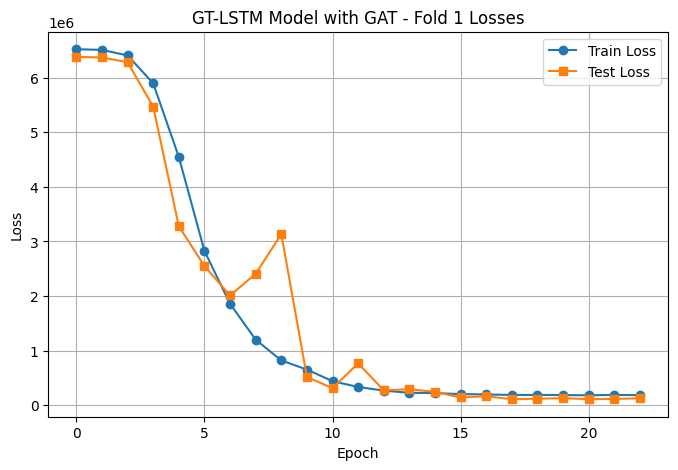


Fold 2/7 - Test Years: [np.int64(2006), np.int64(2007)]
Fold 2 Epoch [1/30] - Train Loss: 6471224.3542, Test Loss: 6657817.7500, Train RMSE: 2543.8601, Test RMSE: 2580.2748, Train R²: -5.7681, Test R²: -6.0299
Fold 2 Epoch [2/30] - Train Loss: 6387033.4375, Test Loss: 6595744.7500, Train RMSE: 2527.2581, Test RMSE: 2568.2182, Train R²: -5.6800, Test R²: -5.9644
Fold 2 Epoch [3/30] - Train Loss: 6028539.7708, Test Loss: 5854965.5000, Train RMSE: 2455.3085, Test RMSE: 2419.7036, Train R²: -5.3051, Test R²: -5.1822
Fold 2 Epoch [4/30] - Train Loss: 4970231.5000, Test Loss: 3607275.3750, Train RMSE: 2229.4016, Test RMSE: 1899.2829, Train R²: -4.1982, Test R²: -2.8089
Fold 2 Epoch [5/30] - Train Loss: 3403605.3542, Test Loss: 3257303.2500, Train RMSE: 1844.8862, Test RMSE: 1804.8000, Train R²: -2.5597, Test R²: -2.4393
Fold 2 Epoch [6/30] - Train Loss: 2073182.0938, Test Loss: 2331698.2500, Train RMSE: 1439.8549, Test RMSE: 1526.9899, Train R²: -1.1683, Test R²: -1.4620
Fold 2 Epoch [7/30]

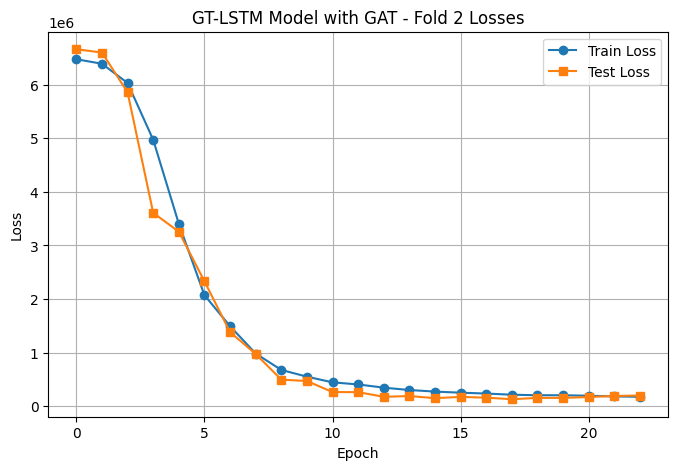


Fold 3/7 - Test Years: [np.int64(2008), np.int64(2009)]
Fold 3 Epoch [1/30] - Train Loss: 6532280.5208, Test Loss: 6290506.0000, Train RMSE: 2555.8326, Test RMSE: 2508.0881, Train R²: -5.6684, Test R²: -6.2970
Fold 3 Epoch [2/30] - Train Loss: 6448881.6458, Test Loss: 6267711.2500, Train RMSE: 2539.4649, Test RMSE: 2503.5398, Train R²: -5.5833, Test R²: -6.2706
Fold 3 Epoch [3/30] - Train Loss: 6059298.5417, Test Loss: 6012628.7500, Train RMSE: 2461.5643, Test RMSE: 2452.0662, Train R²: -5.1856, Test R²: -5.9747
Fold 3 Epoch [4/30] - Train Loss: 5113543.2708, Test Loss: 4297544.6250, Train RMSE: 2261.3145, Test RMSE: 2073.0520, Train R²: -4.2201, Test R²: -3.9852
Fold 3 Epoch [5/30] - Train Loss: 3576506.1042, Test Loss: 2520542.7500, Train RMSE: 1891.1652, Test RMSE: 1587.6217, Train R²: -2.6510, Test R²: -1.9238
Fold 3 Epoch [6/30] - Train Loss: 2330652.8750, Test Loss: 2975180.7500, Train RMSE: 1526.6476, Test RMSE: 1724.8712, Train R²: -1.3792, Test R²: -2.4512
Fold 3 Epoch [7/30]

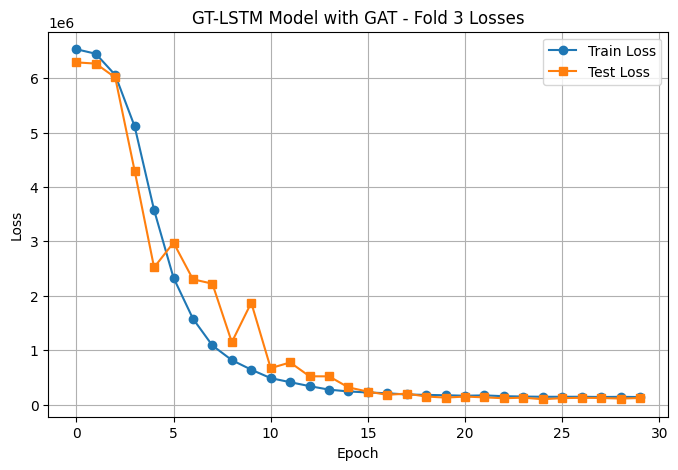


Fold 4/7 - Test Years: [np.int64(2010), np.int64(2011)]
Fold 4 Epoch [1/30] - Train Loss: 6322594.6250, Test Loss: 7564146.0000, Train RMSE: 2514.4770, Test RMSE: 2750.2993, Train R²: -5.6382, Test R²: -6.1784
Fold 4 Epoch [2/30] - Train Loss: 6272885.8333, Test Loss: 7518590.0000, Train RMSE: 2504.5730, Test RMSE: 2742.0048, Train R²: -5.5860, Test R²: -6.1352
Fold 4 Epoch [3/30] - Train Loss: 6000948.7292, Test Loss: 7045285.7500, Train RMSE: 2449.6834, Test RMSE: 2654.2957, Train R²: -5.3005, Test R²: -5.6860
Fold 4 Epoch [4/30] - Train Loss: 5128423.2708, Test Loss: 5752963.5000, Train RMSE: 2264.6022, Test RMSE: 2398.5337, Train R²: -4.3844, Test R²: -4.4596
Fold 4 Epoch [5/30] - Train Loss: 3589591.5729, Test Loss: 3626544.8750, Train RMSE: 1894.6218, Test RMSE: 1904.3490, Train R²: -2.7688, Test R²: -2.4416
Fold 4 Epoch [6/30] - Train Loss: 2479650.6562, Test Loss: 8919145.5000, Train RMSE: 1574.6907, Test RMSE: 2986.4938, Train R²: -1.6034, Test R²: -7.4644
Fold 4 Epoch [7/30]

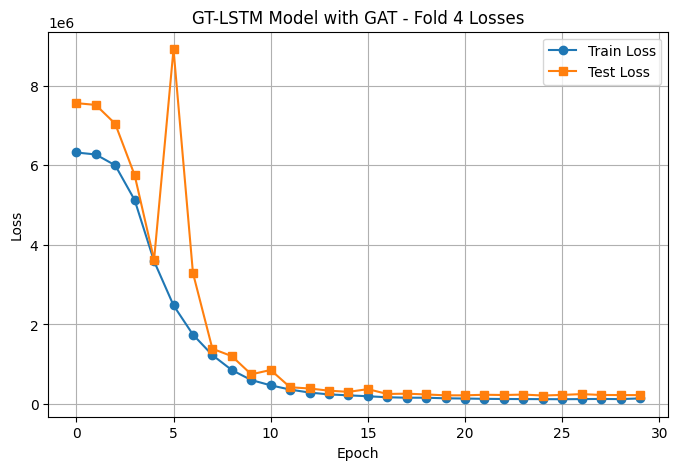


Fold 5/7 - Test Years: [np.int64(2012), np.int64(2013)]
Fold 5 Epoch [1/30] - Train Loss: 6405389.1875, Test Loss: 7099241.5000, Train RMSE: 2530.8870, Test RMSE: 2664.4402, Train R²: -5.4185, Test R²: -9.2478
Fold 5 Epoch [2/30] - Train Loss: 6393984.2708, Test Loss: 7090449.5000, Train RMSE: 2528.6329, Test RMSE: 2662.7898, Train R²: -5.4071, Test R²: -9.2351
Fold 5 Epoch [3/30] - Train Loss: 6315051.9792, Test Loss: 7045403.0000, Train RMSE: 2512.9767, Test RMSE: 2654.3178, Train R²: -5.3280, Test R²: -9.1701
Fold 5 Epoch [4/30] - Train Loss: 5892449.7500, Test Loss: 6298716.7500, Train RMSE: 2427.4369, Test RMSE: 2509.7245, Train R²: -4.9045, Test R²: -8.0923
Fold 5 Epoch [5/30] - Train Loss: 4716347.2292, Test Loss: 3703025.8750, Train RMSE: 2171.7153, Test RMSE: 1924.3248, Train R²: -3.7260, Test R²: -4.3454
Fold 5 Epoch [6/30] - Train Loss: 3060394.0729, Test Loss: 4303887.1250, Train RMSE: 1749.3982, Test RMSE: 2074.5811, Train R²: -2.0667, Test R²: -5.2127
Fold 5 Epoch [7/30]

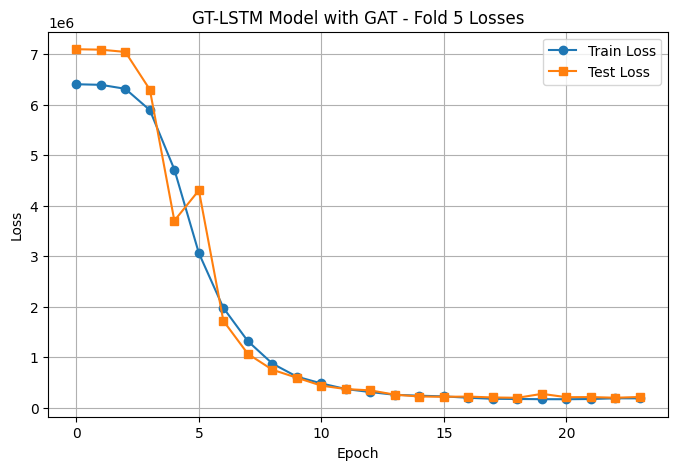


Fold 6/7 - Test Years: [np.int64(2014), np.int64(2015)]
Fold 6 Epoch [1/30] - Train Loss: 6823622.4583, Test Loss: 4571902.2500, Train RMSE: 2612.2064, Test RMSE: 2138.2007, Train R²: -5.8519, Test R²: -4.6346
Fold 6 Epoch [2/30] - Train Loss: 6789217.2917, Test Loss: 4558999.8750, Train RMSE: 2605.6126, Test RMSE: 2135.1814, Train R²: -5.8174, Test R²: -4.6187
Fold 6 Epoch [3/30] - Train Loss: 6572242.4583, Test Loss: 4377053.6250, Train RMSE: 2563.6385, Test RMSE: 2092.1409, Train R²: -5.5995, Test R²: -4.3945
Fold 6 Epoch [4/30] - Train Loss: 5774074.2917, Test Loss: 3318715.5000, Train RMSE: 2402.9304, Test RMSE: 1821.7342, Train R²: -4.7980, Test R²: -3.0901
Fold 6 Epoch [5/30] - Train Loss: 4100741.8542, Test Loss: 2436664.3750, Train RMSE: 2025.0289, Test RMSE: 1560.9818, Train R²: -3.1178, Test R²: -2.0031
Fold 6 Epoch [6/30] - Train Loss: 2517152.1771, Test Loss: 3128563.3750, Train RMSE: 1586.5535, Test RMSE: 1768.7745, Train R²: -1.5276, Test R²: -2.8558
Fold 6 Epoch [7/30]

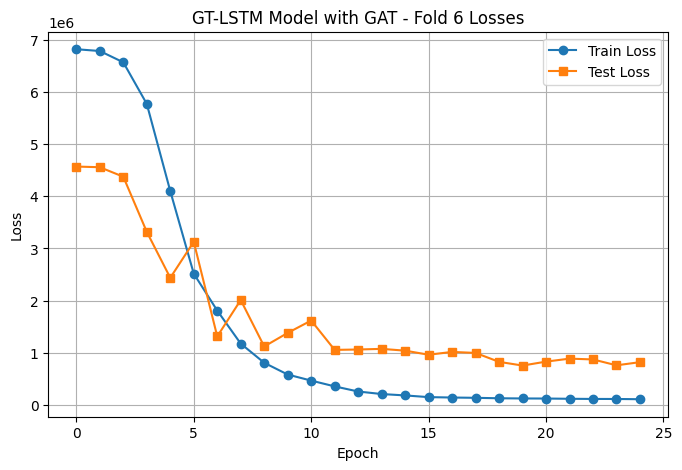


Fold 7/7 - Test Years: [np.int64(2016), np.int64(2017)]
Fold 7 Epoch [1/30] - Train Loss: 6423545.5000, Test Loss: 6926255.5000, Train RMSE: 2534.4714, Test RMSE: 2631.7780, Train R²: -5.7883, Test R²: -9.8099
Fold 7 Epoch [2/30] - Train Loss: 6330417.8958, Test Loss: 6840449.5000, Train RMSE: 2516.0322, Test RMSE: 2615.4253, Train R²: -5.6899, Test R²: -9.6759
Fold 7 Epoch [3/30] - Train Loss: 5896320.7917, Test Loss: 6291127.0000, Train RMSE: 2428.2341, Test RMSE: 2508.2120, Train R²: -5.2311, Test R²: -8.8186
Fold 7 Epoch [4/30] - Train Loss: 4784779.0000, Test Loss: 3886765.7500, Train RMSE: 2187.4138, Test RMSE: 1971.4882, Train R²: -4.0565, Test R²: -5.0661
Fold 7 Epoch [5/30] - Train Loss: 3189462.1771, Test Loss: 2904128.2500, Train RMSE: 1785.9065, Test RMSE: 1704.1503, Train R²: -2.3706, Test R²: -3.5325
Fold 7 Epoch [6/30] - Train Loss: 2059132.7083, Test Loss: 1353198.4375, Train RMSE: 1434.9678, Test RMSE: 1163.2706, Train R²: -1.1761, Test R²: -1.1119
Fold 7 Epoch [7/30]

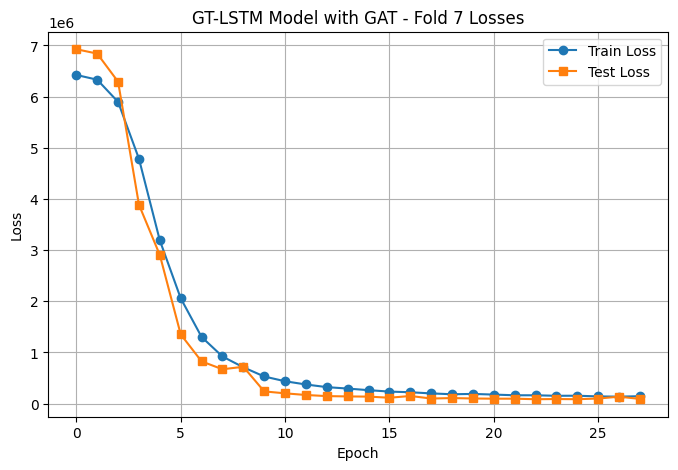


Overall Cross-Validation Metrics:
Average Train RMSE: 389.9151 (±34.8528)
Average Train R²: 0.8412 (±0.0286)
Average Test RMSE: 469.3919 (±187.6997)
Average Test R²: 0.6911 (±0.2908)
Cross-validation results saved to /content/gt_lstm_cv_yield_predictions_with_gat2.csv


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from torch_geometric.nn import GATConv  # Replaced GraphSAGE with GATConv

# Set seeds for reproducibility
SEED = 8
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Climate Data
climate_data = pd.read_csv('/content/cp_soil_static_idx_7M_701grids_2004.csv')
climate_data_values = climate_data.values  # [9814, 84]
scaler_cp = StandardScaler()
climate_data_normalized = scaler_cp.fit_transform(climate_data_values)
climate_data_reshaped = climate_data_normalized.reshape(9814, 12, 7).transpose(0, 2, 1)  # [9814, 7, 12]
climate_data_tensor = torch.tensor(climate_data_reshaped, dtype=torch.float32).view(14, 701, 7, 12)  # [14, 701, 7, 12]

# Remote Sensing Data
rs_data = pd.read_csv('/content/rs_701_2004.csv')
rs_data_values = rs_data.values  # [9814, 21]
scaler_rs = StandardScaler()
rs_data_normalized = scaler_rs.fit_transform(rs_data_values)
rs_data_reshaped = rs_data_normalized.reshape(9814, 3, 7).transpose(0, 2, 1)  # [9814, 7, 3]
rs_data_tensor = torch.tensor(rs_data_reshaped, dtype=torch.float32).view(14, 701, 7, 3)  # [14, 701, 7, 3]

# Yield Data
yield_file_path = '/content/detrended_district_yearly_yield_6s_2004_128g.csv'
yield_data = pd.read_csv(yield_file_path)
district_names = yield_data['District'].unique()
district_name_to_index = {name: idx for idx, name in enumerate(district_names)}
yield_data['District'] = yield_data['District'].map(district_name_to_index)
yield_values = yield_data[['Year', 'Detrended_Yield', 'District', 'Trend', 'Actual']].values
years = yield_values[:, 0].astype(int)
detrended_yields = yield_values[:, 1]
districts = yield_values[:, 2].astype(int)
trends = yield_values[:, 3]
actual_yields = yield_values[:, 4]
district_mapping_df = pd.DataFrame(list(district_name_to_index.items()), columns=['District_Name', 'District_Index'])
district_mapping_df.to_csv('/content/district_name_to_index.csv', index=False)

num_districts = 128
num_years = 14
district_yields = np.zeros((num_districts, num_years))
trends_per_district = np.zeros((num_districts, num_years))
actual_yields_per_district = np.zeros((num_districts, num_years))
for i in range(len(years)):
    district_index = districts[i]
    year_index = years[i] - 2004
    district_yields[district_index, year_index] = detrended_yields[i]
    trends_per_district[district_index, year_index] = trends[i]
    actual_yields_per_district[district_index, year_index] = actual_yields[i]

district_yields_tensor = torch.tensor(district_yields, dtype=torch.float32)  # [128, 14]
trends_tensor = torch.tensor(trends_per_district, dtype=torch.float32)  # [128, 14]
actual_yields_tensor = torch.tensor(actual_yields_per_district, dtype=torch.float32)  # [128, 14]

# Load saved edge index
edge_index_df = pd.read_csv("/content/grid_edge_index_nn10_haversine.csv")
grid_edge_index = torch.tensor(edge_index_df.values, dtype=torch.long).t().contiguous()  # [2, 7010]

# Define the GT-LSTM Model with GAT
class GTLSTMYieldPrediction(nn.Module):
    def __init__(self, num_grids=701, num_districts=128, climate_features=12, rs_features=3,
                 hidden_dim=256, embedding_size=128, num_layers=2, num_heads=2):
        super(GTLSTMYieldPrediction, self).__init__()
        self.num_grids = num_grids
        self.num_districts = num_districts

        # LSTM for climate data
        self.climate_lstm = nn.LSTM(input_size=climate_features, hidden_size=hidden_dim,
                                    num_layers=num_layers, batch_first=True)

        # LSTM for remote sensing data
        self.rs_lstm = nn.LSTM(input_size=rs_features, hidden_size=hidden_dim,
                               num_layers=num_layers, batch_first=True)

        # Dense layer to reduce combined LSTM outputs to embedding size
        self.dense = nn.Sequential(
            nn.Linear(hidden_dim * 2, embedding_size),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        # GAT layer with 8 heads
        self.gat = GATConv(
            in_channels=embedding_size,       # 128
            out_channels=embedding_size,      # 128
            heads=num_heads,                  # 8 heads
            concat=True,                      # Concatenate heads: 128 * 8 = 1024 output
            dropout=0.1
        )
        self.norm2 = nn.BatchNorm1d(embedding_size * num_heads)
        # MLP to predict grid-level yields, adjusted for GAT output
        self.grid_mlp = nn.Sequential(
            nn.Linear(embedding_size * num_heads, 128),  # 1024 -> 64
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 1)                          # 64 -> 1 (grid-level yield)
        )

        # District weights for aggregation
        self.district_weights = nn.Parameter(torch.randn(num_districts, num_grids))  # [128, 701]

    def forward(self, climate_data, rs_data, edge_index):
        # climate_data: [701, 7, 12], rs_data: [701, 7, 3]
        climate_out, _ = self.climate_lstm(climate_data)  # [701, 7, 256]
        rs_out, _ = self.rs_lstm(rs_data)                # [701, 7, 256]
        climate_emb = climate_out[:, -1, :]              # [701, 256]
        rs_emb = rs_out[:, -1, :]                        # [701, 256]
        combined_emb = torch.cat([climate_emb, rs_emb], dim=-1)  # [701, 512]
        dense_out = self.dense(combined_emb)             # [701, 128]

        # Apply GAT
        gat_out = self.gat(dense_out, edge_index)        # [701, 128 * 8] = [701, 1024]
        gat_out = F.relu(gat_out)
        gat_out = self.norm2(gat_out)                    # [701, 1024]


        # Predict grid-level yields
        grid_yields = self.grid_mlp(gat_out)             # [701, 1024] -> [701, 1]

        # Aggregate to district-level yields
        district_yields = torch.matmul(self.district_weights, grid_yields)  # [128, 701] × [701, 1] -> [128, 1]

        return district_yields

# Cross-validation setup
n_splits = 7
years_per_fold = num_years // n_splits  # 2 years per fold
year_indices = np.arange(num_years)
fold_year_blocks = [year_indices[i * years_per_fold:(i + 1) * years_per_fold] for i in range(n_splits)]

# Metrics storage
fold_train_rmses = []
fold_train_r2s = []
fold_test_rmses = []
fold_test_r2s = []
all_results = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Cross-validation loop
for fold, test_indices in enumerate(fold_year_blocks):
    print(f"\nFold {fold + 1}/{n_splits} - Test Years: {[2004 + y for y in test_indices]}")
    train_indices = np.setdiff1d(year_indices, test_indices)

    # Split data for this fold
    train_climate = climate_data_tensor[train_indices]  # [12, 701, 7, 12]
    train_rs = rs_data_tensor[train_indices]  # [12, 701, 7, 3]
    train_yields = district_yields_tensor[:, train_indices]  # [128, 12] (detrended)
    train_trends = trends_tensor[:, train_indices]  # [128, 12]
    train_actual = actual_yields_tensor[:, train_indices]  # [128, 12]
    test_climate = climate_data_tensor[test_indices]  # [2, 701, 7, 12]
    test_rs = rs_data_tensor[test_indices]  # [2, 701, 7, 3]
    test_yields = district_yields_tensor[:, test_indices]  # [128, 2] (detrended)
    test_trends = trends_tensor[:, test_indices]  # [128, 2]
    test_actual = actual_yields_tensor[:, test_indices]  # [128, 2]

    # Initialize model
    model = GTLSTMYieldPrediction().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Early stopping parameters
    patience = 5
    min_delta = 0.001
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    # Loss tracking for this fold
    train_losses = []
    test_losses = []

    # Training loop
    num_epochs = 30
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        all_train_preds = []  # Predicted + Trend
        all_train_targets = []  # Actual yields
        for year_idx in range(len(train_indices)):
            climate_batch = train_climate[year_idx].to(device)
            rs_batch = train_rs[year_idx].to(device)
            trend_batch = train_trends[:, year_idx:year_idx+1].to(device)  # [128, 1]
            actual_batch = train_actual[:, year_idx:year_idx+1].to(device)  # [128, 1]
            edge_index = grid_edge_index.to(device)
            pred = model(climate_batch, rs_batch, edge_index)  # [128, 1] (detrended)
            predicted_yields = pred + trend_batch  # Add trend
            loss = criterion(predicted_yields, actual_batch)  # Compare with actual
            train_loss += loss.item()
            all_train_preds.extend(predicted_yields.detach().cpu().numpy())
            all_train_targets.extend(actual_batch.cpu().numpy())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = train_loss / len(train_indices)
        train_losses.append(avg_train_loss)
        train_rmse = np.sqrt(mean_squared_error(all_train_targets, all_train_preds))
        train_r2 = r2_score(all_train_targets, all_train_preds)

        # Test (validation) for this fold
        model.eval()
        test_loss = 0
        all_test_preds = []
        all_test_targets = []
        with torch.no_grad():
            for year_idx in range(len(test_indices)):
                climate_batch = test_climate[year_idx].to(device)
                rs_batch = test_rs[year_idx].to(device)
                trend_batch = test_trends[:, year_idx:year_idx+1].to(device)  # [128, 1]
                actual_batch = test_actual[:, year_idx:year_idx+1].to(device)  # [128, 1]
                pred = model(climate_batch, rs_batch, edge_index)
                predicted_yields = pred + trend_batch
                loss = criterion(predicted_yields, actual_batch)
                test_loss += loss.item()
                all_test_preds.extend(predicted_yields.cpu().numpy())
                all_test_targets.extend(actual_batch.cpu().numpy())

        avg_test_loss = test_loss / len(test_indices)
        test_losses.append(avg_test_loss)
        test_rmse = np.sqrt(mean_squared_error(all_test_targets, all_test_preds))
        test_r2 = r2_score(all_test_targets, all_test_preds)

        print(f"Fold {fold + 1} Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, "
              f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}, Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")

        # Early stopping based on test loss
        if avg_test_loss < best_val_loss - min_delta:
            best_val_loss = avg_test_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    # Load best model for this fold
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Store fold metrics
    fold_train_rmses.append(train_rmse)
    fold_train_r2s.append(train_r2)
    fold_test_rmses.append(test_rmse)
    fold_test_r2s.append(test_r2)

    # Save predictions for this fold
    for year_idx, year in enumerate(test_indices):
        preds = all_test_preds[year_idx * num_districts:(year_idx + 1) * num_districts]
        targets = all_test_targets[year_idx * num_districts:(year_idx + 1) * num_districts]
        for district in range(num_districts):
            actual_yield = actual_yields_per_district[district, year].item()
            predicted_yield = preds[district][0] if isinstance(preds[district], np.ndarray) else preds[district]
            all_results.append({
                'Fold': fold + 1,
                'Year': 2004 + year,
                'District': district_names[district],
                'Actual_Yield': actual_yield,
                'Predicted_Yield': predicted_yield
            })

    # Plot losses for this fold
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(test_losses, label='Test Loss', marker='s')
    plt.title(f'GT-LSTM Model with GAT - Fold {fold + 1} Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Compute and print overall metrics
avg_train_rmse = np.mean(fold_train_rmses)
avg_train_r2 = np.mean(fold_train_r2s)
avg_test_rmse = np.mean(fold_test_rmses)
avg_test_r2 = np.mean(fold_test_r2s)

print("\nOverall Cross-Validation Metrics:")
print(f"Average Train RMSE: {avg_train_rmse:.4f} (±{np.std(fold_train_rmses):.4f})")
print(f"Average Train R²: {avg_train_r2:.4f} (±{np.std(fold_train_r2s):.4f})")
print(f"Average Test RMSE: {avg_test_rmse:.4f} (±{np.std(fold_test_rmses):.4f})")
print(f"Average Test R²: {avg_test_r2:.4f} (±{np.std(fold_test_r2s):.4f})")

# Save all predictions
results_df = pd.DataFrame(all_results)
results_df.to_csv('/content/gt_lstm_cv_yield_predictions_with_gat2.csv', index=False)
print(f"Cross-validation results saved to /content/gt_lstm_cv_yield_predictions_with_gat2.csv")

In [ ]:
# Load the results file
results_df = pd.read_csv('/content/gt_lstm_cv_yield_predictions_with_gat2.csv')

# Initialize dictionaries to store RMSE and R² for each year
yearly_rmse = {}
yearly_r2 = {}

# Group by year and calculate RMSE and R² for each year
for year, group in results_df.groupby('Year'):
    actual_yields = group['Actual_Yield'].values
    predicted_yields = group['Predicted_Yield'].values

    # Calculate RMSE and R²
    rmse = np.sqrt(mean_squared_error(actual_yields, predicted_yields))
    r2 = r2_score(actual_yields, predicted_yields)

    # Store the results in the dictionaries
    yearly_rmse[year] = rmse
    yearly_r2[year] = r2

# Convert the dictionaries to a DataFrame for easier viewing and visualization
yearly_metrics_df = pd.DataFrame({
    'Year': list(yearly_rmse.keys()),
    'RMSE': list(yearly_rmse.values()),
    'R2': list(yearly_r2.values())
})

# Save the yearly metrics to a CSV file
yearly_metrics_df.to_csv('/content/yearly_yield_metrics3.csv', index=False)

# Calculate and print the average yearly metrics separately
average_yearly_rmse = yearly_metrics_df['RMSE'].mean()
average_yearly_r2 = yearly_metrics_df['R2'].mean()

print("------------Yearly Metrics----------------")
print(yearly_metrics_df)
print("\n------------Average Yearly Metrics----------------")
print(f"Average yearly RMSE: {average_yearly_rmse:.4f}")
print(f"Average yearly R²: {average_yearly_r2:.4f}")


------------Yearly Metrics----------------
    Year         RMSE        R2
0   2004   362.683026  0.843179
1   2005   293.510025  0.903581
2   2006   300.816907  0.893456
3   2007   349.765031  0.882843
4   2008   534.059615  0.696485
5   2009   355.692120  0.838688
6   2010   391.798793  0.850405
7   2011   448.824187  0.804482
8   2012   424.084869  0.698868
9   2013   384.567315  0.811914
10  2014  1078.353702 -0.445663
11  2015   856.559787  0.024463
12  2016   312.511884  0.849447
13  2017   336.674031  0.820073

------------Average Yearly Metrics----------------
Average yearly RMSE: 459.2787
Average yearly R²: 0.6766


## MAPS Top 10 imp grids

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Load grid information (Longitude, Latitude, District)
grid_info_df = pd.read_csv("/content/lon_lat_701grids.csv")

# Create a dictionary mapping grid index → district name
grid_index_to_district = dict(enumerate(grid_info_df["District"].values))

# Load district name to index mapping
district_mapping_df = pd.read_csv("/content/district_name_to_index.csv")

# Create a dictionary to map index -> district name
index_to_district_name = dict(zip(district_mapping_df["District_Index"], district_mapping_df["District_Name"]))

# Load the centroid information
district_centroid_df = pd.read_csv("/content/filtered_district_centroid_701_128dist.csv")

# Assuming model.district_weights is available (from the trained model)
grid_importance = model.district_weights.detach().cpu().numpy()

# Districts to be plotted (5 separate maps)
selected_district_indices = [46, 104, 55, 116, 96]

# Define colors for centroids
centroid_colors = ["red", "yellow", "green", "purple", "orange"]

# Loop through each district and create a separate figure
for idx, district_index in enumerate(selected_district_indices):
    district_name = index_to_district_name.get(district_index, f"District {district_index}")
    district_weights = grid_importance[district_index]
    absolute_weights = np.abs(district_weights)

    # Get the indices of the top 10 grids
    top_10_indices = np.argsort(-absolute_weights)[:5]  # Sort in descending order and take the top 10

    # Get grid info for the top 10 grids
    selected_grids_info = grid_info_df.iloc[top_10_indices][["Lon", "Lat", "District"]]
    selected_grids_info.columns = ["Longitude", "Latitude", "District"]

    # Get centroid information
    district_centroid = district_centroid_df[district_centroid_df["DISTRICT"] == district_name]
    if district_centroid.empty:
        print(f"Skipping {district_name}, centroid not found.")
        continue

    district_centroid_lon = district_centroid["Longitude"].values[0]
    district_centroid_lat = district_centroid["Latitude"].values[0]

    num_connected_grids = len(selected_grids_info)

    # Create a new figure for each district
    fig = go.Figure()

    # Add lines from centroid to grid points
    for i in range(len(selected_grids_info)):
        delta_lat = selected_grids_info.iloc[i]["Latitude"] - district_centroid_lat
        delta_lon = selected_grids_info.iloc[i]["Longitude"] - district_centroid_lon
        distance = np.sqrt(delta_lat**2 + delta_lon**2)
        if distance == 0:
            continue
        direction_lat = delta_lat / distance
        direction_lon = delta_lon / distance
        offset = 0.1
        start_lat = district_centroid_lat + direction_lat * offset
        start_lon = district_centroid_lon + direction_lon * offset

        fig.add_trace(go.Scattermapbox(
            lat=[start_lat, selected_grids_info.iloc[i]["Latitude"]],
            lon=[start_lon, selected_grids_info.iloc[i]["Longitude"]],
            mode="lines",
            line=dict(width=1, color="gray"),
            hoverinfo="none",
            showlegend=False
        ))

    # Extract weights for selected grids
    selected_weights = [round(absolute_weights[idx], 2) for idx in top_10_indices]

    # Add grid points with **ALWAYS VISIBLE** weights
    fig.add_trace(go.Scattermapbox(
        lat=selected_grids_info["Latitude"],
        lon=selected_grids_info["Longitude"],
        mode="markers+text",  # 🟢 Text always visible
        marker=dict(size=12, color="blue"),
        text=[str(weight) for weight in selected_weights],  # Display weight above each point
        textfont=dict(size=12, color="black"),  # Adjust text size and color for readability
        textposition="top center",  # Text above markers
        hoverinfo="none",  # Disable hover effect
        name="Grid Points"
    ))

    # Add district centroid
    fig.add_trace(go.Scattermapbox(
        lat=[district_centroid_lat],
        lon=[district_centroid_lon],
        mode="markers+text",
        marker=dict(size=22, color=centroid_colors[idx % len(centroid_colors)], opacity=0.8),
        text=[str(num_connected_grids)],
        textfont=dict(size=14, color="black"),
        textposition="middle center",
        name=f"{district_name} Centroid"
    ))

    # Set map layout
    fig.update_layout(
        mapbox=dict(
            style="open-street-map",
            zoom=4,
            center=dict(lat=district_centroid_lat, lon=district_centroid_lon)
        ),
        title=f"Top 5 Important Grids in {district_name}",
        height=700
    )

    # Show the map
    fig.show()


```
permutation imp
```